In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

# PART 1:  load the data 

load the data and clean it up

In [2]:
df_iron = pd.read_csv('../../../Data_Thesis/Iron/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../../../Data_Thesis/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

#df_doc

In [4]:
df_nisk = pd.read_csv('../../../Data_Thesis/CTD/NISK_SUMS.csv', sep=',', index_col=0)

# drop rows with NaN index values
df_nisk = df_nisk[df_nisk['Sample_ID'].notna()]

# reformat the index to be a whole number
df_nisk.index = df_nisk.index.astype(int)

#df_nisk

In [5]:
df_meta = pd.read_csv('../../../Data_Thesis/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

#df_meta

In [6]:
df_cdom = pd.read_csv('../../../Data_Thesis/CDOM/ARCHIVE/CDOM_GOM_OUTPUTS.csv', sep=',', index_col=0)

#merge in the meta data 
df_cdom_og = df_cdom
df_cdom = df_cdom.join(df_meta)

df_cdom['code'] = df_cdom['Station'] + '_' + df_cdom['Trip']

In [7]:
df_spectra = pd.read_csv('../../../Data_Thesis/CDOM/ARCHIVE/CDOM_GOM_SPECTRA.csv', sep=',', index_col=0)
df_spectra = df_spectra.add_prefix('a_')

#merge in the meta data 
df_spectra_og = df_spectra
df_spectra = df_spectra.join(df_meta)

df_spectra['code'] = df_spectra['Station'] + '_' + df_spectra['Trip']

# PART 2:  Make sub data sets 

Separate out all the data to its usefull parts 

In [8]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_spectra_bc = df_spectra[df_spectra['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_spectra_pw = df_spectra[df_spectra['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_spectra_wc = df_spectra[df_spectra['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

# PART 3:  Data clean up

Dilution Analisis 

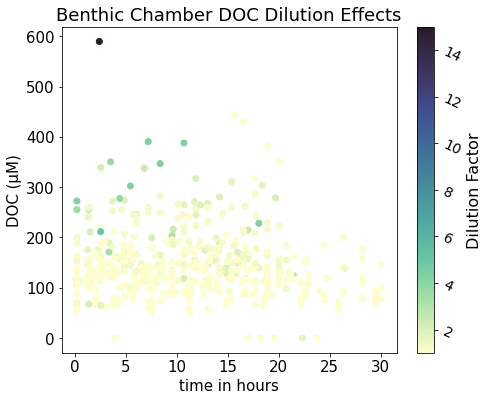

In [9]:
y = df_doc_bc['NPOC_uM']
x = df_doc_bc['Time']
colors = df_doc_bc['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.ylabel('DOC (\u03BCM)', fontsize=15)
plt.xlabel('time in hours', fontsize=15)
#plt.ylim(0,140)
#plt.xlim(0,2000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Benthic Chamber DOC Dilution Effects', fontsize=18)

plt.show()

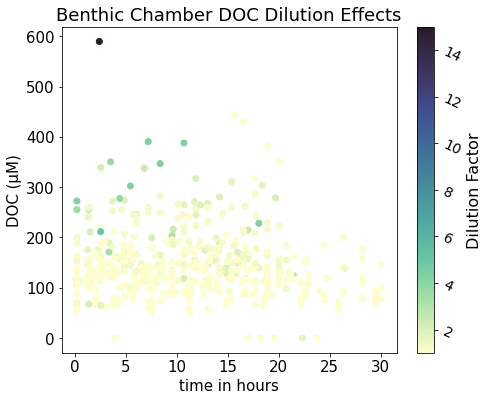

In [10]:
y = df_doc_bc['NPOC_uM']
x = df_doc_bc['Time']
colors = df_doc_bc['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.ylabel('DOC (\u03BCM)', fontsize=15)
plt.xlabel('time in hours', fontsize=15)
#plt.ylim(-1,500)
#plt.xlim(0,2000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Benthic Chamber DOC Dilution Effects', fontsize=18)

plt.show()

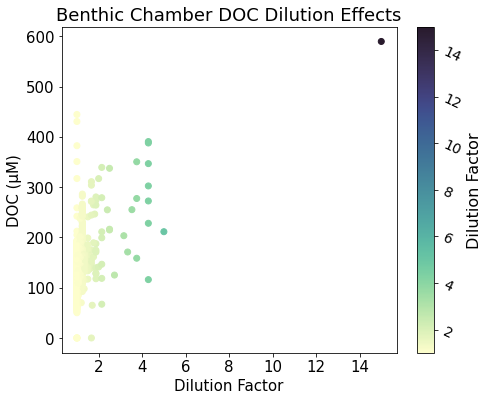

In [11]:
y = df_doc_bc['NPOC_uM']
x = df_doc_bc['dil_fac']
colors = df_doc_bc['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.ylabel('DOC (\u03BCM)', fontsize=15)
plt.xlabel('Dilution Factor', fontsize=15)
#plt.ylim(0,140)
#plt.xlim(0,2000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Benthic Chamber DOC Dilution Effects', fontsize=18)

plt.show()

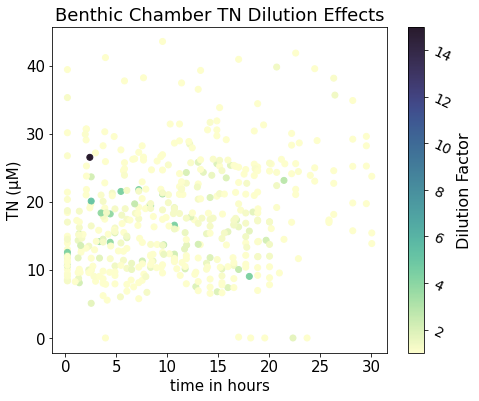

In [12]:
y = df_doc_bc['TN_uM']
x = df_doc_bc['Time']
colors = df_doc_bc['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.ylabel('TN (\u03BCM)', fontsize=15)
plt.xlabel('time in hours', fontsize=15)
#plt.ylim(0,140)
#plt.xlim(0,2000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Benthic Chamber TN Dilution Effects', fontsize=18)

plt.show()

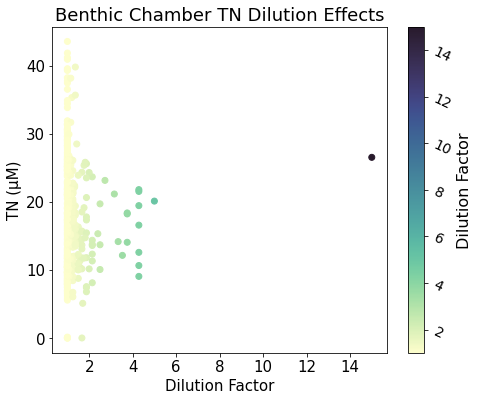

In [13]:
y = df_doc_bc['TN_uM']
x = df_doc_bc['dil_fac']
colors = df_doc_bc['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.ylabel('TN (\u03BCM)', fontsize=15)
plt.xlabel('Dilution Factor', fontsize=15)
#plt.ylim(0,140)
#plt.xlim(0,2000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Benthic Chamber TN Dilution Effects', fontsize=18)

plt.show()

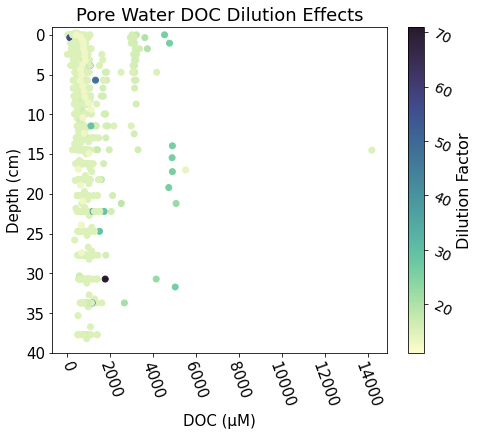

In [14]:
x = df_doc_pw['NPOC_uM']
y = df_doc_pw['Depth']
colors = df_doc_pw['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.xlabel('DOC (\u03BCM)', fontsize=15)
plt.ylabel('Depth (cm)', fontsize=15)
plt.ylim(40,-1)
#plt.xlim(0,2000)
plt.xticks(fontsize=15, rotation = -70)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Pore Water DOC Dilution Effects', fontsize=18)

plt.show()

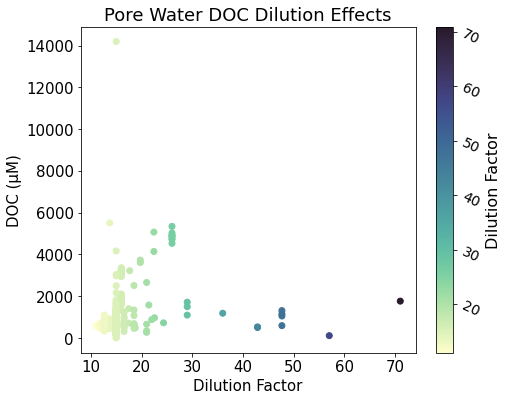

In [15]:
y = df_doc_pw['NPOC_uM']
x = df_doc_pw['dil_fac']
colors = df_doc_pw['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.ylabel('DOC (\u03BCM)', fontsize=15)
plt.xlabel('Dilution Factor', fontsize=15)
#plt.ylim(0,140)
#plt.xlim(0,2000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Pore Water DOC Dilution Effects', fontsize=18)

plt.show()

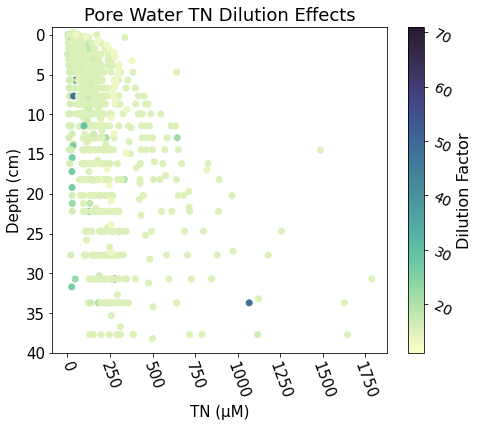

In [16]:
x = df_doc_pw['TN_uM']
y = df_doc_pw['Depth']
colors = df_doc_pw['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.xlabel('TN (\u03BCM)', fontsize=15)
plt.ylabel('Depth (cm)', fontsize=15)
plt.ylim(40,-1)
#plt.xlim(0,2000)
plt.xticks(fontsize=15,rotation = -70)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Pore Water TN Dilution Effects', fontsize=18)

plt.show()

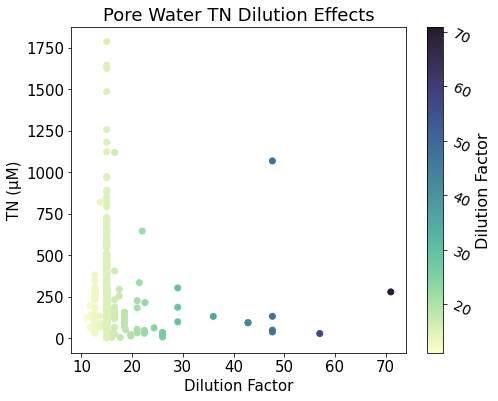

In [17]:
y = df_doc_pw['TN_uM']
x = df_doc_pw['dil_fac']
colors = df_doc_pw['dil_fac']

# create scatter plot
fig = plt.figure(figsize=(7.5, 6), facecolor='w')
plt.scatter(x, y, c=colors, cmap=cmo.deep)

# set plot title and labels
plt.ylabel('TN (\u03BCM)', fontsize=15)
plt.xlabel('Dilution Factor', fontsize=15)
#plt.ylim(0,140)
#plt.xlim(0,2000)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# add colorbar legend
cb = plt.colorbar()
cb.set_label('Dilution Factor', fontsize=16)
cb.ax.tick_params(labelsize=14, rotation = -25)

#titel 
plt.title('Pore Water TN Dilution Effects', fontsize=18)

plt.show()

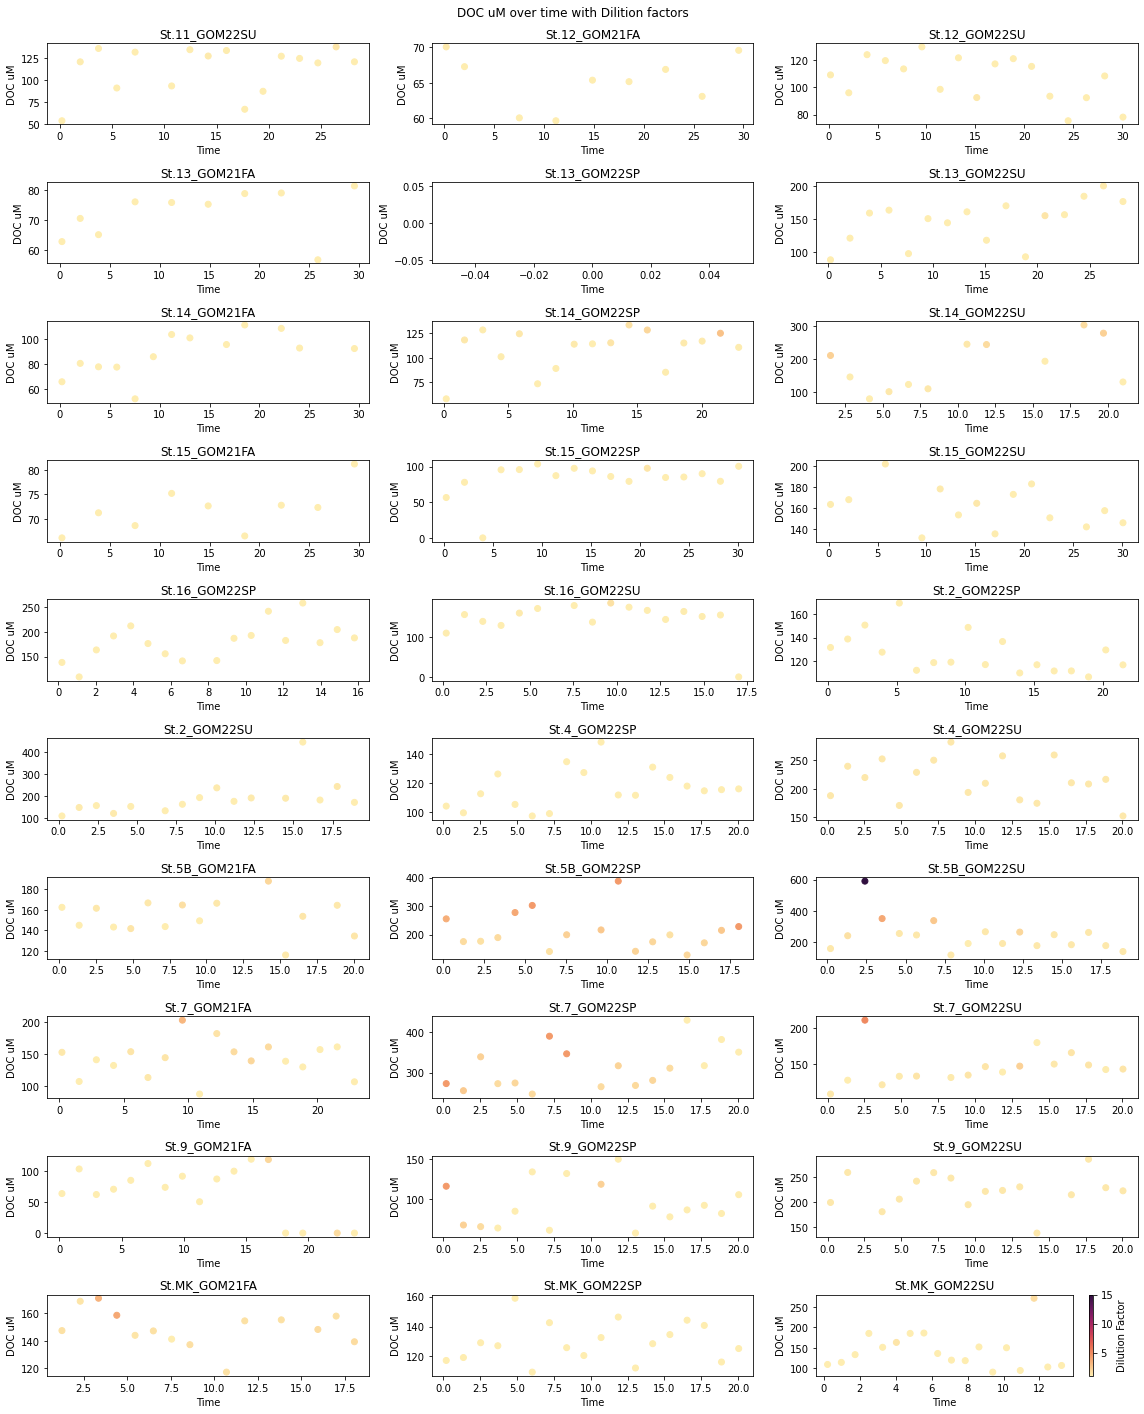

In [18]:
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

min_dil_fac = df_doc_bc['dil_fac'].min()
max_dil_fac = df_doc_bc['dil_fac'].max()

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['Time']
    y = group['NPOC_uM']
    c = group['dil_fac']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c=c, cmap=cmo.matter, label='Dilution Factor', vmin=min_dil_fac, vmax=max_dil_fac)
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('DOC uM')

# Add overall figure labels and color bar
fig.suptitle(r'DOC uM over time with Dilition factors' '\n')
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmo.matter)
sm.set_array(df_doc_bc['dil_fac'])
plt.colorbar(sm, label='Dilution Factor')
plt.show()


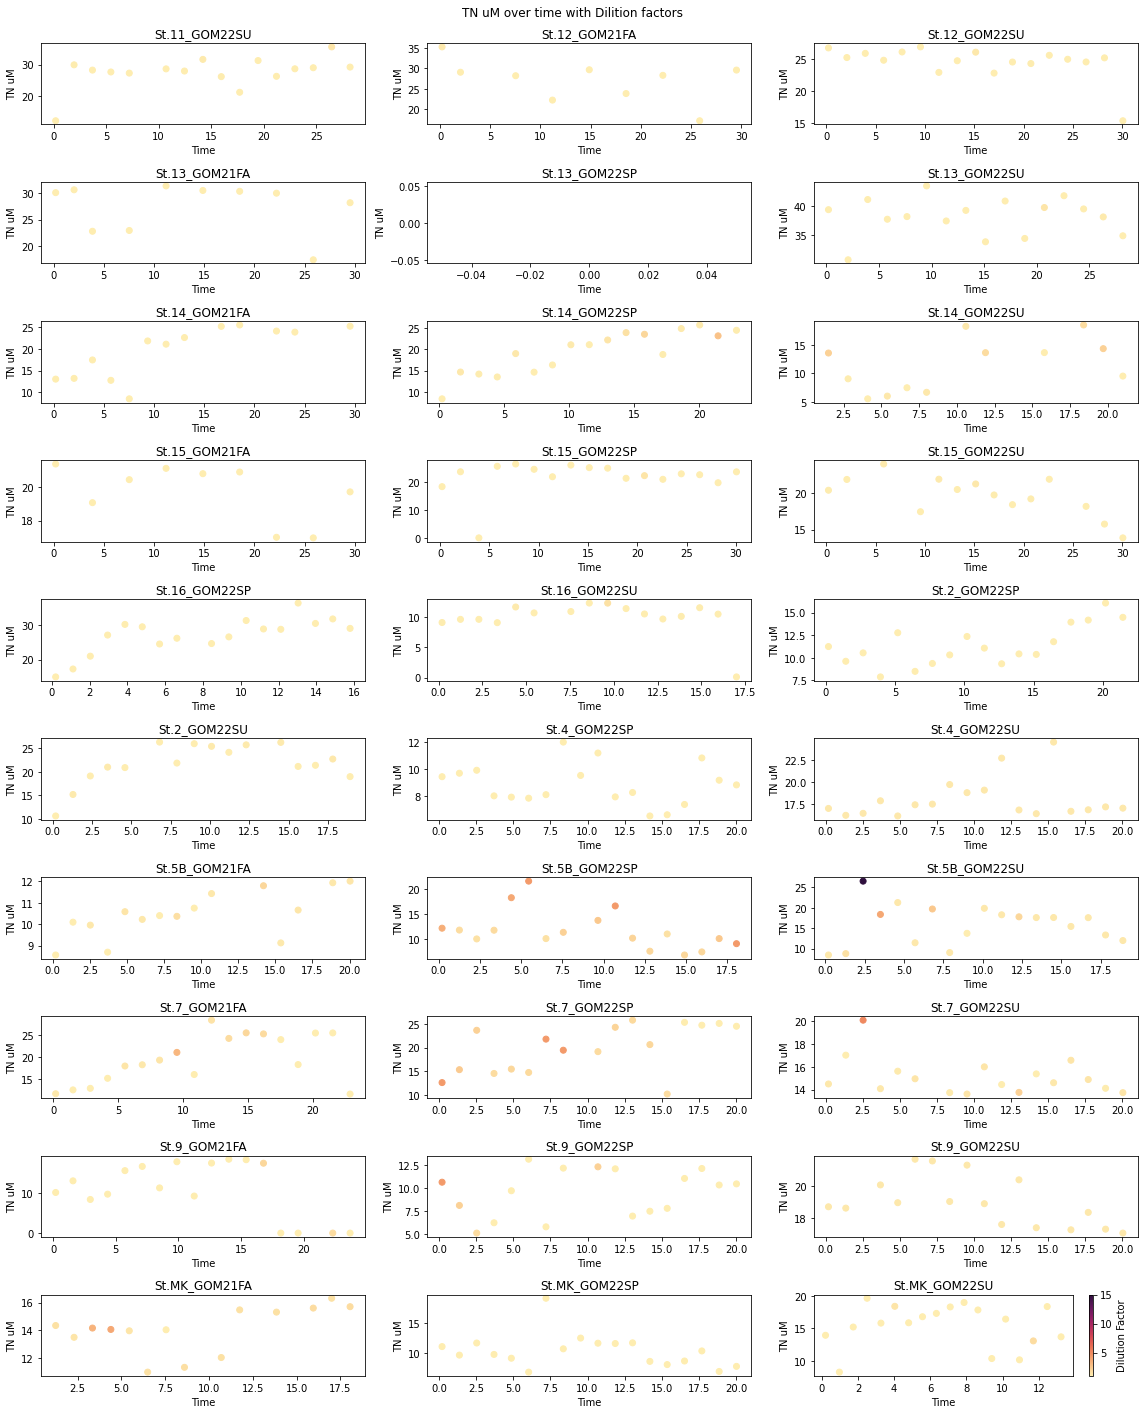

In [19]:
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['Time']
    y = group['TN_uM']
    c = group['dil_fac']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c=c, cmap=cmo.matter, label='Dilution Factor', vmin=min_dil_fac, vmax=max_dil_fac)
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('TN uM')

# Add overall figure labels and color bar
fig.suptitle(r'TN uM over time with Dilition factors' '\n')
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmo.matter)
sm.set_array(df_doc_bc['dil_fac'])
plt.colorbar(sm, label='Dilution Factor')
plt.show()


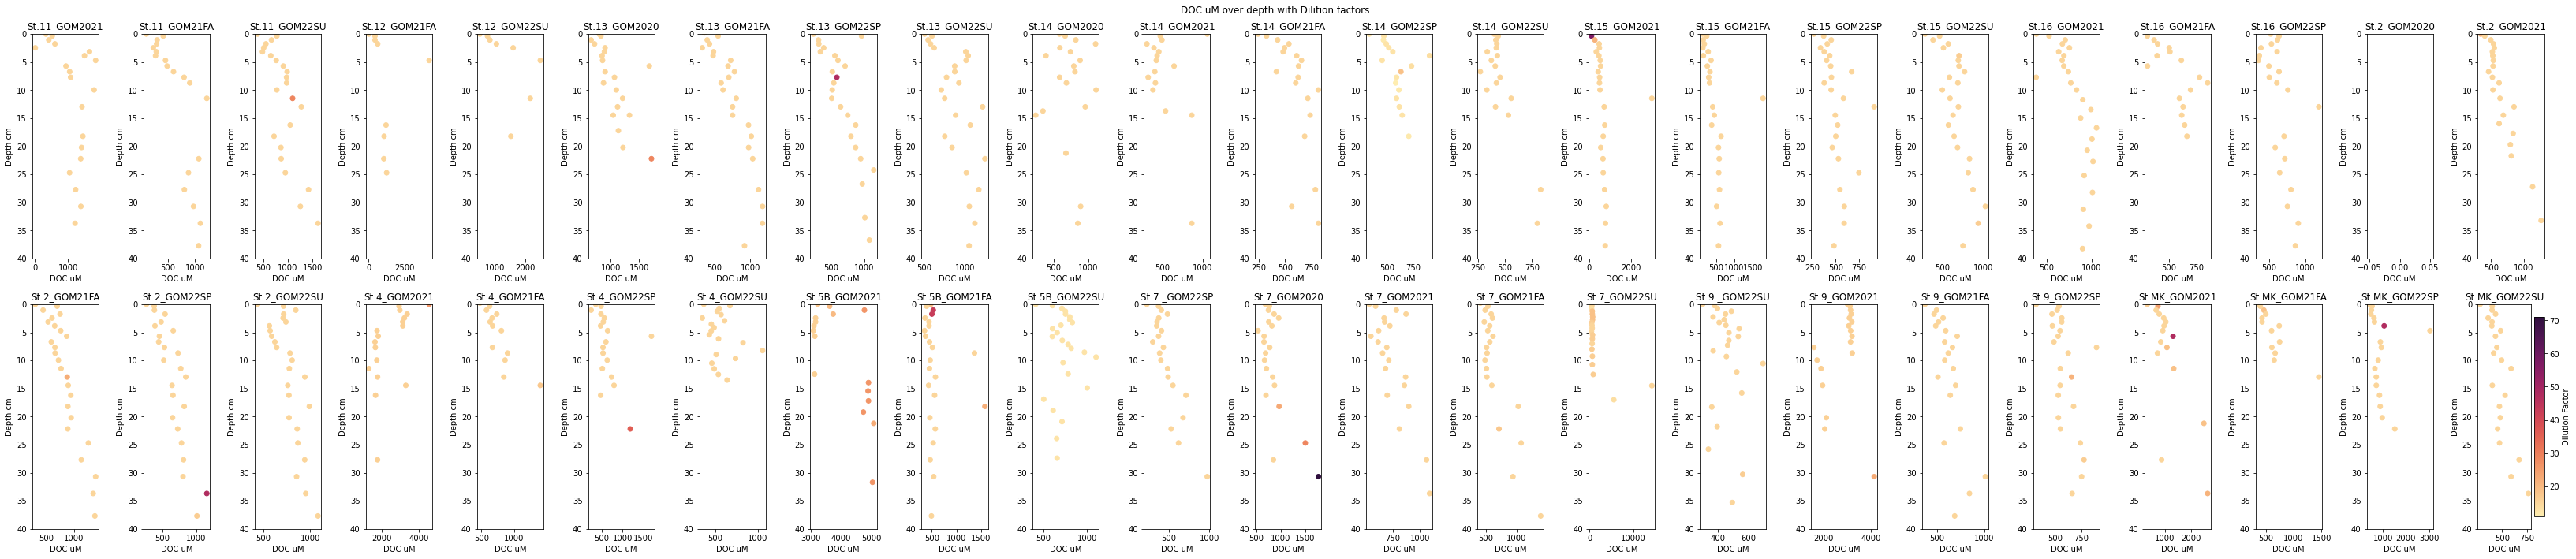

In [20]:
fig, axs = plt.subplots(nrows=2, ncols=23, figsize=(45, 10)) 

min_dil_fac = df_doc_pw['dil_fac'].min()
max_dil_fac = df_doc_pw['dil_fac'].max()

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_pw.groupby('code')):
    # Extract x, y, and c data from the group
    y = group['Depth']
    x = group['NPOC_uM']
    c = group['dil_fac']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 23, i % 23]
    sc = ax.scatter(x, y, c=c, cmap=cmo.matter, label='Dilution Factor', vmin=min_dil_fac, vmax=max_dil_fac)
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_ylabel('Depth cm')
    ax.set_xlabel('DOC uM')
    ax.set_ylim(40,0)

# Add overall figure labels and color bar
fig.suptitle(r'DOC uM over depth with Dilition factors' )
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmo.matter)
sm.set_array(df_doc_pw['dil_fac'])
plt.colorbar(sm, label='Dilution Factor')
plt.show()


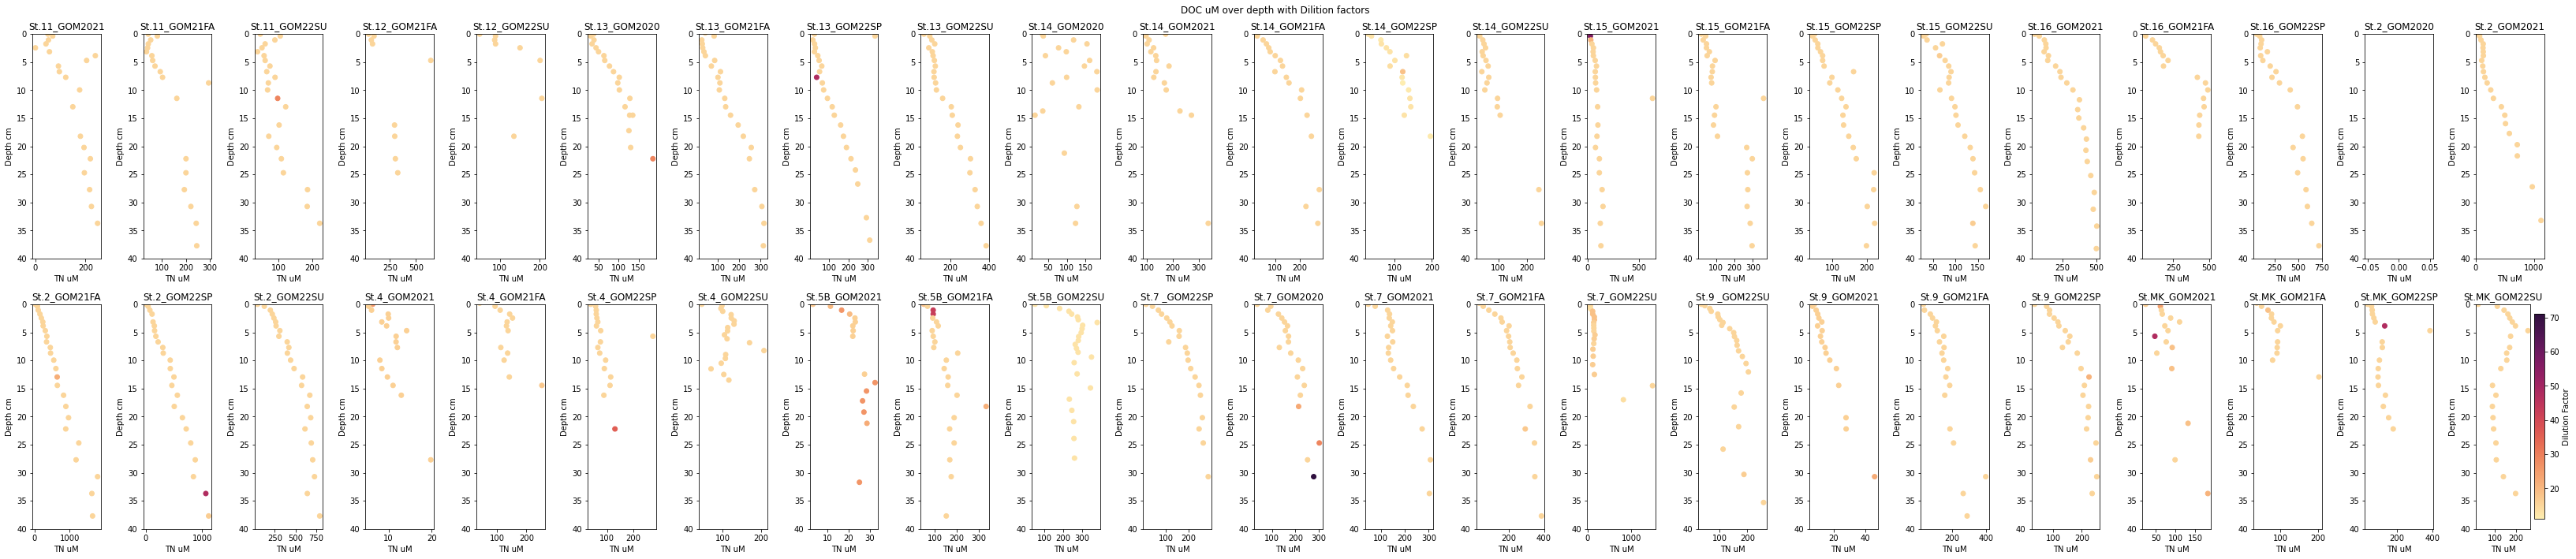

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=23, figsize=(45, 10)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_pw.groupby('code')):
    # Extract x, y, and c data from the group
    y = group['Depth']
    x = group['TN_uM']
    c = group['dil_fac']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 23, i % 23]
    sc = ax.scatter(x, y, c=c, cmap=cmo.matter, label='Dilution Factor', vmin=min_dil_fac, vmax=max_dil_fac)
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_ylabel('Depth cm')
    ax.set_xlabel('TN uM')
    ax.set_ylim(40,0)

# Add overall figure labels and color bar
fig.suptitle(r'DOC uM over depth with Dilition factors')
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap=cmo.matter)
sm.set_array(df_doc_pw['dil_fac'])
plt.colorbar(sm, label='Dilution Factor')
plt.show()


Determed from the figures that the Dilution past 6 times in the BC arificallly inflates the concentration. 

In [22]:
#remove values with a dilution factor above 6 

# Get the rows where 'dil_fac' is greater than 6
dropped_rows = df_doc_bc[df_doc_bc['dil_fac'] > 2]

# Drop the rows where 'dil_fac' is greater than 6
df_doc_bc = df_doc_bc[df_doc_bc['dil_fac'] <= 2]

# Print the dropped rows' "Location" and "Campaign" values
print(dropped_rows[['Location', 'Campaign']])

          Location Campaign
Sample ID                  
214644       St.MK  GOM21FA
214645       St.MK  GOM21FA
214848        St.7  GOM21FA
221441        St.7  GOM22SP
221442        St.7  GOM22SP
221443        St.7  GOM22SP
221447        St.7  GOM22SP
221448        St.7  GOM22SP
221741       St.5B  GOM22SP
221745       St.5B  GOM22SP
221746       St.5B  GOM22SP
221748       St.5B  GOM22SP
221750       St.5B  GOM22SP
221751       St.5B  GOM22SP
221757       St.5B  GOM22SP
221758       St.5B  GOM22SP
221941        St.9  GOM22SP
221942        St.9  GOM22SP
221950        St.9  GOM22SP
221557       St.14  GOM22SP
224343       St.5B  GOM22SU
224344       St.5B  GOM22SU
224347       St.5B  GOM22SU
224442       St.14  GOM22SU
224456       St.14  GOM22SU
224543        St.7  GOM22SU
224552        St.7  GOM22SU


Determed from the figures that PW has some odd high values 

In [23]:
#get pw rows with high DOC and TN
pw_npoc_row = df_doc_pw[df_doc_pw['NPOC_uM'] > 14000]
pw_tn_row = df_doc_pw[df_doc_pw['TN_uM'] > 1500]

# Print the dropped rows' "Location" and "Campaign" values
print(pw_npoc_row[['Location', 'Campaign']])
print("Cheked, all good")
print(pw_tn_row[['Location', 'Campaign']])
print("Cheked, all good")

# Drop the rows where 'dil_fac' is greater than 6
df_doc_pw = df_doc_pw[df_doc_pw['NPOC_uM'] < 14000]

          Location Campaign
Sample ID                  
224518        St.7  GOM22SU
Cheked, all good
          Location Campaign
Sample ID                  
215322        St.2  GOM21FA
215323        St.2  GOM21FA
215324        St.2  GOM21FA
Cheked, all good


# PART 3: Data Clean up 

Normal distrobution

Text(0.5, 1.0, 'DOC BC')

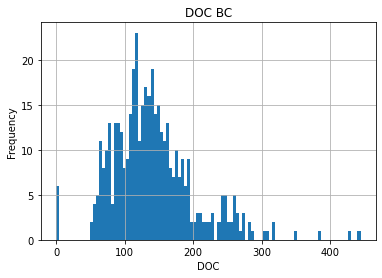

In [24]:
#plot a histogram of the 'DOC' column
df_doc_bc['NPOC_uM'].hist(bins = 100)
plt.xlabel('DOC')
plt.ylabel('Frequency')
plt.title('DOC BC')

Text(0.5, 1.0, 'DOC PW')

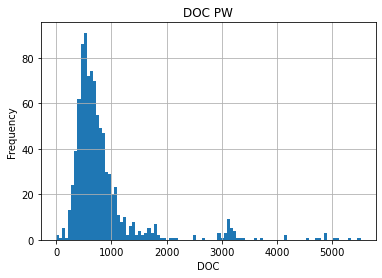

In [25]:
#plot a histogram of the 'DOC' column
df_doc_pw['NPOC_uM'].hist(bins = 100)
plt.xlabel('DOC')
plt.ylabel('Frequency')
plt.title('DOC PW')

Text(0.5, 1.0, 'DOC PW')

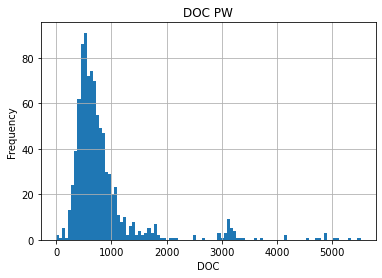

In [26]:
#clean up outliers 
#df_doc_pw.loc[df_doc_pw['NPOC_uM'] > (df_doc_pw['NPOC_uM'].mean() + 4.5 * df_doc_pw['NPOC_uM'].std()), 'NPOC_uM'] = np.nan

#plot a histogram of the 'DOC' column
df_doc_pw['NPOC_uM'].hist(bins = 100)
plt.xlabel('DOC')
plt.ylabel('Frequency')
plt.title('DOC PW')

Text(0.5, 1.0, 'DOC WC')

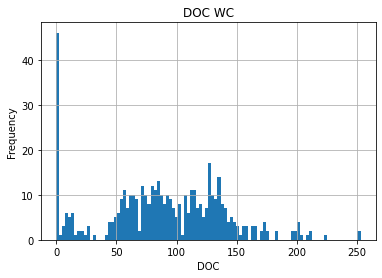

In [27]:
#plot a histogram of the 'DOC' column
df_doc_wc['NPOC_uM'].hist(bins = 100)
plt.xlabel('DOC')
plt.ylabel('Frequency')
plt.title('DOC WC')

Text(0.5, 1.0, 'BC TN')

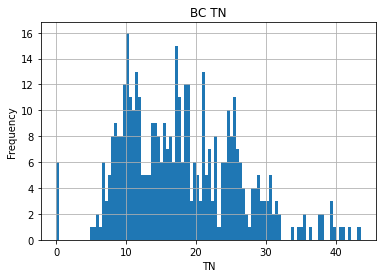

In [28]:
#plot a histogram of the 'TN' column
df_doc_bc['TN_uM'].hist(bins = 100)
plt.xlabel('TN')
plt.ylabel('Frequency')
plt.title('BC TN')

Text(0.5, 1.0, 'BC TN')

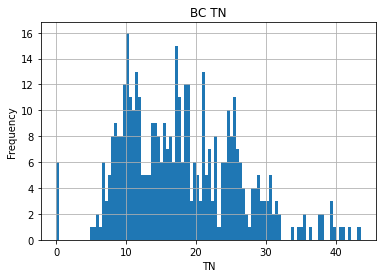

In [29]:
#clean up outliers 
#df_doc_bc.loc[df_doc_bc['TN_uM'] > (df_doc_bc['TN_uM'].mean() + 2.14 * df_doc_bc['TN_uM'].std()), 'TN_uM'] = np.nan

df_doc_bc['TN_uM'].hist(bins = 100)
plt.xlabel('TN')
plt.ylabel('Frequency')
plt.title('BC TN')

Text(0.5, 1.0, 'PW TN')

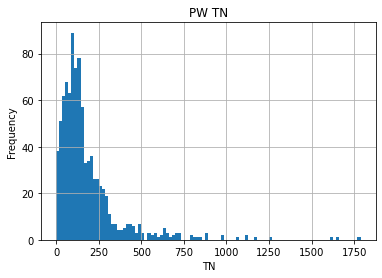

In [30]:
#plot a histogram of the 'TN' column
df_doc_pw['TN_uM'].hist(bins = 100)
plt.xlabel('TN')
plt.ylabel('Frequency')
plt.title('PW TN')

Text(0.5, 1.0, 'BC TN')

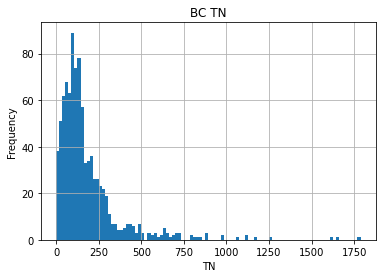

In [31]:
#clean up outliers 
#df_doc_pw.loc[df_doc_pw['TN_uM'] > (df_doc_pw['TN_uM'].mean() + 3 * df_doc_pw['TN_uM'].std()), 'TN_uM'] = np.nan

df_doc_pw['TN_uM'].hist(bins = 100)
plt.xlabel('TN')
plt.ylabel('Frequency')
plt.title('BC TN')

Text(0.5, 1.0, 'BC fe2')

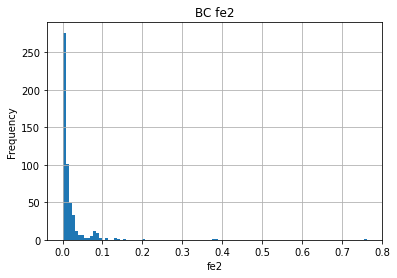

In [32]:
#plot a histogram of the 'fe2' column
df_iron_bc['Fe2_uM'].hist(bins = 100)
plt.xlabel('fe2')
plt.ylabel('Frequency')
plt.title('BC fe2')

Text(0.5, 1.0, 'BC fe2')

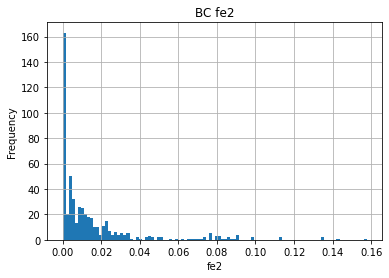

In [33]:
#clean up outliers 
df_iron_bc.loc[df_iron_bc['Fe2_uM'] > (df_iron_bc['Fe2_uM'].mean() + 3 * df_iron_bc['Fe2_uM'].std()), 'Fe2_uM'] = np.nan

#plot a histogram of the 'fe2' column
df_iron_bc['Fe2_uM'].hist(bins = 100)
plt.xlabel('fe2')
plt.ylabel('Frequency')
plt.title('BC fe2')

Text(0.5, 1.0, 'BC fet')

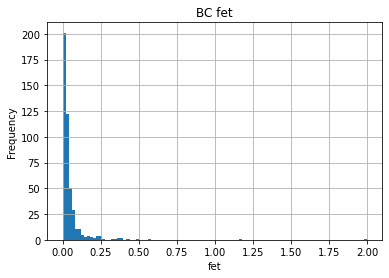

In [34]:
#plot a histogram of the 'feT' column
df_iron_bc['FeT_uM'].hist(bins = 100)
plt.xlabel('fet')
plt.ylabel('Frequency')
plt.title('BC fet')

Text(0.5, 1.0, 'BC fet')

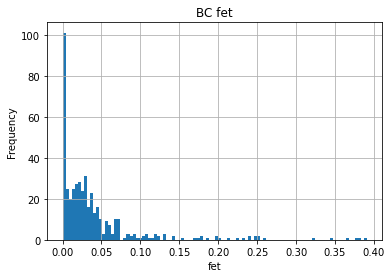

In [35]:
#clean up outliers 
df_iron_bc.loc[df_iron_bc['FeT_uM'] > (df_iron_bc['FeT_uM'].mean() + 3 * df_iron_bc['FeT_uM'].std()), 'FeT_uM'] = np.nan

#plot a histogram of the 'fe2' column
df_iron_bc['FeT_uM'].hist(bins = 100)
plt.xlabel('fet')
plt.ylabel('Frequency')
plt.title('BC fet')

Text(0.5, 1.0, 'BC fe3')

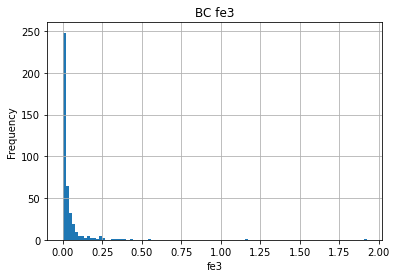

In [36]:
#plot a histogram of the 'fe3' column
df_iron_bc['Fe3_uM'].hist(bins = 100)
plt.xlabel('fe3')
plt.ylabel('Frequency')
plt.title('BC fe3')

Text(0.5, 1.0, 'BC fe3')

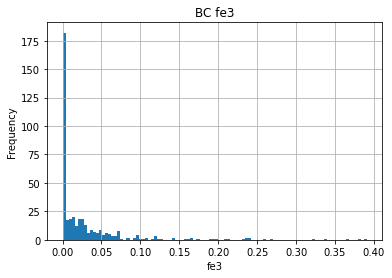

In [37]:
#clean up outliers 
df_iron_bc.loc[df_iron_bc['Fe3_uM'] > (df_iron_bc['Fe3_uM'].mean() + 3 * df_iron_bc['Fe3_uM'].std()), 'Fe3_uM'] = np.nan

#plot a histogram of the 'fe2' column
df_iron_bc['Fe3_uM'].hist(bins = 100)
plt.xlabel('fe3')
plt.ylabel('Frequency')
plt.title('BC fe3')

Text(0.5, 1.0, 'a 412')

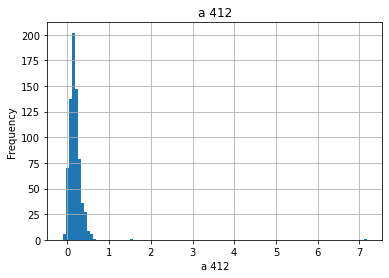

In [38]:
#plot a histogram of the 'CDOM' column
df_cdom_bc['abs_412'].hist(bins = 100)
plt.xlabel('a 412')
plt.ylabel('Frequency')
plt.title('a 412')

Text(0.5, 1.0, 'a 412')

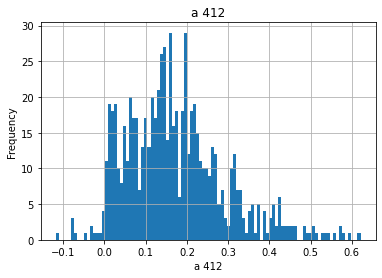

In [39]:
#clean up outliers 
df_cdom_bc.loc[df_cdom_bc['abs_412'] > (df_cdom_bc['abs_412'].mean() + 3 * df_cdom_bc['abs_412'].std()), 'abs_412'] = np.nan

#plot a histogram of the 'CDOM' column
df_cdom_bc['abs_412'].hist(bins = 100)
plt.xlabel('a 412')
plt.ylabel('Frequency')
plt.title('a 412')

Text(0.5, 1.0, 'a 412')

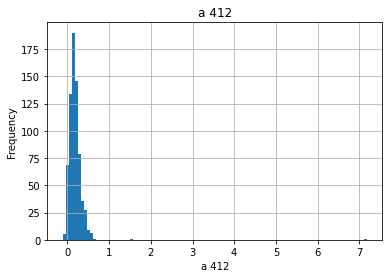

In [40]:
#plot a histogram of the 'CDOM spectra' column
df_spectra_bc['a_412'].hist(bins = 100)
plt.xlabel('a 412')
plt.ylabel('Frequency')
plt.title('a 412')

Text(0.5, 1.0, 'a 412')

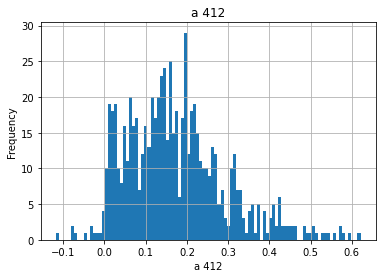

In [41]:
#clean up outliers 
df_spectra_bc.loc[df_spectra_bc['a_412'] > (df_spectra_bc['a_412'].mean() + 3 * df_spectra_bc['a_412'].std()), 'a_412'] = np.nan

#plot a histogram of the 'CDOM spectra' column
df_spectra_bc['a_412'].hist(bins = 100)
plt.xlabel('a 412')
plt.ylabel('Frequency')
plt.title('a 412')

# PART 4:  Combonation Data Sets

Make some comboation data sets for when we do corolation plots

In [42]:
#Put all the BC data together 
#remove repeat rows 
df_spectra_bc_cl = df_spectra_bc.drop(['Date', 'Type', 'Notes', 'date_time', 'code'], axis=1)
df_cdom_bc_cl = df_cdom_bc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'Core_Salinity',
                                 'Core_Temp_deg_C'], axis=1)
df_iron_bc_cl = df_iron_bc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_bc = df_spectra_bc_cl.join(df_doc_bc)
df_bc = df_bc.join(df_cdom_bc_cl)

#match up the inxdes for the merge 
df_iron_bc_cl['sample_index'] = df_iron_bc_cl.index.astype(str)
df_bc.index = df_bc.index.astype(str)

#combind the iron data 
df_bc = df_bc.join(df_iron_bc_cl)

#Put all the PW data together 
#remove repeat rows 
df_spectra_pw_cl = df_spectra_pw.drop(['Date', 'Type', 'Notes', 'date_time', 'code'], axis=1)
df_cdom_pw_cl = df_cdom_pw.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'Core_Salinity',
                                 'Core_Temp_deg_C'], axis=1)
df_iron_pw_cl = df_iron_pw.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_pw = df_spectra_pw_cl.join(df_doc_pw)
df_pw = df_pw.join(df_cdom_pw_cl)

#match up the inxdes for the merge 
df_iron_pw_cl['sample_index'] = df_iron_pw_cl.index.astype(str)
df_pw.index = df_pw.index.astype(str)

#combind the iron data 
df_pw = df_pw.join(df_iron_pw_cl)

#Put all the WC data together 
#remove repeat rows 
df_spectra_wc_cl = df_spectra_wc.drop(['Date', 'Type', 'Notes', 'date_time', 'code'], axis=1)
df_cdom_wc_cl = df_cdom_wc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 
                                 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'Core_Salinity',
                                 'Core_Temp_deg_C'], axis=1)
df_iron_wc_cl = df_iron_wc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)

#combind DOC and CDOM data 
df_wc = df_spectra_wc_cl.join(df_doc_wc)
df_wc = df_wc.join(df_cdom_wc_cl)

#match up the inxdes for the merge 
df_iron_wc_cl['sample_index'] = df_iron_wc_cl.index.astype(str)
df_wc.index = df_wc.index.astype(str)

#combind the iron data 
df_wc = df_wc.join(df_iron_wc_cl)

df_wc.to_csv('../../../Data_Thesis/data_sets_sats_work/df_wc.csv', index=False)
df_bc.to_csv('../../../Data_Thesis/data_sets_sats_work/df_bc.csv', index=False)
df_pw.to_csv('../../../Data_Thesis/data_sets_sats_work/df_pw.csv', index=False)

# PART 5: Benthic Chamber figures 

this part make BC figures 

Here we see each paramiter over time 

Each figure is for each campain 

all the figures auto save

In [43]:
#SUMMER 2021

#data set that is just one camp at a time 
select = "GOM2021"

#get the selection data subsets 
ds_cdom_bc = df_cdom_bc[df_cdom_bc['Trip'] == select]
ds_spectra_bc = df_spectra_bc[df_spectra_bc['Trip'] == select]
ds_iron_bc = df_iron_bc[df_iron_bc['Campaign'] == select]
ds_doc_bc = df_doc_bc[df_doc_bc['Campaign'] == select]

#get the columns 
col_order = ds_cdom_bc['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')


#deployment notes 
df_locs['notes'] = ""
df_locs.loc[df_locs['Station'] == 'St.5B', 'notes'] = 'Chamber did not seal'
df_locs.loc[df_locs['Station'] == 'St.14', 'notes'] = 'Deep lander motors stopped during run'
df_locs.loc[df_locs['Station'] == 'St.2', 'notes'] = 'Sample 16 not connected to chamber? Last sample water colum?'
df_locs.loc[df_locs['Station'] == 'St.13', 'notes'] = 'Deep lander motors stopped during run'
df_locs.loc[df_locs['Station'] == 'St.16', 'notes'] = 'Benthic chamber not closed?'
df_locs.loc[df_locs['Station'] == 'St.7', 'notes'] = 'Benthic chamber not closed?'


#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_notes = df_locs["notes"].tolist()

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs_bc_gom21su = df_locs

df_locs

Station        Date  Water_depth  \
6   St.5B  2021-07-16         12.6   
5    St.4  2021-07-17         16.4   
9   St.MK  2021-07-15         16.7   
7    St.7  2021-07-26         39.0   
3   St.16  2021-07-24         62.0   
4    St.2  2021-07-22         62.0   
8    St.9  2021-07-20         78.0   
2   St.15  2021-07-23        285.0   
1   St.13  2021-07-21        328.0   
0   St.11  2021-07-25        946.0   

                                               notes  
6                               Chamber did not seal  
5                                                     
9                                                     
7                        Benthic chamber not closed?  
3                        Benthic chamber not closed?  
4  Sample 16 not connected to chamber? Last sampl...  
8                                                     
2                                                     
1              Deep lander motors stopped during run  
0

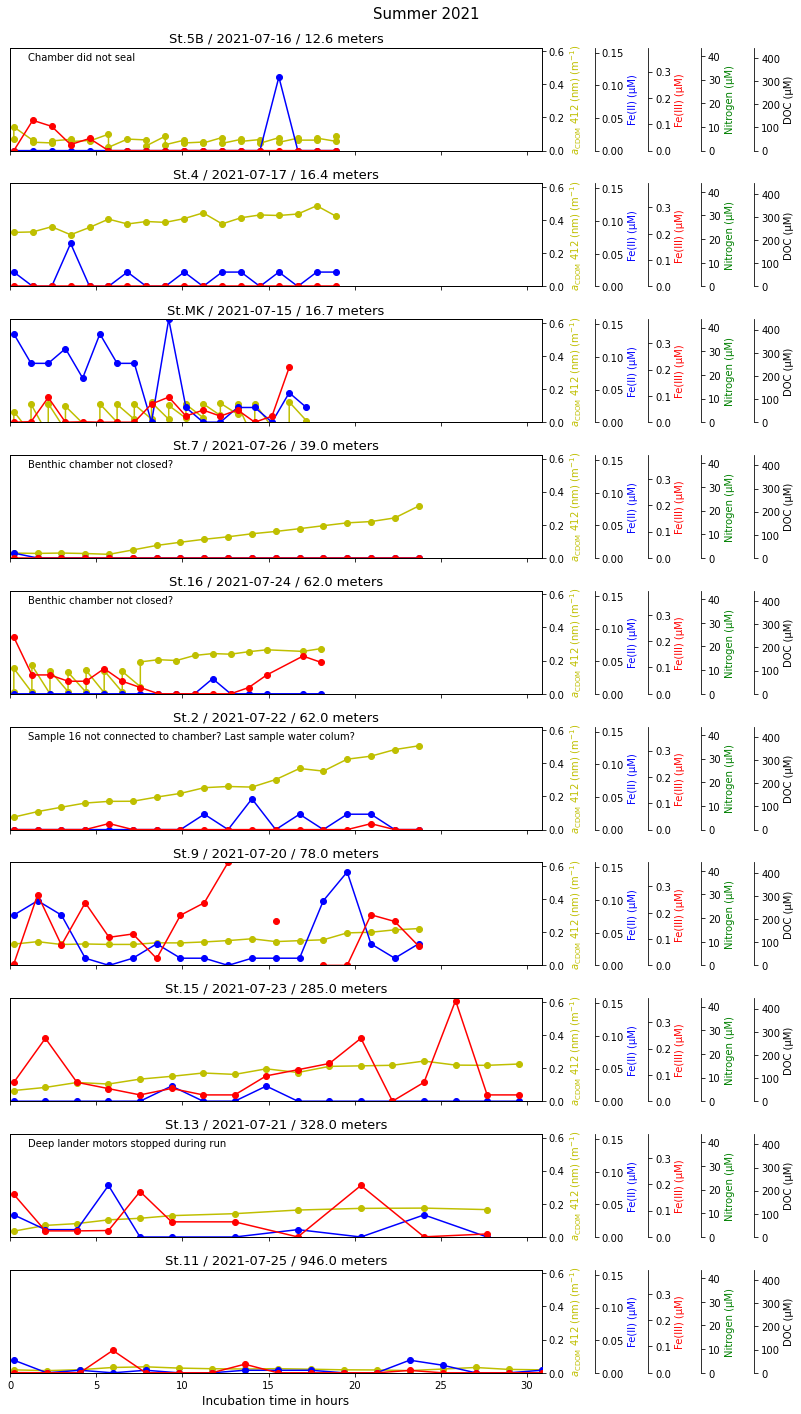

In [44]:
#ALL DATA GRAPH 
station_vals = col_order
fig, axs = plt.subplots(ncols=1, nrows=len(station_vals), figsize=(12, len(station_vals)*2), sharex=True)

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_bc[(ds_doc_bc['Location'] == station_val)]
    iron_data = ds_iron_bc[(ds_iron_bc['Location'] == station_val)]
    cdom_data = ds_cdom_bc[(ds_cdom_bc['Station'] == station_val)]
    spectra_data = ds_spectra_bc[(ds_spectra_bc['Station'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM']
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
        
    doc_time = doc_data['Time'] #X var 
    doc_time = np.asarray(doc_time, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_time = iron_data['Fe2_Time'] 
    fe_time = np.asarray(fe_time, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_time = spectra_data['BC_time']
    spectra_time = np.asarray(spectra_time, dtype=float).ravel()
    
    #plot DOC
    ax.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax.set_xlim(0,ds_spectra_bc['BC_time'].max())
    
    #plot doc lables off 
    ax.set_ylabel('')
    ax.tick_params(axis='y', length=0, width=0)
    ax.yaxis.set_ticklabels([])
    ax.set_title(f'{station_val} / {col_date[j]} / {col_maxd[j]} meters', size = 13)
            
    #plot CDOM
    ax2 = ax.twinx()
    ax2.plot(spectra_time, a412, 'o', ls='-', c='y')
    ax2.set_ylim(0,df_spectra_bc['a_412'].max())
    ax2.set_ylabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 10, c='y')
        
    #plot iron 2     
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.plot(fe_time, fe2_uM, 'o', ls='-', c='b')
    ax3.set_ylim(0,df_iron_bc['Fe2_uM'].max())
    ax3.set_ylabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot iron 3 
    ax4 = ax.twinx()
    ax4.spines["right"].set_position(("axes", 1.2))
    ax4.plot(fe_time, fe3_uM, 'o', ls='-', c='r')
    ax4.set_ylim(0,df_iron_bc['Fe3_uM'].max())
    ax4.set_ylabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot nitrogen
    ax5 = ax.twinx()
    ax5.spines["right"].set_position(("axes", 1.3))
    ax5.plot(doc_time, tn_uM, 'o', ls='-', c='g')
    ax5.set_ylim(0,df_doc_bc['TN_uM'].max())
    ax5.set_ylabel('Nitrogen (\u03BCM)', size= 10, c='g')
    
    #plot DOC
    ax6 = ax.twinx()
    ax6.spines["right"].set_position(("axes", 1.4))
    ax6.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax6.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax6.set_ylabel('DOC (\u03BCM)', size = 10, c='black')
    
    #turn off other axis
    if j == len(station_vals)-1:
        ax.set_xlabel('Incubation time in hours', size= 12)
        
    ax.text(1, df_doc_bc['NPOC_uM'].max()*.88, f'{col_notes[j]}')
    
# add a global title to the figure
fig.suptitle("Summer 2021 \n", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Benthic_chamber_incubations/GOM2021.png")

# show the plot
plt.show()

In [45]:
#FALL 2021

#data set that is just one camp at a time 
select = "GOM21FA"

#get the selection data subsets 
ds_cdom_bc = df_cdom_bc[df_cdom_bc['Trip'] == select]
ds_spectra_bc = df_spectra_bc[df_spectra_bc['Trip'] == select]
ds_iron_bc = df_iron_bc[df_iron_bc['Campaign'] == select]
ds_doc_bc = df_doc_bc[df_doc_bc['Campaign'] == select]
ds_nisk = df_nisk[(df_nisk['camp'] == select)]

#get the columns 
col_order = ds_cdom_bc['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#get the CTD Oxogen and Salinity values 
ds_nisk = df_nisk[(df_nisk['camp'] == select)]
nisk_data = ds_nisk[ds_nisk['station'].isin(col_order)]
grouped_data = ds_nisk[ds_nisk['station'].isin(col_order)].groupby('station')
sal00_values = {}
oxy_values = {}
row_values = {}

#group them
for station, group in grouped_data:
    highest_row = group.loc[group['nbf'] == group['nbf'].max()]
    sal00_values[station] = highest_row['sal00'].iloc[0]
    oxy_values[station] = highest_row['sbeox0Mg/L'].iloc[0]

# create a new column with "NA" values for all rows
df_locs['sal'] = np.nan
df_locs['oxy'] = np.nan

# create a boolean mask to select only the rows where the Station is in sal00_values
mask = df_locs['Station'].isin(sal00_values.keys())
mask = df_locs['Station'].isin(oxy_values.keys())

# use the mask to select only those rows and add the sal00 values to the new column
df_locs.loc[mask, 'sal'] = [sal00_values[station] for station in df_locs.loc[mask, 'Station']]
df_locs.loc[mask, 'oxy'] = [oxy_values[station] for station in df_locs.loc[mask, 'Station']]

#deployment notes
df_locs['notes'] = ""
df_locs.loc[df_locs['Station'] == 'St.16', 'notes'] = 'TOC/TN analysis failed'
df_locs.loc[df_locs['Station'] == 'St.11', 'notes'] = 'TOC/TN analysis failed'

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_sal = df_locs["sal"].tolist()
col_sal = [round(x, 1) for x in col_sal]
col_oxy = df_locs["oxy"].tolist()
col_oxy = [round(x, 1) for x in col_oxy]
col_notes = df_locs["notes"].tolist()

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs_bc_gom21fa = df_locs

df_locs

Station        Date  Water_depth        sal       oxy  \
5   St.5B  2021-10-25         12.3  29.256237  6.685394   
8   St.MK  2021-10-27         16.5  26.572018  7.019276   
6    St.7  2021-10-31         39.2  31.361000  6.795839   
4   St.16  2021-11-08         58.2  25.548048  7.479117   
7    St.9  2021-11-01         80.6  30.071376  6.865876   
3   St.15  2021-11-02        264.9  32.471385  6.786733   
2   St.13  2021-11-07        464.0  33.856235  6.678220   
0   St.11  2021-11-10        934.0  36.351178  6.348355   
1   St.12  2021-11-09        970.0  35.604065  6.556814   

                    notes  
5                          
8                          
6                          
4  TOC/TN analysis failed  
7                          
3                          
2                          
0  TOC/TN analysis failed  
1

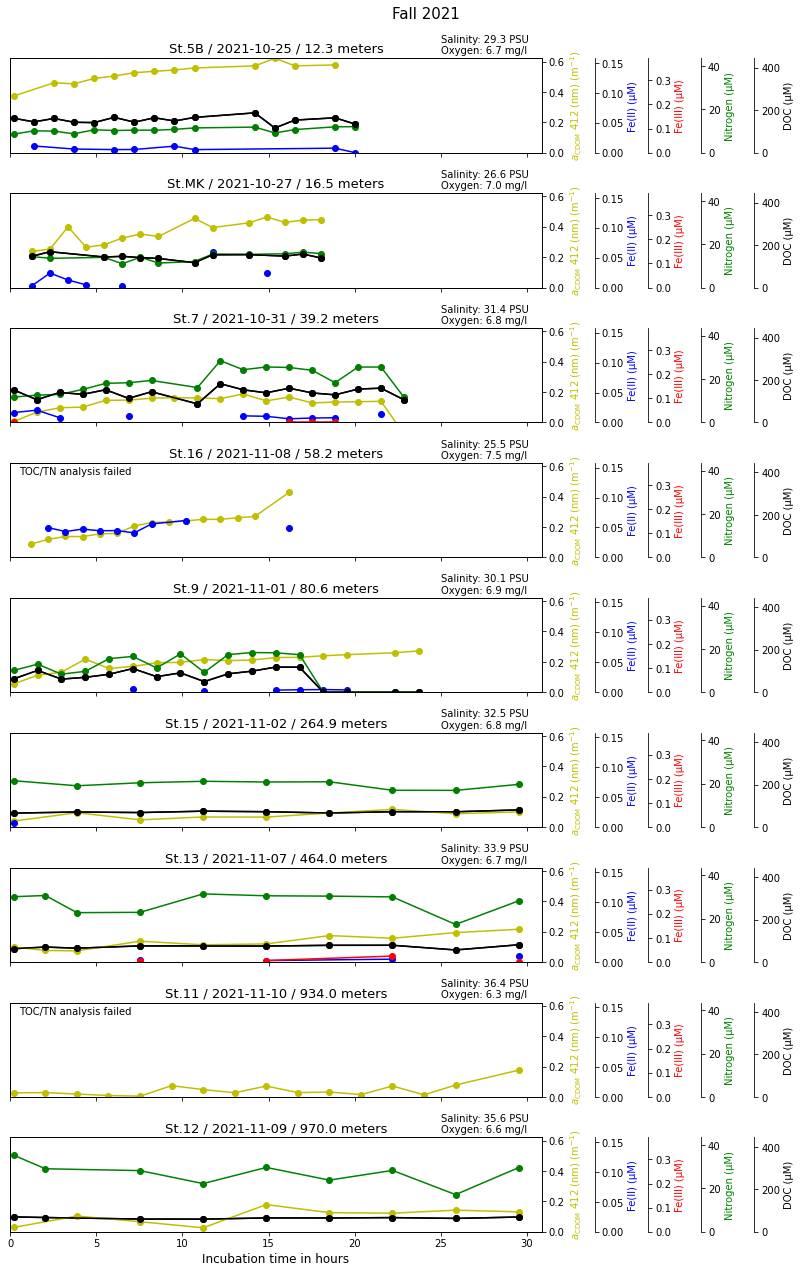

In [46]:
#ALL DATA GRAPH 
station_vals = col_order
fig, axs = plt.subplots(ncols=1, nrows=len(station_vals), figsize=(12, len(station_vals)*2), sharex=True)

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_bc[(ds_doc_bc['Location'] == station_val)]
    iron_data = ds_iron_bc[(ds_iron_bc['Location'] == station_val)]
    cdom_data = ds_cdom_bc[(ds_cdom_bc['Station'] == station_val)]
    spectra_data = ds_spectra_bc[(ds_spectra_bc['Station'] == station_val)]
    
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
        
    doc_time = doc_data['Time'] #X var 
    doc_time = np.asarray(doc_time, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_time = iron_data['Fe2_Time'] 
    fe_time = np.asarray(fe_time, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_time = spectra_data['BC_time']
    spectra_time = np.asarray(spectra_time, dtype=float).ravel()
    
    #plot DOC
    ax.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax.set_xlim(0,df_spectra_bc['BC_time'].max())
    
    #plot doc lables off 
    ax.set_ylabel('')
    ax.tick_params(axis='y', length=0, width=0)
    ax.yaxis.set_ticklabels([])
    ax.set_title(f'{station_val} / {col_date[j]} / {col_maxd[j]} meters', size = 13)
            
    #plot CDOM
    ax2 = ax.twinx()
    ax2.plot(spectra_time, a412, 'o', ls='-', c='y')
    ax2.set_ylim(0,df_spectra_bc['a_412'].max())
    ax2.set_ylabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 10, c='y')
        
    #plot iron 2     
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.plot(fe_time, fe2_uM, 'o', ls='-', c='b')
    ax3.set_ylim(0,df_iron_bc['Fe2_uM'].max())
    ax3.set_ylabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot iron 3 
    ax4 = ax.twinx()
    ax4.spines["right"].set_position(("axes", 1.2))
    ax4.plot(fe_time, fe3_uM, 'o', ls='-', c='r')
    ax4.set_ylim(0,df_iron_bc['Fe3_uM'].max())
    ax4.set_ylabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot nitrogen
    ax5 = ax.twinx()
    ax5.spines["right"].set_position(("axes", 1.3))
    ax5.plot(doc_time, tn_uM, 'o', ls='-', c='g')
    ax5.set_ylim(0,df_doc_bc['TN_uM'].max())
    ax5.set_ylabel('Nitrogen (\u03BCM)', size= 10, c='g')
    
    #plot DOC
    ax6 = ax.twinx()
    ax6.spines["right"].set_position(("axes", 1.4))
    ax6.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax6.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax6.set_ylabel('DOC (\u03BCM)', size = 10, c='black')
    
    #turn off other axis
    if j == len(station_vals)-1:
        ax.set_xlabel('Incubation time in hours', size= 12)
        
    ax.text(25, df_doc_bc['NPOC_uM'].max()*1.17, f'Salinity: {col_sal[j]} PSU')
    ax.text(25, df_doc_bc['NPOC_uM'].max()*1.05, f'Oxygen: {col_oxy[j]} mg/l')
    ax.text(.5, df_doc_bc['NPOC_uM'].max()*.88, f'{col_notes[j]}')
    
# add a global title to the figure
fig.suptitle("Fall 2021 \n", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Benthic_chamber_incubations/GOM21FA.png")

# show the plot
plt.show()

In [47]:
#Spring 2022

#data set that is just one camp at a time 
select = "GOM22SP"

#get the selection data subsets 
ds_cdom_bc = df_cdom_bc[df_cdom_bc['Trip'] == select]
ds_spectra_bc = df_spectra_bc[df_spectra_bc['Trip'] == select]
ds_iron_bc = df_iron_bc[df_iron_bc['Campaign'] == select]
ds_doc_bc = df_doc_bc[df_doc_bc['Campaign'] == select]

#get the columns 
col_order = ds_cdom_bc['Station'].unique()
col_order = col_order[ col_order != 'St.13']

#put the columns in order columns 
ds_wc_depths = df_spectra_wc[df_spectra_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#get the CTD Oxogen and Salinity values 
ds_nisk = df_nisk[(df_nisk['camp'] == select)]
nisk_data = ds_nisk[ds_nisk['station'].isin(col_order)]
grouped_data = ds_nisk[ds_nisk['station'].isin(col_order)].groupby('station')
sal00_values = {}
oxy_values = {}
row_values = {}

#group them
for station, group in grouped_data:
    highest_row = group.loc[group['nbf'] == group['nbf'].max()]
    sal00_values[station] = highest_row['sal00'].iloc[0]
    oxy_values[station] = highest_row['sbeox0Mg/L'].iloc[0]

# create a new column with "NA" values for all rows
df_locs['sal'] = np.nan
df_locs['oxy'] = np.nan

# create a boolean mask to select only the rows where the Station is in sal00_values
mask = df_locs['Station'].isin(sal00_values.keys())
mask = df_locs['Station'].isin(oxy_values.keys())

# use the mask to select only those rows and add the sal00 values to the new column
df_locs.loc[mask, 'sal'] = [sal00_values[station] for station in df_locs.loc[mask, 'Station']]
df_locs.loc[mask, 'oxy'] = [oxy_values[station] for station in df_locs.loc[mask, 'Station']]

#deployment notes
df_locs['notes'] = ""
df_locs.loc[df_locs['Station'] == 'St.9', 'notes'] = 'Last sample may have fired in the water column'
df_locs.loc[df_locs['Station'] == 'St.15', 'notes'] = 'particles were found in sample #1 because motor pause was too short by 32 minutes'
df_locs.loc[df_locs['Station'] == 'St.13', 'notes'] = 'Leak in the ISEA IV housing damaged the instrument and aborted the run after ~4 hours'
df_locs.loc[df_locs['Station'] == 'St.MK', 'notes'] = 'Last sample may have fired in the water column'
df_locs.loc[df_locs['Station'] == 'St.4', 'notes'] = 'Manip coupling popped, not sure if it was during descent or ascent'
df_locs.loc[df_locs['Station'] == 'St.14', 'notes'] = 'Some samples may be swapped from bad labeling'

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_sal = df_locs["sal"].tolist()
col_sal = [round(x, 1) for x in col_sal]
col_oxy = df_locs["oxy"].tolist()
col_oxy = [round(x, 1) for x in col_oxy]
col_notes = df_locs["notes"].tolist()

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs_bc_gom22sp = df_locs

df_locs

Station        Date  Water_depth        sal        oxy  \
5   St.5B  2022-04-14         14.4  30.750671   6.689108   
4    St.4  2022-04-20         17.5  29.026941   7.723549   
8   St.MK  2022-04-19         17.5  29.813576   8.057314   
6    St.7  2022-04-10         39.7  25.087086   7.655416   
2   St.16  2022-04-11         60.0  27.189133   6.801757   
3    St.2  2022-04-17         65.0  17.195098  11.105049   
7    St.9  2022-04-16         82.5  23.180618   8.117186   
0   St.14  2022-04-09         91.0  26.841422   9.410635   
1   St.15  2022-04-16        267.0        NaN        NaN   

                                               notes  
5                                                     
4  Manip coupling popped, not sure if it was duri...  
8     Last sample may have fired in the water column  
6                                                     
2                                                     
3                                                     
7     Last sample may have fired in the water column  
0      Some samples may be swapped from bad labeling  
1  particles were found in sample #1 because moto...

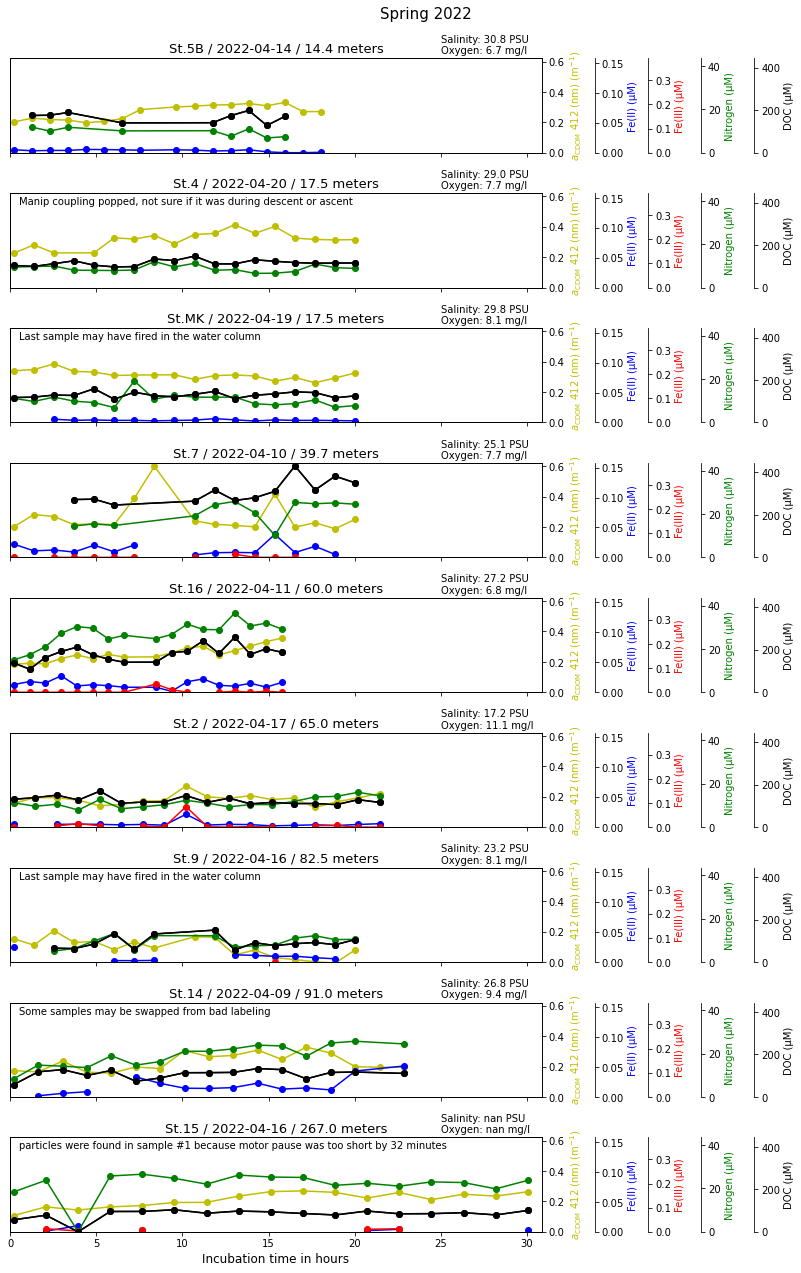

In [48]:
#ALL DATA GRAPH 
station_vals = col_order
fig, axs = plt.subplots(ncols=1, nrows=len(station_vals), figsize=(12, len(station_vals)*2), sharex=True)

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_bc[(ds_doc_bc['Location'] == station_val)]
    iron_data = ds_iron_bc[(ds_iron_bc['Location'] == station_val)]
    cdom_data = ds_cdom_bc[(ds_cdom_bc['Station'] == station_val)]
    spectra_data = ds_spectra_bc[(ds_spectra_bc['Station'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
      
    doc_time = doc_data['Time'] #X var 
    doc_time = np.asarray(doc_time, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_time = iron_data['Fe2_Time'] 
    fe_time = np.asarray(fe_time, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_time = spectra_data['BC_time']
    spectra_time = np.asarray(spectra_time, dtype=float).ravel()
    
    #plot DOC
    ax.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax.set_xlim(0,df_spectra_bc['BC_time'].max())
    
    #plot doc lables off 
    ax.set_ylabel('')
    ax.tick_params(axis='y', length=0, width=0)
    ax.yaxis.set_ticklabels([])
    ax.set_title(f'{station_val} / {col_date[j]} / {col_maxd[j]} meters', size = 13)
            
    #plot CDOM
    ax2 = ax.twinx()
    ax2.spines["right"].set_position(("axes", 1))
    ax2.plot(spectra_time, a412, 'o', ls='-', c='y')
    ax2.set_ylim(0,df_spectra_bc['a_412'].max())
    ax2.set_ylabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 10, c='y')
        
    #plot iron 2     
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.plot(fe_time, fe2_uM, 'o', ls='-', c='b')
    ax3.set_ylim(0,df_iron_bc['Fe2_uM'].max())
    ax3.set_ylabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot iron 3 
    ax4 = ax.twinx()
    ax4.spines["right"].set_position(("axes", 1.2))
    ax4.plot(fe_time, fe3_uM, 'o', ls='-', c='r')
    ax4.set_ylim(0,df_iron_bc['Fe3_uM'].max())
    ax4.set_ylabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot nitrogen
    ax5 = ax.twinx()
    ax5.spines["right"].set_position(("axes", 1.3))
    ax5.plot(doc_time, tn_uM, 'o', ls='-', c='g')
    ax5.set_ylim(0,df_doc_bc['TN_uM'].max()) 
    ax5.set_ylabel('Nitrogen (\u03BCM)', size= 10, c='g')
    
    #plot DOC
    ax6 = ax.twinx()
    ax6.spines["right"].set_position(("axes", 1.4))
    ax6.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax6.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax6.set_ylabel('DOC (\u03BCM)', size = 10, c='black')
    
    #turn off other axis
    if j == len(station_vals)-1:
        ax.set_xlabel('Incubation time in hours', size= 12)
        
    ax.text(25, df_doc_bc['NPOC_uM'].max()*1.17, f'Salinity: {col_sal[j]} PSU')
    ax.text(25, df_doc_bc['NPOC_uM'].max()*1.05, f'Oxygen: {col_oxy[j]} mg/l')
    ax.text(.5, df_doc_bc['NPOC_uM'].max()*.88, f'{col_notes[j]}')
    
# add a global title to the figure
fig.suptitle("Spring 2022 \n", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Benthic_chamber_incubations/GOM22SP.png")

# show the plot
plt.show()

In [49]:
#Summer 2022

#data set that is just one camp at a time 
select = "GOM22SU"

#get the selection data subsets 
ds_cdom_bc = df_cdom_bc[df_cdom_bc['Trip'] == select]
ds_spectra_bc = df_spectra_bc[df_spectra_bc['Trip'] == select]
ds_iron_bc = df_iron_bc[df_iron_bc['Campaign'] == select]
ds_doc_bc = df_doc_bc[df_doc_bc['Campaign'] == select]

#get the columns 
col_order = ds_cdom_bc['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#get the CTD Oxogen and Salinity values 
ds_nisk = df_nisk[(df_nisk['camp'] == select)]
nisk_data = ds_nisk[ds_nisk['station'].isin(col_order)]
grouped_data = ds_nisk[ds_nisk['station'].isin(col_order)].groupby('station')
sal00_values = {}
oxy_values = {}
row_values = {}

#group them
for station, group in grouped_data:
    highest_row = group.loc[group['nbf'] == group['nbf'].max()]
    sal00_values[station] = highest_row['sal00'].iloc[0]
    oxy_values[station] = highest_row['sbeox0Mg/L'].iloc[0]

# create a new column with "NA" values for all rows
df_locs['sal'] = np.nan
df_locs['oxy'] = np.nan

# create a boolean mask to select only the rows where the Station is in sal00_values
mask = df_locs['Station'].isin(sal00_values.keys())
mask = df_locs['Station'].isin(oxy_values.keys())

# use the mask to select only those rows and add the sal00 values to the new column
df_locs.loc[mask, 'sal'] = [sal00_values[station] for station in df_locs.loc[mask, 'Station']]
df_locs.loc[mask, 'oxy'] = [oxy_values[station] for station in df_locs.loc[mask, 'Station']]

#deployment notes
df_locs['notes'] = ""
df_locs.loc[df_locs['Station'] == 'St.4', 'notes'] = 'Sampling tubing may have disconnected on odd rack syringes'
df_locs.loc[df_locs['Station'] == 'St.5B', 'notes'] = 'Chamber may have not locked, lander was sideways upon recovery'
df_locs.loc[df_locs['Station'] == 'St.9', 'notes'] = 'Sample 3 may have fired before reaching seafloor'
df_locs.loc[df_locs['Station'] == 'St.MK', 'notes'] = 'Last sample collected in water column?'

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_sal = df_locs["sal"].tolist()
col_sal = [round(x, 1) for x in col_sal]
col_oxy = df_locs["oxy"].tolist()
col_oxy = [round(x, 1) for x in col_oxy]
col_notes = df_locs["notes"].tolist()

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs_bc_gom22su = df_locs

df_locs

Station        Date  Water_depth        sal       oxy  \
8    St.5B  2022-07-10         12.2  21.277180  6.764561   
7     St.4  2022-07-10         16.9  24.535378  6.223847   
11   St.MK  2022-07-23         17.5  19.954716  5.567649   
9     St.7  2022-07-12         40.7  25.524159  5.953590   
5    St.16  2022-07-20         57.2  22.220463  6.009673   
6     St.2  2022-07-19         62.0  20.761386  6.440314   
10    St.9  2022-07-17         80.2  24.440553  6.485220   
3    St.14  2022-07-16         88.6  24.160886  6.484204   
4    St.15  2022-07-15        268.0  24.743210  6.666246   
2    St.13  2022-07-18        490.0  22.919533  7.084496   
0    St.11  2022-07-22        947.0  31.587081  5.521906   
1    St.12  2022-07-21       1003.0  22.740878  6.627016   

                                                notes  
8   Chamber may have not locked, lander was sidewa...  
7   Sampling tubing may have disconnected on odd r...  
11             Last sample collected in water column?  
9                                                      
5                                                      
6                                                      
10   Sample 3 may have fired before reaching seafloor  
3                                                      
4                                                      
2                                                      
0                                                      
1

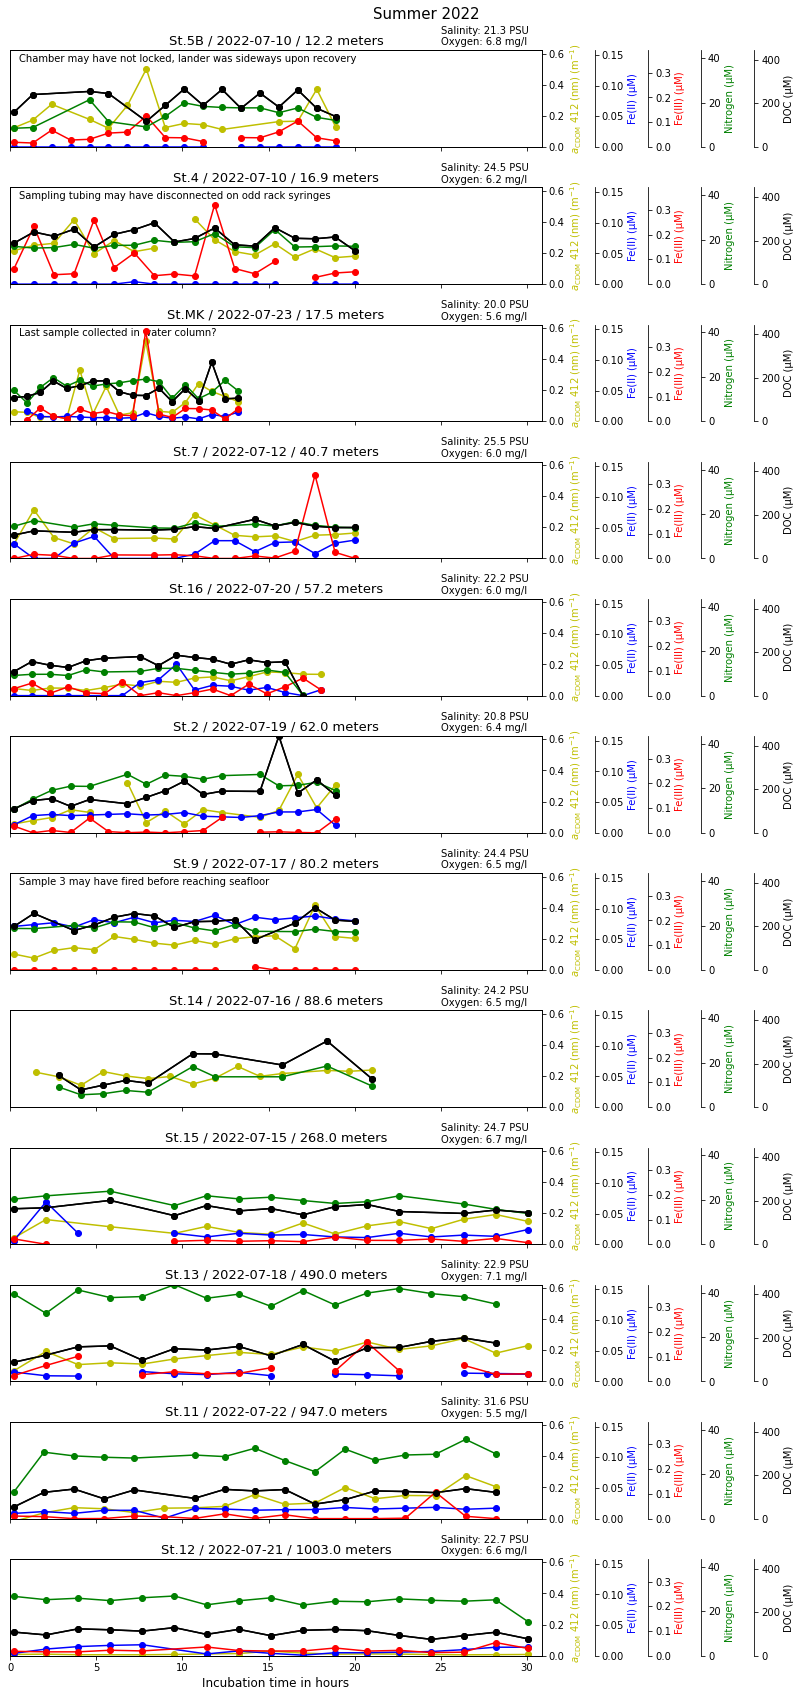

In [50]:
#ALL DATA GRAPH 
station_vals = col_order
fig, axs = plt.subplots(ncols=1, nrows=len(station_vals), figsize=(12, len(station_vals)*2), sharex=True)

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_bc[(ds_doc_bc['Location'] == station_val)]
    iron_data = ds_iron_bc[(ds_iron_bc['Location'] == station_val)]
    cdom_data = ds_cdom_bc[(ds_cdom_bc['Station'] == station_val)]
    spectra_data = ds_spectra_bc[(ds_spectra_bc['Station'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
        
    doc_time = doc_data['Time'] #X var 
    doc_time = np.asarray(doc_time, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_time = iron_data['Fe2_Time'] 
    fe_time = np.asarray(fe_time, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_time = spectra_data['BC_time']
    spectra_time = np.asarray(spectra_time, dtype=float).ravel()
    
    #plot DOC
    ax.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax.set_xlim(0,df_spectra_bc['BC_time'].max())
    
    #plot doc lables off 
    ax.set_ylabel('')
    ax.tick_params(axis='y', length=0, width=0)
    ax.yaxis.set_ticklabels([])
    ax.set_title(f'{station_val} / {col_date[j]} / {col_maxd[j]} meters', size = 13)
            
    #plot CDOM
    ax2 = ax.twinx()
    ax2.plot(spectra_time, a412, 'o', ls='-', c='y')
    ax2.set_ylim(0,df_spectra_bc['a_412'].max())
    ax2.set_ylabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 10, c='y')
        
    #plot iron 2     
    ax3 = ax.twinx()
    ax3.spines["right"].set_position(("axes", 1.1))
    ax3.plot(fe_time, fe2_uM, 'o', ls='-', c='b')
    ax3.set_ylim(0,df_iron_bc['Fe2_uM'].max())
    ax3.set_ylabel('Fe(II) (\u03BCM)', size= 10, c='b')
    
    #plot iron 3 
    ax4 = ax.twinx()
    ax4.spines["right"].set_position(("axes", 1.2))
    ax4.plot(fe_time, fe3_uM, 'o', ls='-', c='r')
    ax4.set_ylim(0,df_iron_bc['Fe3_uM'].max())
    ax4.set_ylabel('Fe(III) (\u03BCM)', size= 10, c='r')
    
    #plot nitrogen
    ax5 = ax.twinx()
    ax5.spines["right"].set_position(("axes", 1.3))
    ax5.plot(doc_time, tn_uM, 'o', ls='-', c='g')
    ax5.set_ylim(0,df_doc_bc['TN_uM'].max())
    ax5.set_ylabel('Nitrogen (\u03BCM)', size= 10, c='g')
    
    #plot DOC
    ax6 = ax.twinx()
    ax6.spines["right"].set_position(("axes", 1.4))
    ax6.plot(doc_time, doc_uM, 'o', ls='-', c='black')
    ax6.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax6.set_ylabel('DOC (\u03BCM)', size = 10, c='black')
    
    #turn off other axis
    if j == len(station_vals)-1:
        ax.set_xlabel('Incubation time in hours', size= 12)
        
    ax.text(25, df_doc_bc['NPOC_uM'].max()*1.17, f'Salinity: {col_sal[j]} PSU')
    ax.text(25, df_doc_bc['NPOC_uM'].max()*1.05, f'Oxygen: {col_oxy[j]} mg/l')
    ax.text(.5, df_doc_bc['NPOC_uM'].max()*.88, f'{col_notes[j]}')
    
# add a global title to the figure
fig.suptitle("Summer 2022 \n", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Benthic_chamber_incubations/GOM22SU.png")

# show the plot
plt.show()


# PART 6: Pore Water figures 

this part make pw figures 

Here we see each paramiter profile 

Each figure is for each campain 

all the figures auto save

In [51]:
#Summer 2021

#data set that is just one camp at a time 
select = "GOM2021"

#get the selection data subsets 
ds_cdom_pw = df_cdom_pw[df_cdom_pw['Trip'] == select]
ds_spectra_pw = df_spectra_pw[df_spectra_pw['Trip'] == select]
ds_iron_pw = df_iron_pw[df_iron_pw['Campaign'] == select]
ds_doc_pw = df_doc_pw[df_doc_pw['Campaign'] == select]

#get the columns 
col_order = ds_cdom_pw['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Station        Date  Water_depth
4    St.7  2021-07-26         39.0
2   St.16  2021-07-24         62.0
3    St.2  2021-07-22         62.0
1   St.15  2021-07-23        285.0
0   St.11  2021-07-25        946.0

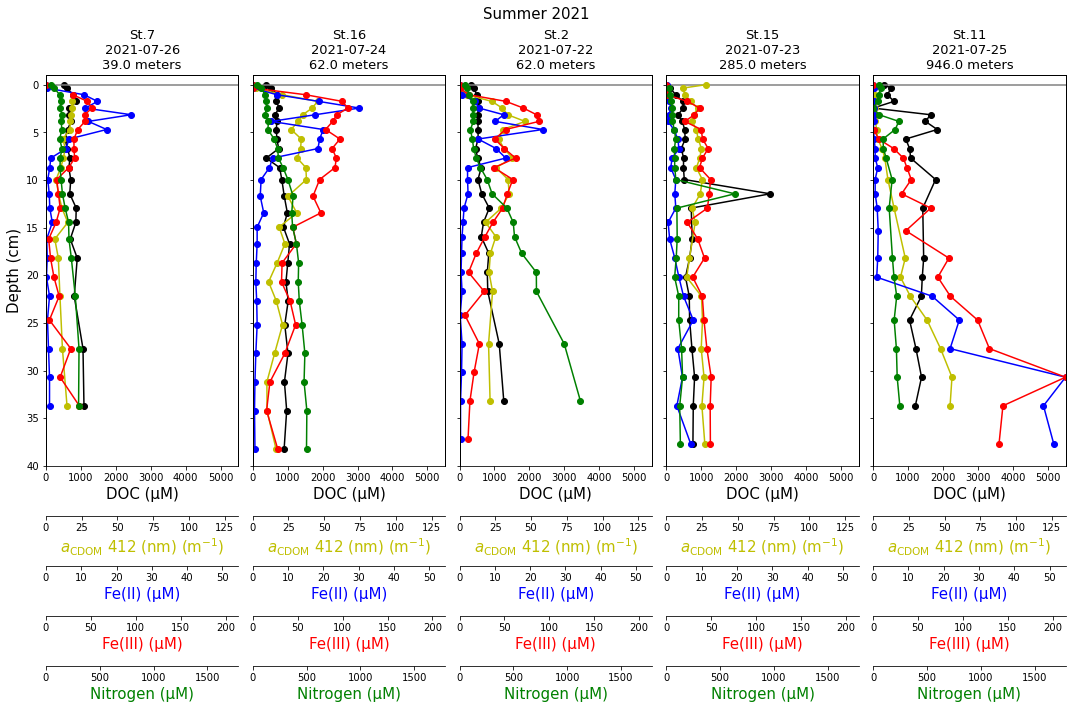

In [52]:
station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 10))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_pw[(ds_doc_pw['Location'] == station_val)]
    iron_data = ds_iron_pw[(ds_iron_pw['Location'] == station_val)]
    cdom_data = ds_cdom_pw[(ds_cdom_pw['Station'] == station_val)]
    spectra_data = ds_spectra_pw[(ds_spectra_pw['Station'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #PLOT DOC
    ax.plot(doc_uM, doc_depth, 'o', ls='-', c='black')
    ax.set_xlim(0,df_doc_pw['NPOC_uM'].max())
    ax.set_ylim(40,-1)
    ax.axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    
    #plot lables 
    #Set x-axis label on bottom subplots
    ax.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (cm)', size= 15)
        
    #plot CDOM
    ax2 = ax.twiny()
    ax2.plot(a412, spectra_depth, 'o', ls='-', c='y')
    ax2.set_xlim(0,df_spectra_pw['a_412'].max())
    
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 50))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax.twiny()
    ax3.plot(fe2_uM, fe_depth, 'o', ls='-', c='b')
    ax3.set_xlim(0,ds_iron_pw['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 100))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    ax4 = ax.twiny()
    ax4.plot(fe3_uM, fe_depth, 'o', ls='-', c='r')
    ax4.set_xlim(0,ds_iron_pw['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 150))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    ax5 = ax.twiny()
    ax5.plot(tn_uM, doc_depth, 'o', ls='-', c='g')
    ax5.set_xlim(0,df_doc_pw['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 200))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
        
    
    #turn off other axis
    if j != 0:
        ax.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
        ax4.set_yticklabels([])
        ax5.set_yticklabels([])
        
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
            
# add a global title to the figure
fig.suptitle("Summer 2021", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Pore_water_profiles/GOM2021.png")

# show the plot
plt.show()

In [53]:
#Fall 2021

#data set that is just one camp at a time 
select = "GOM21FA"

#get the selection data subsets 
ds_cdom_pw = df_cdom_pw[df_cdom_pw['Trip'] == select]
ds_spectra_pw = df_spectra_pw[df_spectra_pw['Trip'] == select]
ds_iron_pw = df_iron_pw[df_iron_pw['Campaign'] == select]
ds_doc_pw = df_doc_pw[df_doc_pw['Campaign'] == select]

#get the columns 
col_order = ds_cdom_pw['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#get the CTD Oxogen and Salinity values 
ds_nisk = df_nisk[(df_nisk['camp'] == select)]
nisk_data = ds_nisk[ds_nisk['station'].isin(col_order)]
grouped_data = ds_nisk[ds_nisk['station'].isin(col_order)].groupby('station')
sal00_values = {}
oxy_values = {}
row_values = {}

#group them
for station, group in grouped_data:
    highest_row = group.loc[group['nbf'] == group['nbf'].max()]
    sal00_values[station] = highest_row['sal00'].iloc[0]
    oxy_values[station] = highest_row['sbeox0Mg/L'].iloc[0]

# create a new column with "NA" values for all rows
df_locs['sal'] = np.nan
df_locs['oxy'] = np.nan

# create a boolean mask to select only the rows where the Station is in sal00_values
mask = df_locs['Station'].isin(sal00_values.keys())
mask = df_locs['Station'].isin(oxy_values.keys())

# use the mask to select only those rows and add the sal00 values to the new column
df_locs.loc[mask, 'sal'] = [sal00_values[station] for station in df_locs.loc[mask, 'Station']]
df_locs.loc[mask, 'oxy'] = [oxy_values[station] for station in df_locs.loc[mask, 'Station']]

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_sal = df_locs["sal"].tolist()
col_sal = [round(x, 1) for x in col_sal]
col_oxy = df_locs["oxy"].tolist()
col_oxy = [round(x, 1) for x in col_oxy]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Station        Date  Water_depth        sal       oxy
7    St.5B  2021-10-25         12.3  29.256237  6.685394
10   St.MK  2021-10-27         16.5  26.572018  7.019276
6     St.4  2021-10-27         16.8  29.550911  6.612116
8     St.7  2021-10-31         39.2  31.361000  6.795839
4    St.16  2021-11-08         58.2  25.548048  7.479117
5     St.2  2021-11-02         62.5  33.856235  6.678220
9     St.9  2021-11-01         80.6  30.071376  6.865876
3    St.15  2021-11-02        264.9  32.471385  6.786733
2    St.13  2021-11-07        464.0  33.856235  6.678220
0    St.11  2021-11-10        934.0  36.351178  6.348355
1    St.12  2021-11-09        970.0  35.604065  6.556814

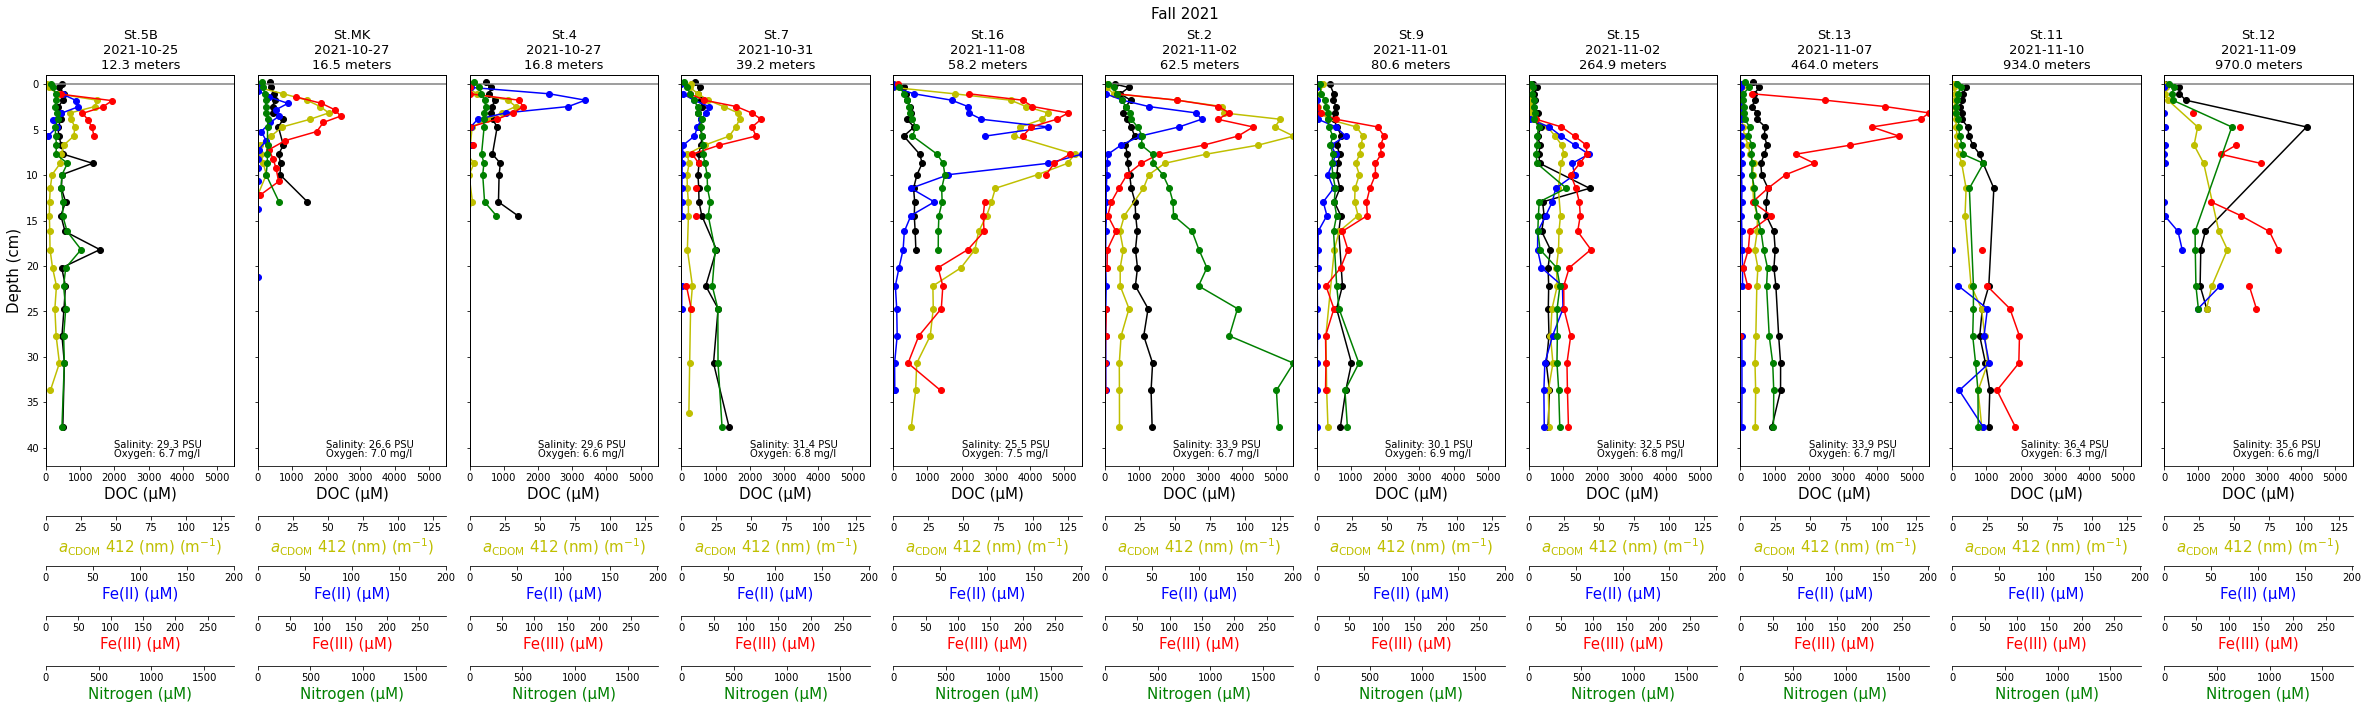

In [54]:
station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 10))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_pw[(ds_doc_pw['Location'] == station_val)]
    iron_data = ds_iron_pw[(ds_iron_pw['Location'] == station_val)]
    cdom_data = ds_cdom_pw[(ds_cdom_pw['Station'] == station_val)]
    spectra_data = ds_spectra_pw[(ds_spectra_pw['Station'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #PLOT DOC
    ax.plot(doc_uM, doc_depth, 'o', ls='-', c='black')
    ax.set_xlim(0,df_doc_pw['NPOC_uM'].max())
    ax.set_ylim(42,-1)
    ax.axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    
    #plot lables 
    #Set x-axis label on bottom subplots
    ax.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (cm)', size= 15)
        
    #plot CDOM
    ax2 = ax.twiny()
    ax2.plot(a412, spectra_depth, 'o', ls='-', c='y')
    ax2.set_xlim(0,df_spectra_pw['a_412'].max())
    
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 50))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax.twiny()
    ax3.plot(fe2_uM, fe_depth, 'o', ls='-', c='b')
    ax3.set_xlim(0,ds_iron_pw['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 100))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    ax4 = ax.twiny()
    ax4.plot(fe3_uM, fe_depth, 'o', ls='-', c='r')
    ax4.set_xlim(0,ds_iron_pw['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 150))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    ax5 = ax.twiny()
    ax5.plot(tn_uM, doc_depth, 'o', ls='-', c='g')
    ax5.set_xlim(0,df_doc_pw['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 200))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
        
    
    #turn off other axis
    if j != 0:
        ax.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
        ax4.set_yticklabels([])
        ax5.set_yticklabels([])
        
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    ax.text(2000, 40, f'Salinity: {col_sal[j]} PSU')
    ax.text(2000, 41, f'Oxygen: {col_oxy[j]} mg/l')
            
# add a global title to the figure
fig.suptitle("Fall 2021", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Pore_water_profiles/GOM21FA.png")

# show the plot
plt.show()

In [55]:
#Spring 2022

#data set that is just one camp at a time 
select = "GOM22SP"

#get the selection data subsets 
ds_cdom_pw = df_cdom_pw[df_cdom_pw['Trip'] == select]
ds_spectra_pw = df_spectra_pw[df_spectra_pw['Trip'] == select]
ds_iron_pw = df_iron_pw[df_iron_pw['Campaign'] == select]
ds_doc_pw = df_doc_pw[df_doc_pw['Campaign'] == select]

#get the columns 
col_order = ds_cdom_pw['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_spectra_wc[df_spectra_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#get the CTD Oxogen and Salinity values 
ds_nisk = df_nisk[(df_nisk['camp'] == select)]
nisk_data = ds_nisk[ds_nisk['station'].isin(col_order)]
grouped_data = ds_nisk[ds_nisk['station'].isin(col_order)].groupby('station')
sal00_values = {}
oxy_values = {}
row_values = {}

#group them
for station, group in grouped_data:
    highest_row = group.loc[group['nbf'] == group['nbf'].max()]
    sal00_values[station] = highest_row['sal00'].iloc[0]
    oxy_values[station] = highest_row['sbeox0Mg/L'].iloc[0]

# create a new column with "NA" values for all rows
df_locs['sal'] = np.nan
df_locs['oxy'] = np.nan

# create a boolean mask to select only the rows where the Station is in sal00_values
mask = df_locs['Station'].isin(sal00_values.keys())
mask = df_locs['Station'].isin(oxy_values.keys())

# use the mask to select only those rows and add the sal00 values to the new column
df_locs.loc[mask, 'sal'] = [sal00_values[station] for station in df_locs.loc[mask, 'Station']]
df_locs.loc[mask, 'oxy'] = [oxy_values[station] for station in df_locs.loc[mask, 'Station']]

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_sal = df_locs["sal"].tolist()
col_sal = [round(x, 1) for x in col_sal]
col_oxy = df_locs["oxy"].tolist()
col_oxy = [round(x, 1) for x in col_oxy]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Station        Date  Water_depth        sal        oxy
6   St.5B  2022-04-14         14.4  30.750671   6.689108
5    St.4  2022-04-20         17.5  29.026941   7.723549
8   St.MK  2022-04-19         17.5  29.813576   8.057314
3   St.16  2022-04-11         60.0  27.189133   6.801757
4    St.2  2022-04-17         65.0  17.195098  11.105049
7    St.9  2022-04-16         82.5  23.180618   8.117186
1   St.14  2022-04-09         91.0  26.841422   9.410635
2   St.15  2022-04-16        267.0        NaN        NaN
0   St.13  2022-04-18        577.0  31.640655   7.089684

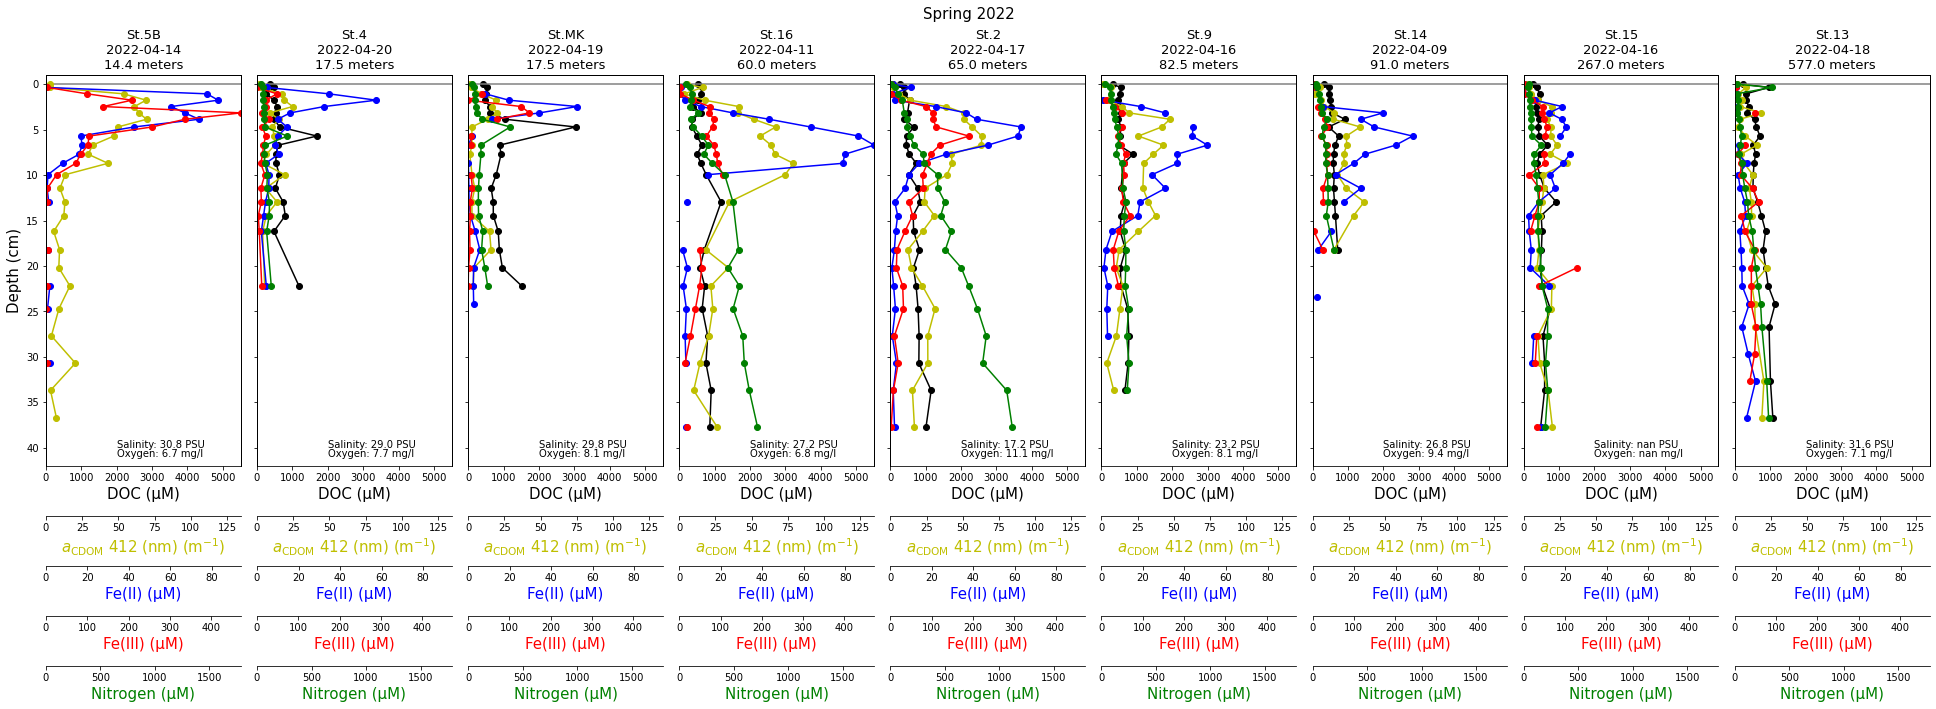

In [56]:
station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 10))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_pw[(ds_doc_pw['Location'] == station_val)]
    iron_data = ds_iron_pw[(ds_iron_pw['Location'] == station_val)]
    cdom_data = ds_cdom_pw[(ds_cdom_pw['Station'] == station_val)]
    spectra_data = ds_spectra_pw[(ds_spectra_pw['Station'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #PLOT DOC
    ax.plot(doc_uM, doc_depth, 'o', ls='-', c='black')
    ax.set_xlim(0,df_doc_pw['NPOC_uM'].max()) 
    ax.set_ylim(42,-1)
    ax.axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    
    #plot lables 
    #Set x-axis label on bottom subplots
    ax.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (cm)', size= 15)
        
    #plot CDOM
    ax2 = ax.twiny()
    ax2.plot(a412, spectra_depth, 'o', ls='-', c='y')
    ax2.set_xlim(0,df_spectra_pw['a_412'].max())
    
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 50))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax.twiny()
    ax3.plot(fe2_uM, fe_depth, 'o', ls='-', c='b')
    ax3.set_xlim(0,ds_iron_pw['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 100))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    ax4 = ax.twiny()
    ax4.plot(fe3_uM, fe_depth, 'o', ls='-', c='r')
    ax4.set_xlim(0,ds_iron_pw['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 150))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    ax5 = ax.twiny()
    ax5.plot(tn_uM, doc_depth, 'o', ls='-', c='g')
    ax5.set_xlim(0,df_doc_pw['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 200))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
        
    
    #turn off other axis
    if j != 0:
        ax.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
        ax4.set_yticklabels([])
        ax5.set_yticklabels([])
        
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    ax.text(2000, 40, f'Salinity: {col_sal[j]} PSU')
    ax.text(2000, 41, f'Oxygen: {col_oxy[j]} mg/l')
            
# add a global title to the figure
fig.suptitle("Spring 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Pore_water_profiles/GOM22SP.png")

# show the plot
plt.show()

In [57]:
#Summer 2022

#data set that is just one camp at a time 
select = "GOM22SU"

#get the selection data subsets 
ds_cdom_pw = df_cdom_pw[df_cdom_pw['Trip'] == select]
ds_spectra_pw = df_spectra_pw[df_spectra_pw['Trip'] == select]
ds_iron_pw = df_iron_pw[df_iron_pw['Campaign'] == select]
ds_doc_pw = df_doc_pw[df_doc_pw['Campaign'] == select]

#get the columns 
col_order = ds_cdom_pw['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#get the CTD Oxogen and Salinity values 
ds_nisk = df_nisk[(df_nisk['camp'] == select)]
nisk_data = ds_nisk[ds_nisk['station'].isin(col_order)]
grouped_data = ds_nisk[ds_nisk['station'].isin(col_order)].groupby('station')
sal00_values = {}
oxy_values = {}
row_values = {}

#group them
for station, group in grouped_data:
    highest_row = group.loc[group['nbf'] == group['nbf'].max()]
    sal00_values[station] = highest_row['sal00'].iloc[0]
    oxy_values[station] = highest_row['sbeox0Mg/L'].iloc[0]

# create a new column with "NA" values for all rows
df_locs['sal'] = np.nan
df_locs['oxy'] = np.nan

# create a boolean mask to select only the rows where the Station is in sal00_values
mask = df_locs['Station'].isin(sal00_values.keys())
mask = df_locs['Station'].isin(oxy_values.keys())

# use the mask to select only those rows and add the sal00 values to the new column
df_locs.loc[mask, 'sal'] = [sal00_values[station] for station in df_locs.loc[mask, 'Station']]
df_locs.loc[mask, 'oxy'] = [oxy_values[station] for station in df_locs.loc[mask, 'Station']]

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_sal = df_locs["sal"].tolist()
col_sal = [round(x, 1) for x in col_sal]
col_oxy = df_locs["oxy"].tolist()
col_oxy = [round(x, 1) for x in col_oxy]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Station        Date  Water_depth        sal       oxy
7    St.5B  2022-07-10         12.2  21.277180  6.764561
6     St.4  2022-07-10         16.9  24.535378  6.223847
10   St.MK  2022-07-23         17.5  19.954716  5.567649
8     St.7  2022-07-12         40.7  25.524159  5.953590
5    St.16  2022-07-20         57.2  22.220463  6.009673
9     St.9  2022-07-17         80.2  24.440553  6.485220
3    St.14  2022-07-16         88.6  24.160886  6.484204
4    St.15  2022-07-15        268.0  24.743210  6.666246
2    St.13  2022-07-18        490.0  22.919533  7.084496
0    St.11  2022-07-22        947.0  31.587081  5.521906
1    St.12  2022-07-21       1003.0  22.740878  6.627016

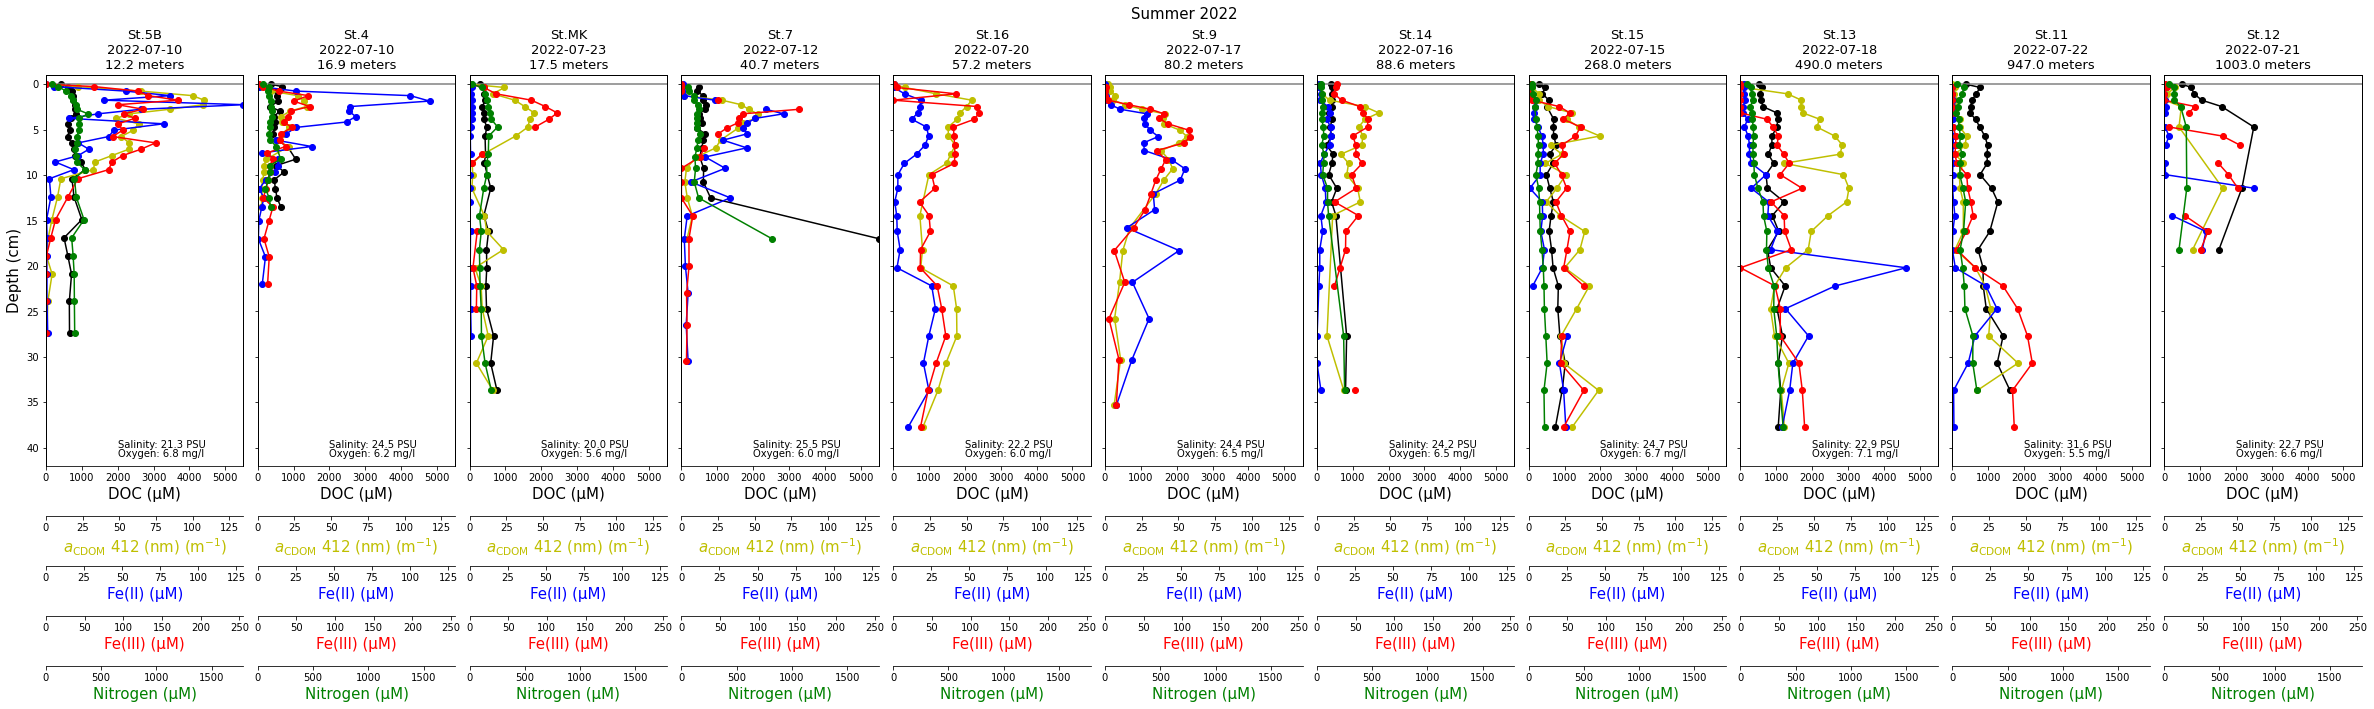

In [58]:
station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 10))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_pw[(ds_doc_pw['Location'] == station_val)]
    iron_data = ds_iron_pw[(ds_iron_pw['Location'] == station_val)]
    cdom_data = ds_cdom_pw[(ds_cdom_pw['Station'] == station_val)]
    spectra_data = ds_spectra_pw[(ds_spectra_pw['Station'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #PLOT DOC
    ax.plot(doc_uM, doc_depth, 'o', ls='-', c='black')
    ax.set_xlim(0,df_doc_pw['NPOC_uM'].max())
    ax.set_ylim(42,-1)
    ax.axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    
    #plot lables 
    #Set x-axis label on bottom subplots
    ax.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (cm)', size= 15)
        
    #plot CDOM
    ax2 = ax.twiny()
    ax2.plot(a412, spectra_depth, 'o', ls='-', c='y')
    ax2.set_xlim(0,df_spectra_pw['a_412'].max())
    
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 50))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax.twiny()
    ax3.plot(fe2_uM, fe_depth, 'o', ls='-', c='b')
    ax3.set_xlim(0,ds_iron_pw['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 100))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    ax4 = ax.twiny()
    ax4.plot(fe3_uM, fe_depth, 'o', ls='-', c='r')
    ax4.set_xlim(0,ds_iron_pw['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 150))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    ax5 = ax.twiny()
    ax5.plot(tn_uM, doc_depth, 'o', ls='-', c='g')
    ax5.set_xlim(0,df_doc_pw['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 200))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
        
    
    #turn off other axis
    if j != 0:
        ax.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
        ax4.set_yticklabels([])
        ax5.set_yticklabels([])
        
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    ax.text(2000, 40, f'Salinity: {col_sal[j]} PSU')
    ax.text(2000, 41, f'Oxygen: {col_oxy[j]} mg/l')
            
# add a global title to the figure
fig.suptitle("Summer 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Pore_water_profiles/GOM22SU.png")

# show the plot
plt.show()

# PART 7: Water Colum figures  

This part make wc figures 

Here we see each paramiter profile 

Each figure is for each campain 

Here we combind the CTD data and the Nisken data to make figures 

all the figures auto save

In [59]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
import xarray as xr
import math
from pandas import Series
import matplotlib.cm as cm
import cmocean
import cmocean.cm as cmo
import seaborn as sns
import matplotlib.colors as colors

In [60]:
#get ctd files 
files = glob.glob('../../../Data_Thesis/CTD/DOWNCAST_PROFILE/DOWNCAST_RENAME/*.csv') 

#make vars 
stations = ['St.11', 'St.12', 'St.13', 'St.14-2', 'St.14', 'St.16-2',
            'St.16', 'St.2', 'St.4', 'St.6', 'St.7',
            'St.9', 'St.MK-2', 'St.MK', 'St.15', 'St.5b']
camps = ['GOM21FA', 'GOM22SP', 'GOM22SU']

select = camps[0] #0 to 2
selectstn = stations[0] #0 to 15

#pick out the vars you need
df1 = pd.read_csv(files[0])
cols_to_select = df1.columns.tolist()

#make the data frame 

frames = []

for f in files: 
    df = pd.read_csv(f)
    
    ID = f.split("\\")[1]
    ID = ID[:-4].split("_")
    
    camp = ID[1]
    station = ID[2]
    sample_id = ID[3]
    date = ID[4]
    
    maxd = df['Pressure [dbar]'].max()
    lat = df['latitude'].mean()
    lon = df['longitude'].mean()
    
    df_new = df.loc[:, cols_to_select]
    
    df_new['camp'] = camp
    df_new['station'] = station
    df_new['sample_id'] = sample_id
    df_new['date'] = date
    df_new['maxd'] = maxd
    df_new['lat'] = lat
    df_new['lon'] = lon
    
    frames.append(df_new)
    
ds = pd.concat(frames, axis=0)

# get the unique values for each group
ds['wetCDOM_vols'] = (ds['wetCDOM']/126)+0.015
ds['turbWETbb0_vols'] = (ds['turbWETbb0']/3)+0.0851
ds['flECO-AFL_vols'] = (ds['flECO-AFL']/26)+0.025

ds['turbWETbb0_recal'] = (ds['turbWETbb0_vols']-0.0851)*0.00623
ds['wetCDOM_recal_low'] = (ds['wetCDOM_vols']-0.067)*32
ds['flECO-AFL_recal_low'] = (ds['flECO-AFL_vols']-0.07)*6

ds['wetCDOM_recal_med'] = (ds['wetCDOM_vols']-0.033)*63
ds['flECO-AFL_recal_med'] = (ds['flECO-AFL_vols']-0.04)*13

ds_copy = ds['wetCDOM'].copy()
ds_copy.loc[ds_copy < -1] = np.nan
ds_copy.loc[ds_copy > 125] = np.nan
ds = pd.merge(ds, ds_copy, left_index=True, right_index=True, how='outer')
ds = ds.rename(columns={'wetCDOM_x': 'wetCDOM', 'wetCDOM_y': 'wetCDOM_clean'})

ds['date_time'] = pd.to_datetime(ds['date'])
ds['dates'] = ds['date_time'].dt.date

# get the unique values for each group
station_vals = ds['station'].unique()
camp_vals = ds['camp'].unique()

In [61]:
#Summer 2021

#data set that is just one camp at a time 
select = "GOM2021"

#get the selection data subsets 
ds_cdom_wc = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_spectra_wc = df_spectra_wc[df_spectra_wc['Trip'] == select]
ds_iron_wc = df_iron_wc[df_iron_wc['Campaign'] == select]
ds_doc_wc = df_doc_wc[df_doc_wc['Campaign'] == select]

#get the columns 
col_order = ds_cdom_wc['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Station        Date  Water_depth
6    St.5B  2021-07-16         12.6
10   St.ML  2021-07-27         15.0
5     St.4  2021-07-17         16.4
9    St.MK  2021-07-15         16.7
7     St.7  2021-07-26         39.0
3    St.16  2021-07-24         62.0
4     St.2  2021-07-22         62.0
8     St.9  2021-07-20         78.0
2    St.15  2021-07-23        285.0
1    St.13  2021-07-21        328.0
0    St.11  2021-07-25        946.0

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 10))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #PLOT DOC
    ax.scatter(doc_uM, doc_depth, c='black', s = 75)
    ax.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax.set_ylim(col_maxd[j]*1.01,0)
    
    #plot lables 
    #Set x-axis label on bottom subplot
    ax.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
        
    #plot CDOM
    ax2 = ax.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = 75)
    ax2.set_xlim(0,1.1)
    
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 50))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = 75)
    ax3.set_xlim(0,.1)
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 100))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    ax4 = ax.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = 75)
    ax4.set_xlim(0,.4)
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 150))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    ax5 = ax.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = 75)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 200))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
        
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
            
# add a global title to the figure
fig.suptitle("Summer 2021", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/GOM2021.png")

# show the plot
plt.show()

In [62]:
#Fall 2021

#data set that is just one camp at a time 
select = "GOM21FA"

#get the ctd data 
ds_ctd = ds[ds['camp'] == select]
print(ds_ctd.columns)

#get the selection data subsets 
ds_cdom_wc = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_spectra_wc = df_spectra_wc[df_spectra_wc['Trip'] == select]
ds_iron_wc = df_iron_wc[df_iron_wc['Campaign'] == select]
ds_doc_wc = df_doc_wc[df_doc_wc['Campaign'] == select]

#get the columns 
col_order = ds_cdom_wc['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Index(['Pressure [dbar]', 'nbf', 'c0S/m', 'density00', 'wetCDOM', 'flECO-AFL',
       'latitude', 'longitude', 'sbeox0Mg/L', 'par', 'sal00', 't090C', 't068C',
       'timeM', 'turbWETbb0', 'flag', 'camp', 'station', 'sample_id', 'date',
       'maxd', 'lat', 'lon', 'wetCDOM_vols', 'turbWETbb0_vols',
       'flECO-AFL_vols', 'turbWETbb0_recal', 'wetCDOM_recal_low',
       'flECO-AFL_recal_low', 'wetCDOM_recal_med', 'flECO-AFL_recal_med',
       'wetCDOM_clean', 'date_time', 'dates'],
      dtype='object')


Station        Date  Water_depth
9     St.5B  2021-10-25         12.3
14  St.MK-2  2021-10-30         13.3
10     St.6  2021-10-26         13.6
6   St.16-2  2021-11-12         16.1
13    St.MK  2021-10-27         16.5
8      St.4  2021-10-27         16.8
11     St.7  2021-10-31         39.2
5     St.16  2021-11-08         58.2
7      St.2  2021-11-02         62.5
12     St.9  2021-11-01         80.6
3   St.14.5  2021-11-01        105.0
4     St.15  2021-11-02        264.9
2     St.13  2021-11-07        464.0
0     St.11  2021-11-10        934.0
1     St.12  2021-11-09        970.0

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD CDOM DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 2)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.plot(flECO, pressure, c = "#8FBC8F", linewidth=3.0)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.plot(BB, pressure, c = "skyblue", linewidth=3.0)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 150))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 200))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 250))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 300))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 350))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
            
# add a global title to the figure
fig.suptitle("Fall 2021", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_GOM21FA.png")

# show the plot
plt.show()

#Temp and sal info with the WC Data

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD Density DATA 
    density00 = data['density00'] #X var 
    density00 = np.asarray(density00, dtype=float).ravel()
    
    #CTD Salinity DATA 
    sal00 = data['sal00'] #X var 
    sal00 = np.asarray(sal00, dtype=float).ravel()
    
    #CTD oxygen DATA
    sbeox = data['sbeox0Mg/L'] #X var 
    sbeox = np.asarray(sbeox, dtype=float).ravel()
    
    #CTD temp DATA
    t090C = data['t090C'] #X var 
    t090C = np.asarray(t090C, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD density
    ax.scatter(density00, pressure, c='green', s=1)
    ax.set_xlim(ds_ctd['density00'].mean()-ds_ctd['density00'].std()*2.5,
                ds_ctd['density00'].mean()+ds_ctd['density00'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('Density kg/m\u00B3', size = 15, c='green')
    
    #CTD Sal
    ax7 = ax.twiny()
    ax7.plot(sal00, pressure, c = "black")
    ax7.set_xlim(ds_ctd['sal00'].min(), ds_ctd['sal00'].max())
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Salinity [PSU]', size = 15, c= 'black')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD temp
    ax8 = ax.twiny()
    ax8.plot(t090C, pressure, c = "blue")
    ax8.set_xlim(ds_ctd['t090C'].min(), ds_ctd['t090C'].max())
    #Set x-axis label on bottom subplots
    ax8.set_xlabel('Temperature (°C)', size = 15, c='blue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #CTD oxogen
    ax9 = ax.twiny()
    ax9.plot(sbeox, pressure, c = "red")
    ax9.set_xlim(0, ds_ctd['sbeox0Mg/L'].max())
    #Set x-axis label on bottom subplots
    ax9.set_xlabel('Oxygen [mg/l]', size = 15, c='red')
    ax9.xaxis.set_ticks_position('bottom')
    ax9.xaxis.set_label_position('bottom')
    ax9.spines['bottom'].set_position(('outward', 150))
    
    #BARS 
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density: 
    smoothed_density_prime2 = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_density_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_density_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_density_prime2)
    std = np.std(smoothed_density_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2*std)
    min_mask = np.array(min_values) < (mean - 2*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_density_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_density_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Den_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for density inversions pos
    for p in Den_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='green')
        
    # temp:
    smoothed_temp_prime2 = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_temp_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_temp_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_temp_prime2)
    std = np.std(smoothed_temp_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2.5*std)
    min_mask = np.array(min_values) < (mean - 2.5*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Temp_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for temp inversions pos
    for p in Temp_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='blue')
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 200))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 250))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 300))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 350))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 400))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
        ax.text(1015,1, "Green: Pycnocline", c='green',)
        ax.text(1015,1.25, "Blue: Thermocline", c='blue')
            
# add a global title to the figure
fig.suptitle("Fall 2021", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/CLAS_GOM21FA.png")

# show the plot
plt.show()

#Infections with CTD OPtics 

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD CDOM DATA 
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 2)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.plot(flECO, pressure, c = "#8FBC8F", linewidth=3.0)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.plot(BB, pressure, c = "skyblue", linewidth=3.0)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #BARS 
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density: 
    smoothed_density_prime2 = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_density_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_density_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_density_prime2)
    std = np.std(smoothed_density_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2*std)
    min_mask = np.array(min_values) < (mean - 2*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_density_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_density_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Den_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for density inversions pos
    for p in Den_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='green')
        
    # temp:
    smoothed_temp_prime2 = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_temp_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_temp_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_temp_prime2)
    std = np.std(smoothed_temp_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2.5*std)
    min_mask = np.array(min_values) < (mean - 2.5*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Temp_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for temp inversions pos
    for p in Temp_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='blue')
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 150))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 200))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 250))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 300))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 350))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
        ax.text(.5,1, "Green: Pycnocline", c='green',)
        ax.text(.5,1.25, "Blue: Thermocline", c='blue')

# add a global title to the figure
fig.suptitle("Fall 2021", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_CLIN_GOM21FA.png")

# show the plot
plt.show()

#Temp and salt inversions with CTD OPtics 

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 16))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD CDOM DATA 
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 1)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.scatter(flECO, pressure, c = "#8FBC8F", s =1)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.scatter(BB, pressure, c = "skyblue", s = 1)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #cut data for figure  
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density diffs: 
    smoothed_density = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(),polyorder=3, mode="nearest")
    density_gradient = np.diff(smoothed_density)
    density_gradient = np.append(density_gradient, np.nan)
        
    # Temp diffs:
    smoothed_temp = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), polyorder=3, mode="nearest")
    temp_gradient = np.diff(smoothed_temp)
    temp_gradient = np.append(temp_gradient, np.nan)
    
    # Define the colors 
    # Create the custom colormap for density 
    colors_list_den = ['#EB8833', '#AF5C17', '#A7520B']  # Example colors
    positions = [0, .5, 1]  # Example positions
    colormap_den = colors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_list_den)))
    norm_den = colors.TwoSlopeNorm(vmax=.0001, vcenter=0, vmin=-.000025)
    
    # Create the custom colormap for temp 
    colors_list_temp = ['#67259D', '#7F43B0', '#9F53DD']  # Example colors
    positions = [0, .5, 1]  # Example positions
    colormap_temp = colors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_list_temp)))
    norm_temp = colors.TwoSlopeNorm(vmin=-.0001, vcenter=0,  vmax=.00001,)
    
    #plot ctd density colored by inversion 
    ax10 = ax.twiny()
    ax10.scatter(density_cut, pressure_cut, c=density_gradient, cmap=colormap_den, norm=norm_den, s = 1) 
    ax10.set_xlim(min(density_cut), max(density_cut))
    ax10.set_xlabel('Density kg/m\u00B3', size = 15, c='#AF5C17')
    ax10.xaxis.set_ticks_position('bottom')
    ax10.xaxis.set_label_position('bottom')
    ax10.spines['bottom'].set_position(('outward', 150))
    
    #plot ctd temp colored by inversion 
    ax11 = ax.twiny()
    ax11.scatter(temp_cut, pressure_cut, c=temp_gradient, cmap=colormap_temp, norm=norm_temp, s = 1) 
    ax11.set_xlim(min(temp_cut), max(temp_cut))
    ax11.set_xlabel('Temperature (°C)', size = 15, c='#67259D')
    ax11.xaxis.set_ticks_position('bottom')
    ax11.xaxis.set_label_position('bottom')
    ax11.spines['bottom'].set_position(('outward', 200))
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 250))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 300))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 350))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 400))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 450))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)

# add a global title to the figure
fig.suptitle("Fall 2021", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_TEMP_DEN_GOM21FA.png")

# show the plot
plt.show()

In [63]:
#Spring 2022

#data set that is just one camp at a time 
select = "GOM22SP"

#get the ctd data 
ds_ctd = ds[ds['camp'] == select]
print(ds_ctd.columns)

#get the selection data subsets 
ds_cdom_wc = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_spectra_wc = df_spectra_wc[df_spectra_wc['Trip'] == select]
ds_iron_wc = df_iron_wc[df_iron_wc['Campaign'] == select]
ds_doc_wc = df_doc_wc[df_doc_wc['Campaign'] == select]

#get the columns 
col_order = ds_spectra_wc['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_spectra_wc[df_spectra_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Index(['Pressure [dbar]', 'nbf', 'c0S/m', 'density00', 'wetCDOM', 'flECO-AFL',
       'latitude', 'longitude', 'sbeox0Mg/L', 'par', 'sal00', 't090C', 't068C',
       'timeM', 'turbWETbb0', 'flag', 'camp', 'station', 'sample_id', 'date',
       'maxd', 'lat', 'lon', 'wetCDOM_vols', 'turbWETbb0_vols',
       'flECO-AFL_vols', 'turbWETbb0_recal', 'wetCDOM_recal_low',
       'flECO-AFL_recal_low', 'wetCDOM_recal_med', 'flECO-AFL_recal_med',
       'wetCDOM_clean', 'date_time', 'dates'],
      dtype='object')


Station        Date  Water_depth
6   St.5B  2022-04-14         14.4
5    St.4  2022-04-20         17.5
9   St.MK  2022-04-19         17.5
7    St.7  2022-04-10         39.7
3   St.16  2022-04-11         60.0
4    St.2  2022-04-17         65.0
8    St.9  2022-04-16         82.5
1   St.14  2022-04-09         91.0
2   St.15  2022-04-16        267.0
0   St.13  2022-04-18        577.0

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD CDOM DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 2)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.plot(flECO, pressure, c = "#8FBC8F", linewidth=3.0)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.plot(BB, pressure, c = "skyblue", linewidth=3.0)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 150))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 200))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 250))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 300))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 350))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
            
# add a global title to the figure
fig.suptitle("Spring 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_GOM22SP.png")

# show the plot
plt.show()

#Temp and sal info with the WC Data

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD Density DATA 
    density00 = data['density00'] #X var 
    density00 = np.asarray(density00, dtype=float).ravel()
    
    #CTD Salinity DATA 
    sal00 = data['sal00'] #X var 
    sal00 = np.asarray(sal00, dtype=float).ravel()
    
    #CTD oxygen DATA
    sbeox = data['sbeox0Mg/L'] #X var 
    sbeox = np.asarray(sbeox, dtype=float).ravel()
    
    #CTD temp DATA
    t090C = data['t090C'] #X var 
    t090C = np.asarray(t090C, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD density
    ax.scatter(density00, pressure, c='green', s=1)
    ax.set_xlim(ds_ctd['density00'].mean()-ds_ctd['density00'].std()*2.5,
                ds_ctd['density00'].mean()+ds_ctd['density00'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('Density kg/m\u00B3', size = 15, c='green')
    
    #CTD Sal
    ax7 = ax.twiny()
    ax7.plot(sal00, pressure, c = "black")
    ax7.set_xlim(ds_ctd['sal00'].min(), ds_ctd['sal00'].max())
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Salinity [PSU]', size = 15, c= 'black')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD temp
    ax8 = ax.twiny()
    ax8.plot(t090C, pressure, c = "blue")
    ax8.set_xlim(ds_ctd['t090C'].min(), ds_ctd['t090C'].max())
    #Set x-axis label on bottom subplots
    ax8.set_xlabel('Temperature (°C)', size = 15, c='blue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #CTD oxogen
    ax9 = ax.twiny()
    ax9.plot(sbeox, pressure, c = "red")
    ax9.set_xlim(0, ds_ctd['sbeox0Mg/L'].max())
    #Set x-axis label on bottom subplots
    ax9.set_xlabel('Oxygen [mg/l]', size = 15, c='red')
    ax9.xaxis.set_ticks_position('bottom')
    ax9.xaxis.set_label_position('bottom')
    ax9.spines['bottom'].set_position(('outward', 150))
    
    #BARS 
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density: 
    smoothed_density_prime2 = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_density_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_density_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_density_prime2)
    std = np.std(smoothed_density_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2*std)
    min_mask = np.array(min_values) < (mean - 2*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_density_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_density_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Den_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for density inversions pos
    for p in Den_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='green')
        
    # temp:
    smoothed_temp_prime2 = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_temp_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_temp_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_temp_prime2)
    std = np.std(smoothed_temp_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2.5*std)
    min_mask = np.array(min_values) < (mean - 2.5*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Temp_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for temp inversions pos
    for p in Temp_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='blue')
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 200))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 250))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 300))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 350))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 400))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
        ax.text(1017,1, "Green: Pycnocline", c='green',)
        ax.text(1017,1.25, "Blue: Thermoclines", c='blue')
            
# add a global title to the figure
fig.suptitle("Spring 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/CLASS_GOM22SP.png")

# show the plot
plt.show()

#Inflections with CTD OPtics 

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD CDOM DATA 
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 2)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.plot(flECO, pressure, c = "#8FBC8F", linewidth=3.0)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.plot(BB, pressure, c = "skyblue", linewidth=3.0)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #BARS 
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density: 
    smoothed_density_prime2 = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_density_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_density_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_density_prime2)
    std = np.std(smoothed_density_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2*std)
    min_mask = np.array(min_values) < (mean - 2*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_density_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_density_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Den_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for density inversions pos
    for p in Den_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='green')
        
    # temp:
    smoothed_temp_prime2 = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_temp_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_temp_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_temp_prime2)
    std = np.std(smoothed_temp_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2.5*std)
    min_mask = np.array(min_values) < (mean - 2.5*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Temp_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for temp inversions pos
    for p in Temp_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='blue')
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 150))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 200))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 250))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 300))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 350))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
        ax.text(.5,1, "Green: Pycnocline", c='green',)
        ax.text(.5,1.25, "Blue: Thermocline", c='blue')
            
# add a global title to the figure
fig.suptitle("Spring 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_CLIN_GOM22SP.png")

# show the plot
plt.show()

#Temp and salt inversions with CTD OPtics 

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 16))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD CDOM DATA 
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 1)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.scatter(flECO, pressure, c = "#8FBC8F", s =1)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.scatter(BB, pressure, c = "skyblue", s = 1)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #cut data for figure  
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density diffs: 
    smoothed_density = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(),polyorder=3, mode="nearest")
    density_gradient = np.diff(smoothed_density)
    density_gradient = np.append(density_gradient, np.nan)
        
    # Temp diffs:
    smoothed_temp = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), polyorder=3, mode="nearest")
    temp_gradient = np.diff(smoothed_temp)
    temp_gradient = np.append(temp_gradient, np.nan)
    
    # Define the colors 
    # Create the custom colormap for density 
    colors_list_den = ['#EB8833', '#AF5C17', '#A7520B']  # Example colors
    positions = [0, .5, 1]  # Example positions
    colormap_den = colors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_list_den)))
    norm_den = colors.TwoSlopeNorm(vmax=.0001, vcenter=0, vmin=-.000025)
    
    # Create the custom colormap for temp 
    colors_list_temp = ['#67259D', '#7F43B0', '#9F53DD']  # Example colors
    positions = [0, .5, 1]  # Example positions
    colormap_temp = colors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_list_temp)))
    norm_temp = colors.TwoSlopeNorm(vmin=-.0001, vcenter=0,  vmax=.00001,)
    
    #plot ctd density colored by inversion 
    ax10 = ax.twiny()
    ax10.scatter(density_cut, pressure_cut, c=density_gradient, cmap=colormap_den, norm=norm_den, s = 1) 
    ax10.set_xlim(min(density_cut), max(density_cut))
    ax10.set_xlabel('Density kg/m\u00B3', size = 15, c='#AF5C17')
    ax10.xaxis.set_ticks_position('bottom')
    ax10.xaxis.set_label_position('bottom')
    ax10.spines['bottom'].set_position(('outward', 150))
    
    #plot ctd temp colored by inversion 
    ax11 = ax.twiny()
    ax11.scatter(temp_cut, pressure_cut, c=temp_gradient, cmap=colormap_temp, norm=norm_temp, s = 1) 
    ax11.set_xlim(min(temp_cut), max(temp_cut))
    ax11.set_xlabel('Temperature (°C)', size = 15, c='#67259D')
    ax11.xaxis.set_ticks_position('bottom')
    ax11.xaxis.set_label_position('bottom')
    ax11.spines['bottom'].set_position(('outward', 200))
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 250))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 300))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 350))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 400))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 450))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)

# add a global title to the figure
fig.suptitle("Spring 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_TEMP_DEN_GOM22SP.png")

# show the plot
plt.show()

In [64]:
#Summer 2022

#data set that is just one camp at a time 
select = "GOM22SU"

#get the ctd data 
ds_ctd = ds[ds['camp'] == select]
print(ds_ctd.columns)

#get the selection data subsets 
ds_cdom_wc = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_spectra_wc = df_spectra_wc[df_spectra_wc['Trip'] == select]
ds_iron_wc = df_iron_wc[df_iron_wc['Campaign'] == select]
ds_doc_wc = df_doc_wc[df_doc_wc['Campaign'] == select]

#get the columns 
col_order = ds_cdom_wc['Station'].unique()

#put the columns in order columns 
ds_wc_depths = df_cdom_wc[df_cdom_wc['Trip'] == select]
ds_wc_depths = ds_wc_depths[ds_wc_depths['Station'].isin(col_order)]

max_depth = ds_wc_depths.groupby(['Station','Date'])['Water_depth'].max().reset_index()

cols = ['Station','Date','Water_depth']
df_locs = pd.DataFrame(max_depth, columns=cols)
df_locs = df_locs.sort_values('Water_depth')

#df_locs
col_order = df_locs["Station"].tolist()
col_date = df_locs["Date"].tolist()
col_maxd = df_locs["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]

sub_num = len(df_locs)-1
width_num = len(df_locs)

df_locs

Index(['Pressure [dbar]', 'nbf', 'c0S/m', 'density00', 'wetCDOM', 'flECO-AFL',
       'latitude', 'longitude', 'sbeox0Mg/L', 'par', 'sal00', 't090C', 't068C',
       'timeM', 'turbWETbb0', 'flag', 'camp', 'station', 'sample_id', 'date',
       'maxd', 'lat', 'lon', 'wetCDOM_vols', 'turbWETbb0_vols',
       'flECO-AFL_vols', 'turbWETbb0_recal', 'wetCDOM_recal_low',
       'flECO-AFL_recal_low', 'wetCDOM_recal_med', 'flECO-AFL_recal_med',
       'wetCDOM_clean', 'date_time', 'dates'],
      dtype='object')


Station        Date  Water_depth
8    St.5B  2022-07-10         12.2
7     St.4  2022-07-10         16.9
11   St.MK  2022-07-23         17.5
9     St.7  2022-07-12         40.7
5    St.16  2022-07-20         57.2
6     St.2  2022-07-19         62.0
10    St.9  2022-07-17         80.2
3    St.14  2022-07-16         88.6
4    St.15  2022-07-15        268.0
2    St.13  2022-07-18        490.0
0    St.11  2022-07-22        947.0
1    St.12  2022-07-21       1003.0

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD CDOM DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 2)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.plot(flECO, pressure, c = "#8FBC8F", linewidth=3.0)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.plot(BB, pressure, c = "skyblue", linewidth=3.0)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 150))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 200))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 250))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 300))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 350))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
            
# add a global title to the figure
fig.suptitle("Summer 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_GOM22SU.png")

# show the plot
plt.show()

#Temp and sal info with the WC Data

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD Density DATA 
    density00 = data['density00'] #X var 
    density00 = np.asarray(density00, dtype=float).ravel()
    
    #CTD Salinity DATA 
    sal00 = data['sal00'] #X var 
    sal00 = np.asarray(sal00, dtype=float).ravel()
    
    #CTD oxygen DATA
    sbeox = data['sbeox0Mg/L'] #X var 
    sbeox = np.asarray(sbeox, dtype=float).ravel()
    
    #CTD temp DATA
    t090C = data['t090C'] #X var 
    t090C = np.asarray(t090C, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD density
    ax.scatter(density00, pressure, c='green', s=1)
    ax.set_xlim(ds_ctd['density00'].mean()-ds_ctd['density00'].std()*2.5,
                ds_ctd['density00'].mean()+ds_ctd['density00'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('Density kg/m\u00B3', size = 15, c='green')
    
    #CTD Sal
    ax7 = ax.twiny()
    ax7.plot(sal00, pressure, c = "black")
    ax7.set_xlim(ds_ctd['sal00'].min(), ds_ctd['sal00'].max())
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Salinity [PSU]', size = 15, c= 'black')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD temp
    ax8 = ax.twiny()
    ax8.plot(t090C, pressure, c = "blue")
    ax8.set_xlim(ds_ctd['t090C'].min(), ds_ctd['t090C'].max())
    #Set x-axis label on bottom subplots
    ax8.set_xlabel('Temperature (°C)', size = 15, c='blue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #CTD oxogen
    ax9 = ax.twiny()
    ax9.plot(sbeox, pressure, c = "red")
    ax9.set_xlim(0, ds_ctd['sbeox0Mg/L'].max())
    #Set x-axis label on bottom subplots
    ax9.set_xlabel('Oxygen [mg/l]', size = 15, c='red')
    ax9.xaxis.set_ticks_position('bottom')
    ax9.xaxis.set_label_position('bottom')
    ax9.spines['bottom'].set_position(('outward', 150))
    
    #BARS 
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density: 
    smoothed_density_prime2 = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_density_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_density_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_density_prime2)
    std = np.std(smoothed_density_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2*std)
    min_mask = np.array(min_values) < (mean - 2*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_density_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_density_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Den_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for density inversions pos
    for p in Den_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='green')
        
    # temp:
    smoothed_temp_prime2 = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_temp_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_temp_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_temp_prime2)
    std = np.std(smoothed_temp_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2.5*std)
    min_mask = np.array(min_values) < (mean - 2.5*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Temp_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for temp inversions pos
    for p in Temp_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='blue')
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 200))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 250))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 300))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 350))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 400))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
        ax.text(1010,1, "Green: Pycnocline", c='green',)
        ax.text(1010,1.25, "Blue: Thermocline", c='blue')
            
# add a global title to the figure
fig.suptitle("Summer 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/CLASS_GOM22SU.png")

# show the plot
plt.show()

#Inflections with CTD OPtics 

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 15))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD CDOM DATA 
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 2)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.plot(flECO, pressure, c = "#8FBC8F", linewidth=3.0)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.plot(BB, pressure, c = "skyblue", linewidth=3.0)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #BARS 
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density: 
    smoothed_density_prime2 = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_density_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_density_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_density_prime2)
    std = np.std(smoothed_density_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2*std)
    min_mask = np.array(min_values) < (mean - 2*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_density_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_density_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Den_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for density inversions pos
    for p in Den_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='green')
        
    # temp:
    smoothed_temp_prime2 = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), 
                                            polyorder=3, mode="nearest", deriv=2)
    
    # Find where the array passes zero 
    sign_change_indices = np.where(np.diff(np.sign(smoothed_temp_prime2)))[0] + 1
    # Split the array into groups based on the zero indices
    groups = np.split(smoothed_temp_prime2, sign_change_indices+1)
    # Get the maximum and minimun values in each group
    max_values = [np.nanmax(np.unique(group)) for group in groups if len(group) > 0]
    min_values = [np.nanmin(np.unique(group)) for group in groups if len(group) > 0]
    # Id mean and std of the smoothed dansity second derivative 
    mean = np.mean(smoothed_temp_prime2)
    std = np.std(smoothed_temp_prime2)
    # create a boolean mask that identifies values in values that meet the condition
    max_mask = np.array(max_values) > (mean + 2.5*std)
    min_mask = np.array(min_values) < (mean - 2.5*std)
    # select the subset of max_values that meet the condition
    top_max_values = np.array(max_values)[max_mask]
    top_min_values = np.array(min_values)[min_mask]
    # Find the indices of the top positive and negative values of the second derivative
    top_pos_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_max_values))[0]
    top_neg_inv_idx = np.where(np.isin(smoothed_temp_prime2, top_min_values))[0]
    #identify the depths 
    pos_inversion_pressure = pressure_cut[top_pos_inv_idx]
    neg_inversion_pressure = pressure_cut[top_neg_inv_idx]
    Temp_all_inversion_pressure = np.concatenate([pos_inversion_pressure, neg_inversion_pressure])
    # plot horizontal lines for temp inversions pos
    for p in Temp_all_inversion_pressure:
        ax.axhline(y=p, linestyle='--', color='blue')
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 150))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 200))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 250))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 300))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 350))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)
        ax.text(.5,1, "Green: Pycnocline", c='green',)
        ax.text(.5,1.25, "Blue: Thermocline", c='blue')
            
# add a global title to the figure
fig.suptitle("Summer 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_CLIN_GOM22SU.png")

# show the plot
plt.show()

#Temp and salt inversions with CTD OPtics 

station_vals = col_order

fig, axs = plt.subplots(nrows=1, ncols=len(station_vals), figsize=(len(station_vals)*3, 16))

for j, station_val in enumerate(station_vals):
    ax = axs[j]
    
    #get data 
    doc_data = ds_doc_wc[(ds_doc_wc['Location'] == station_val)]
    iron_data = ds_iron_wc[(ds_iron_wc['Location'] == station_val)]
    cdom_data = ds_cdom_wc[(ds_cdom_wc['Station'] == station_val)]
    spectra_data = ds_spectra_wc[(ds_spectra_wc['Station'] == station_val)]
    nisk_data = df_nisk[(df_nisk['camp'] == station_val)]
        
    #get vars 
    doc_uM = doc_data['NPOC_uM'] 
    doc_uM = np.asarray(doc_uM, dtype=float).ravel()
    
    tn_uM = doc_data['TN_uM'] 
    tn_uM = np.asarray(tn_uM, dtype=float).ravel()
       
    doc_depth = doc_data['Depth'] #X var 
    doc_depth = np.asarray(doc_depth, dtype=float).ravel()
    
    fe2_uM = iron_data['Fe2_uM'] 
    fe2_uM = np.asarray(fe2_uM, dtype=float).ravel()
    
    fet_uM = iron_data['FeT_uM'] 
    fet_uM = np.asarray(fet_uM, dtype=float).ravel()
    
    fe3_uM = iron_data['Fe3_uM'] 
    fe3_uM = np.asarray(fe3_uM, dtype=float).ravel()
    
    fe_depth = iron_data['Fe2_Depth'] 
    fe_depth = np.asarray(fe_depth, dtype=float).ravel()
    
    a412 = spectra_data['a_412']
    a412 = np.asarray(a412, dtype=float).ravel()
    
    spectra_depth = spectra_data['Sample_depth']
    spectra_depth = np.asarray(spectra_depth, dtype=float).ravel()
    
    #CTD DATA 
    data = ds_ctd[(ds_ctd['station'] == station_val)]
    
    #CTD pressure DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    
    #CTD CDOM DATA 
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    
    #CTD CDOM
    ax.scatter(wetCDOM, pressure, c='grey', s = 1)
    ax.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax.invert_yaxis()
    ax.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    #Set x-axis label on bottom subplots
    ax.set_xlabel('CDOM mg/m\u00B3', size = 15, c='grey')
    
    #CTD FLOR
    ax7 = ax.twiny()
    ax7.scatter(flECO, pressure, c = "#8FBC8F", s =1)
    ax7.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax7.set_xlabel('Fluorescence mg/m\u00B3', size = 15, c= '#8FBC8F')
    ax7.xaxis.set_ticks_position('bottom')
    ax7.xaxis.set_label_position('bottom')
    ax7.spines['bottom'].set_position(('outward', 50))
    
    #CTD Backscatter
    ax8 = ax.twiny()
    ax8.scatter(BB, pressure, c = "skyblue", s = 1)
    ax8.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
    #Set x-axis label on bottom subplots
    ax8.set_xlabel(r'Backscatter' '\n' r'$\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = 10, c='skyblue')
    ax8.xaxis.set_ticks_position('bottom')
    ax8.xaxis.set_label_position('bottom')
    ax8.spines['bottom'].set_position(('outward', 100))
    
    #cut data for figure  
    #get the short data set 
    data_cut = data[data['Pressure [dbar]'] >= 3]
    data_cut = data_cut[data_cut['Pressure [dbar]'] <= data_cut['Pressure [dbar]'].max()-2]
    
    #pressure from cut values 
    pressure_cut = data_cut['Pressure [dbar]'] #X var 
    pressure_cut = np.asarray(pressure_cut, dtype=float).ravel()
    
    #density from cut values 
    density_cut = data_cut['density00'] #X var 
    density_cut = np.asarray(density_cut, dtype=float).ravel()
    
    #temp from cut values
    temp_cut = data_cut['t090C'] #X var 
    temp_cut = np.asarray(temp_cut, dtype=float).ravel()
    
    # Density diffs: 
    smoothed_density = savgol_filter(density_cut, window_length=85*data['Pressure [dbar]'].max(),polyorder=3, mode="nearest")
    density_gradient = np.diff(smoothed_density)
    density_gradient = np.append(density_gradient, np.nan)
        
    # Temp diffs:
    smoothed_temp = savgol_filter(temp_cut, window_length=85*data['Pressure [dbar]'].max(), polyorder=3, mode="nearest")
    temp_gradient = np.diff(smoothed_temp)
    temp_gradient = np.append(temp_gradient, np.nan)
    
    # Define the colors 
    # Create the custom colormap for density 
    colors_list_den = ['#EB8833', '#AF5C17', '#A7520B']  # Example colors
    positions = [0, .5, 1]  # Example positions
    colormap_den = colors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_list_den)))
    norm_den = colors.TwoSlopeNorm(vmax=.0001, vcenter=0, vmin=-.000025)
    
    # Create the custom colormap for temp 
    colors_list_temp = ['#67259D', '#7F43B0', '#9F53DD']  # Example colors
    positions = [0, .5, 1]  # Example positions
    colormap_temp = colors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors_list_temp)))
    norm_temp = colors.TwoSlopeNorm(vmin=-.0001, vcenter=0,  vmax=.00001,)
    
    #plot ctd density colored by inversion 
    ax10 = ax.twiny()
    ax10.scatter(density_cut, pressure_cut, c=density_gradient, cmap=colormap_den, norm=norm_den, s = 1) 
    ax10.set_xlim(min(density_cut), max(density_cut))
    ax10.set_xlabel('Density kg/m\u00B3', size = 15, c='#AF5C17')
    ax10.xaxis.set_ticks_position('bottom')
    ax10.xaxis.set_label_position('bottom')
    ax10.spines['bottom'].set_position(('outward', 150))
    
    #plot ctd temp colored by inversion 
    ax11 = ax.twiny()
    ax11.scatter(temp_cut, pressure_cut, c=temp_gradient, cmap=colormap_temp, norm=norm_temp, s = 1) 
    ax11.set_xlim(min(temp_cut), max(temp_cut))
    ax11.set_xlabel('Temperature (°C)', size = 15, c='#67259D')
    ax11.xaxis.set_ticks_position('bottom')
    ax11.xaxis.set_label_position('bottom')
    ax11.spines['bottom'].set_position(('outward', 200))
    
    #PLOT NISKEN DATA 
    #PLOT DOC
    ax1 = ax.twiny()
    ax1.scatter(doc_uM, doc_depth, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax1.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax1.set_ylim(col_maxd[j]*1.01,0)
    #Set x-axis label on bottom subplot
    ax1.set_xlabel('DOC (\u03BCM)', size = 15, c='black')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 250))
        
    #plot CDOM
    ax2 = ax1.twiny()
    ax2.scatter(a412, spectra_depth, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax2.set_xlim(0,1.1)
    #Set x-axis label on bottom subplots
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 300))
    ax2.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= 15, c='y')
    
    #plot iron 2 
    ax3 = ax1.twiny()
    ax3.scatter(fe2_uM, fe_depth, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax3.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 350))
    ax3.set_xlabel('Fe(II) (\u03BCM)', size= 15, c='b')
        
    #plot iron 3 
    ax4 = ax1.twiny()
    ax4.scatter(fe3_uM, fe_depth, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax4.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 400))
    ax4.set_xlabel('Fe(III) (\u03BCM)', size= 15, c='r')
    
    #plot nitrogen  
    ax5 = ax1.twiny()
    ax5.scatter(tn_uM, doc_depth, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax5.set_xlim(0,df_doc_wc['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 450))
    ax5.set_xlabel('Nitrogen (\u03BCM)', size= 15, c='g')
    
    #set the titels 
    ax.set_title(f'{station_val}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    
    #Set y-axis label on bottom subplots
    if j == 0:
        ax.set_ylabel('Depth (M)', size= 15)

# add a global title to the figure
fig.suptitle("Summer 2022", size = 15)
fig.set_facecolor('w')
plt.tight_layout()

#save plot 
plt.savefig("../../../Data_Thesis/FIGS/Water_column_profiles/OPT_TEMP_DEN_GOM22SU.png")

# show the plot
plt.show()

# PART 8: Corolation plots  

here we look at all the colorlations 

In [65]:
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

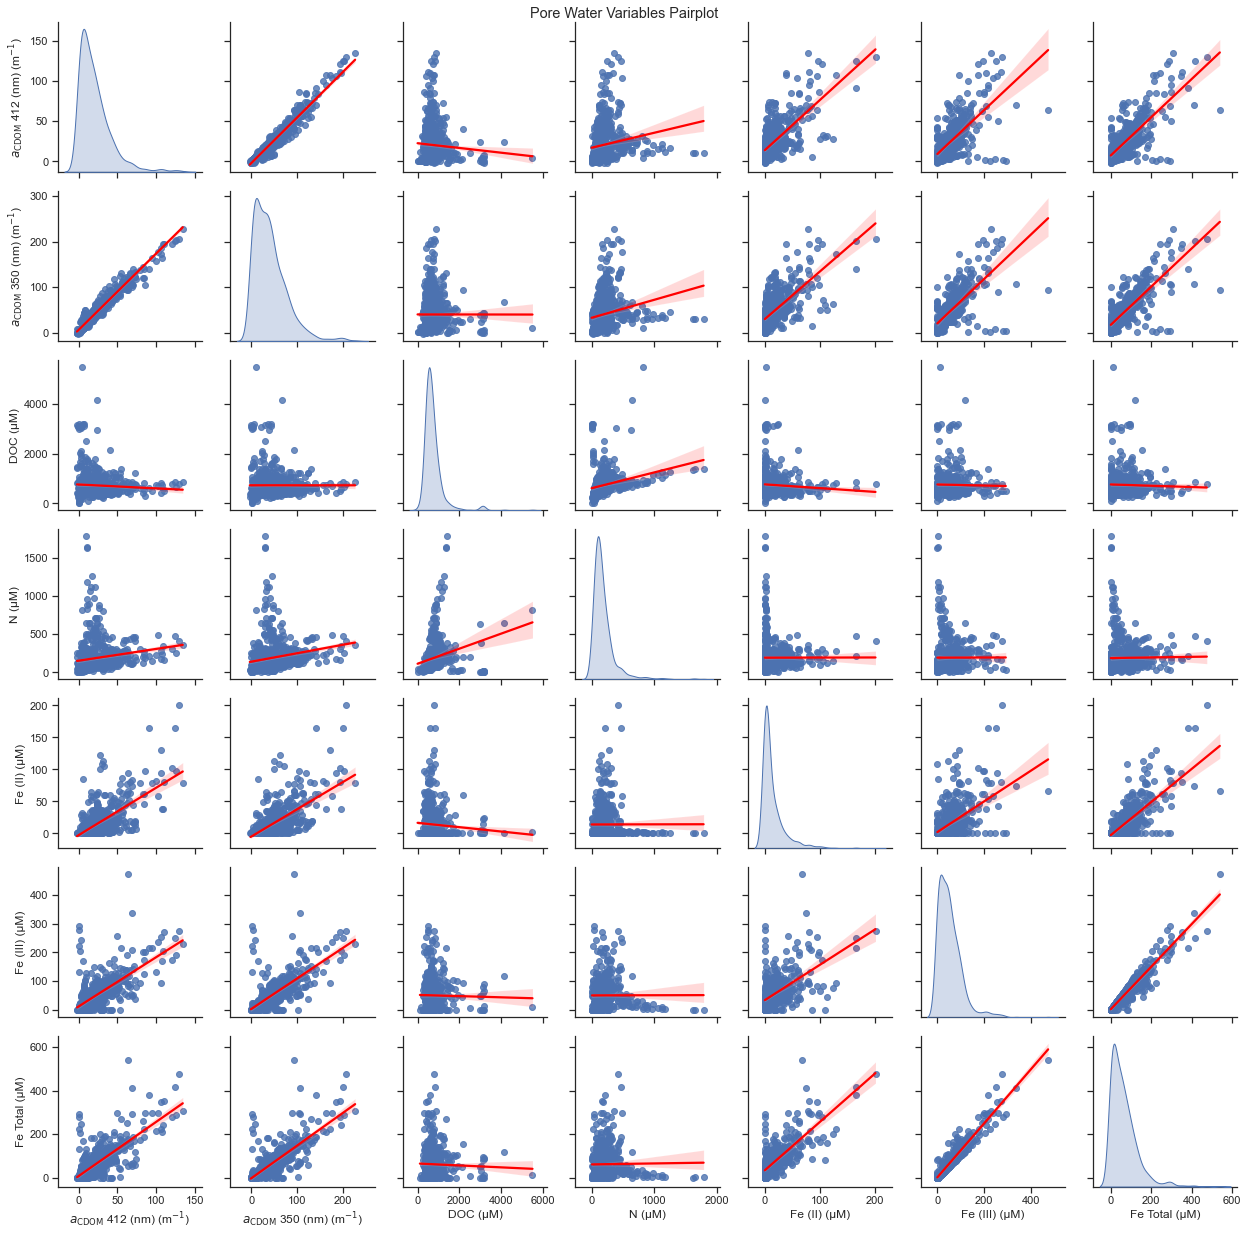

a_412 vs a_350: 0.97
a_412 vs NPOC_uM: -0.07
a_412 vs TN_uM: 0.17
a_412 vs Fe2_uM: 0.68
a_412 vs Fe3_uM: 0.68
a_412 vs FeT_uM: 0.77
a_350 vs NPOC_uM: -0.00
a_350 vs TN_uM: 0.21
a_350 vs Fe2_uM: 0.67
a_350 vs Fe3_uM: 0.72
a_350 vs FeT_uM: 0.79
NPOC_uM vs TN_uM: 0.25
NPOC_uM vs Fe2_uM: -0.07
NPOC_uM vs Fe3_uM: -0.02
NPOC_uM vs FeT_uM: -0.03
TN_uM vs Fe2_uM: 0.00
TN_uM vs Fe3_uM: 0.00
TN_uM vs FeT_uM: 0.01
Fe2_uM vs Fe3_uM: 0.54
Fe2_uM vs FeT_uM: 0.76
Fe3_uM vs FeT_uM: 0.96


In [66]:
# Define the variables to plot
variables = ['a_412', 'a_350', 'NPOC_uM', 'TN_uM', 'Fe2_uM', 'Fe3_uM', 'FeT_uM']

# Make a subset with no duplicates
# Duplicate samples occur in the GOM2021 data because of rerunning cdom at different path lengths
df_pw_wod = df_pw[~df_pw.index.duplicated(keep='first')]

# Create a pairplot with correlation coefficients
sns.set(style='ticks')
pairplot = sns.pairplot(df_pw_wod[variables], kind='reg', diag_kind='kde',
                        plot_kws=dict(line_kws={'color': 'red'}), diag_kws=dict(shade=True))

# Set the axis labels and title
for i, var in enumerate(variables):
    pairplot.axes[variables.index(var), 0].set_ylabel(var.replace('TN_uM', 'N (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
    pairplot.axes[-1, i].set_xlabel(var.replace('TN_uM', 'N (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
pairplot.fig.suptitle('Pore Water Variables Pairplot')

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig("../../../Data_Thesis/FIGS/Cor_plots/PW_pairplot")

# Show the plot
plt.show()

# Print out the correlation coefficients for all pairs of variables
correlations = df_pw_wod[variables].corr()
correlations_list = []
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            corr = correlations.loc[var1, var2]
            print(f"{var1} vs {var2}: {corr:.2f}")
            correlations_list.append((var1, var2, corr))


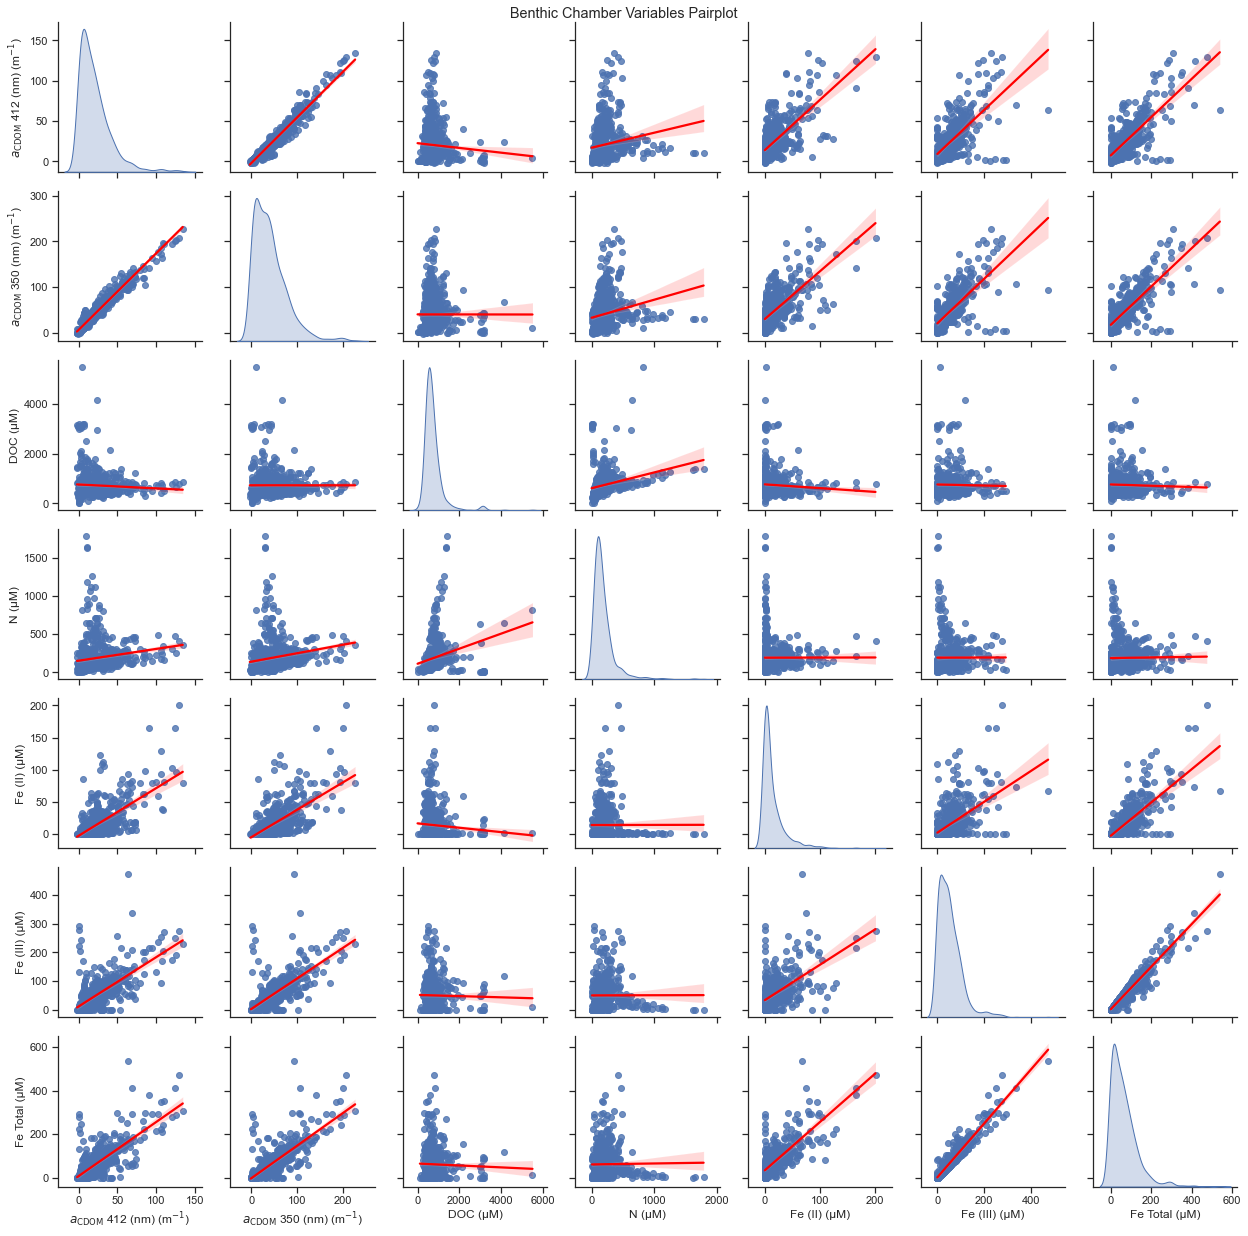

a_412 vs a_350: 0.89
a_412 vs NPOC_uM: 0.19
a_412 vs TN_uM: -0.22
a_412 vs Fe2_uM: -0.08
a_412 vs Fe3_uM: 0.03
a_412 vs FeT_uM: -0.02
a_350 vs NPOC_uM: 0.36
a_350 vs TN_uM: -0.21
a_350 vs Fe2_uM: 0.01
a_350 vs Fe3_uM: 0.02
a_350 vs FeT_uM: 0.02
NPOC_uM vs TN_uM: 0.14
NPOC_uM vs Fe2_uM: 0.27
NPOC_uM vs Fe3_uM: 0.06
NPOC_uM vs FeT_uM: 0.12
TN_uM vs Fe2_uM: 0.14
TN_uM vs Fe3_uM: 0.01
TN_uM vs FeT_uM: 0.03
Fe2_uM vs Fe3_uM: -0.09
Fe2_uM vs FeT_uM: 0.16
Fe3_uM vs FeT_uM: 0.96


In [67]:
# Define the variables to plot
variables = ['a_412', 'a_350', 'NPOC_uM', 'TN_uM', 'Fe2_uM', 'Fe3_uM', 'FeT_uM']

#make a subset with no dups 
#Duplicate samples occur in the GOM2021 data becuse of rerunning cdom at diff pathlenghts 
df_bc_wod = df_bc[~df_bc.index.duplicated(keep='first')]

# Create a pairplot with correlation coefficients
sns.set(style='ticks')
pairplot = sns.pairplot(df_pw_wod[variables], kind='reg', diag_kind='kde',
                        plot_kws=dict(line_kws={'color': 'red'}), diag_kws=dict(shade=True))

# Set the axis labels and title
for i, var in enumerate(variables):
    pairplot.axes[variables.index(var), 0].set_ylabel(var.replace('TN_uM', 'N (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
    pairplot.axes[-1, i].set_xlabel(var.replace('TN_uM', 'N (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
pairplot.fig.suptitle('Benthic Chamber Variables Pairplot')

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig("../../../Data_Thesis/FIGS/Cor_plots/BC_pairplot")

# Show the plot
plt.show()

# Print out the correlation coefficients for all pairs of variables
correlations = df_bc_wod[variables].corr()
correlations_list = []
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            corr = correlations.loc[var1, var2]
            print(f"{var1} vs {var2}: {corr:.2f}")
            correlations_list.append((var1, var2, corr))


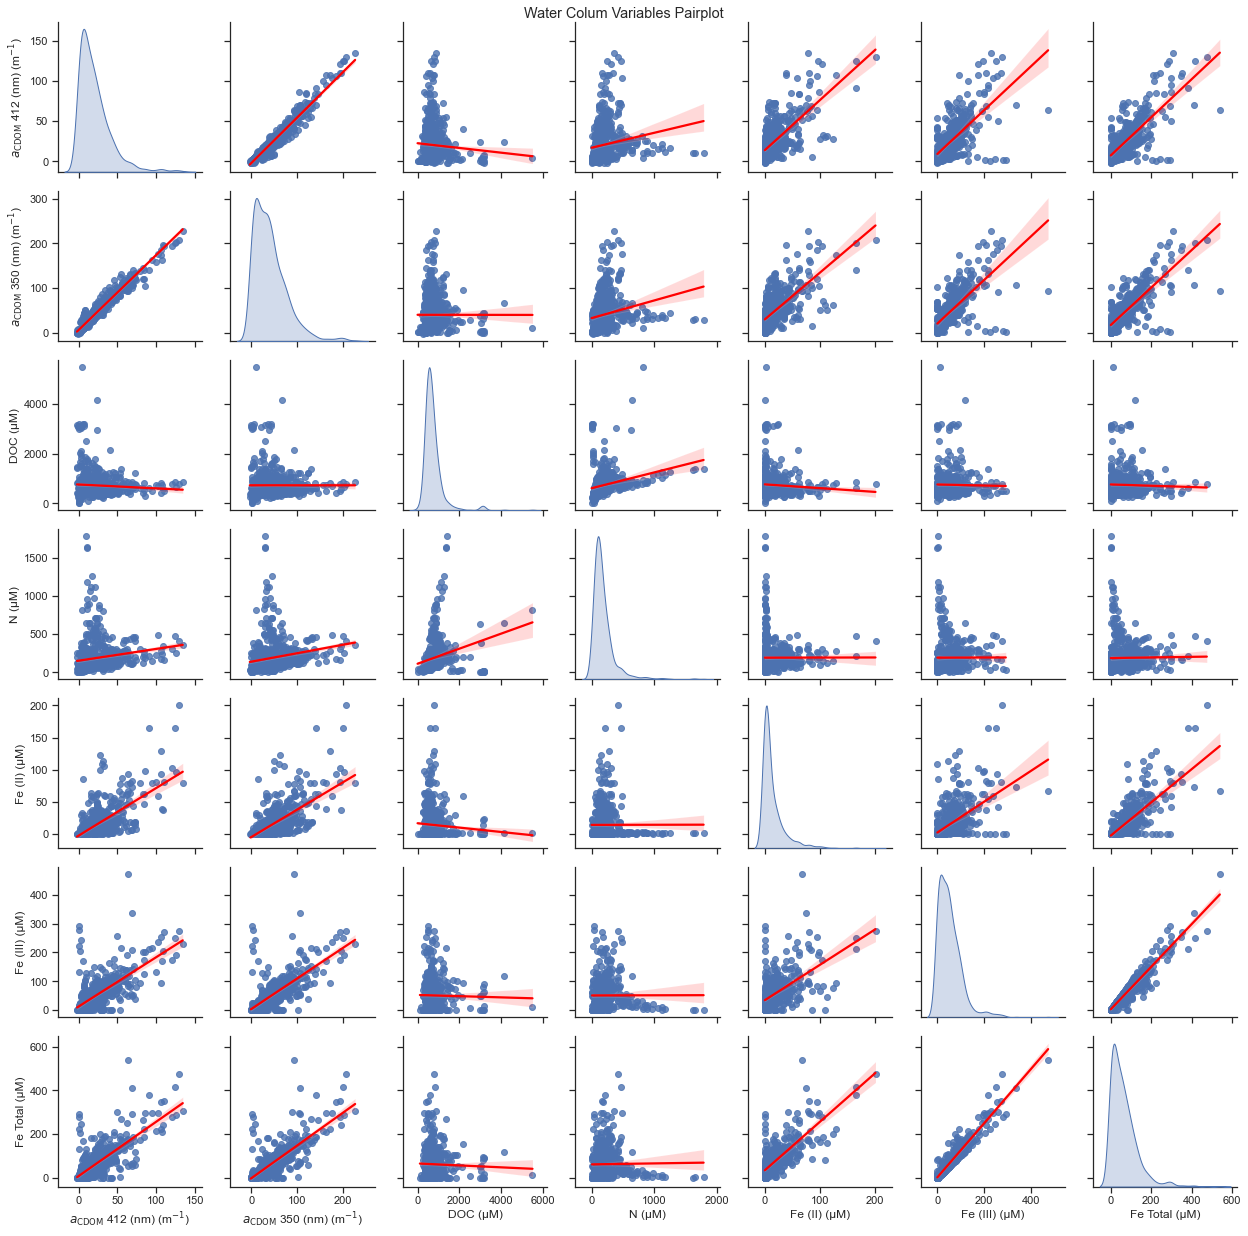

a_412 vs a_350: 0.84
a_412 vs NPOC_uM: 0.28
a_412 vs TN_uM: 0.05
a_412 vs Fe2_uM: 0.09
a_412 vs Fe3_uM: 0.27
a_412 vs FeT_uM: 0.19
a_350 vs NPOC_uM: 0.37
a_350 vs TN_uM: 0.14
a_350 vs Fe2_uM: 0.28
a_350 vs Fe3_uM: 0.32
a_350 vs FeT_uM: 0.22
NPOC_uM vs TN_uM: -0.27
NPOC_uM vs Fe2_uM: 0.32
NPOC_uM vs Fe3_uM: -0.25
NPOC_uM vs FeT_uM: -0.18
TN_uM vs Fe2_uM: -0.15
TN_uM vs Fe3_uM: 0.04
TN_uM vs FeT_uM: 0.02
Fe2_uM vs Fe3_uM: 0.29
Fe2_uM vs FeT_uM: 0.44
Fe3_uM vs FeT_uM: 0.98


In [68]:
# Define the variables to plot
variables = ['a_412', 'a_350', 'NPOC_uM', 'TN_uM', 'Fe2_uM', 'Fe3_uM', 'FeT_uM']

#make a subset with no dups 
df_wc_wod = df_wc[~df_wc.index.duplicated(keep='first')]

# Create a pairplot with correlation coefficients
sns.set(style='ticks')
pairplot = sns.pairplot(df_pw_wod[variables], kind='reg', diag_kind='kde',
                        plot_kws=dict(line_kws={'color': 'red'}), diag_kws=dict(shade=True))

# Set the axis labels and title
for i, var in enumerate(variables):
    pairplot.axes[variables.index(var), 0].set_ylabel(var.replace('TN_uM', 'N (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
    pairplot.axes[-1, i].set_xlabel(var.replace('TN_uM', 'N (\u03BCM)').replace('NPOC_uM', 'DOC (\u03BCM)').replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)').replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
pairplot.fig.suptitle('Water Colum Variables Pairplot')

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig("../../../Data_Thesis/FIGS/Cor_plots/WC_pairplot")

# Show the plot
plt.show()

# Print out the correlation coefficients for all pairs of variables
correlations = df_wc_wod[variables].corr()
correlations_list = []
for i, var1 in enumerate(variables):
    for j, var2 in enumerate(variables):
        if i < j:
            corr = correlations.loc[var1, var2]
            print(f"{var1} vs {var2}: {corr:.2f}")
            correlations_list.append((var1, var2, corr))


C:\Users\12532\AppData\Local\Temp\ipykernel_20532\3161686507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\12532\AppData\Local\Temp\ipykernel_20532\3161686507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\12532\AppData\Local\Temp\ipykernel_20532\3161686507.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\12532\AppD

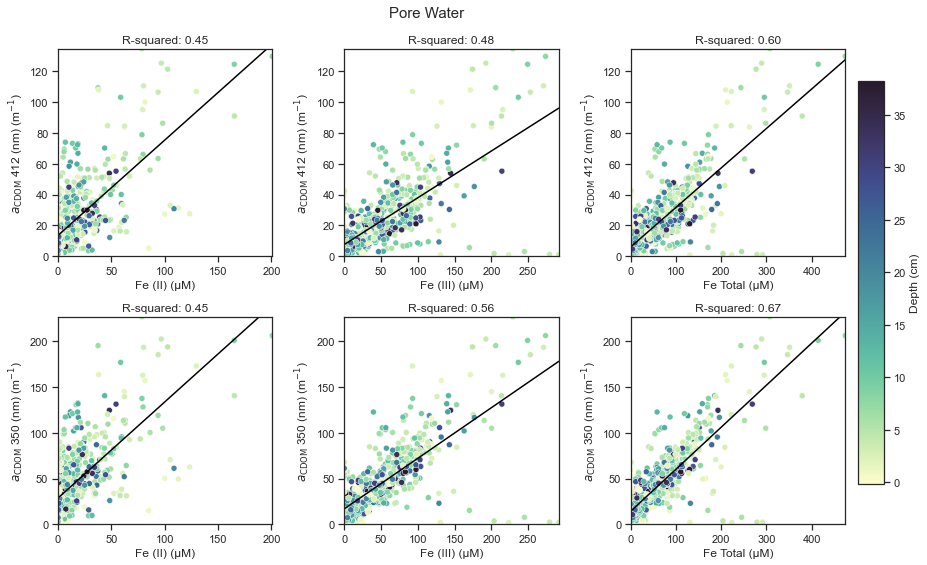

In [69]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Set up the color bar limits
vmin = df_pw_wod['Depth'].min()
vmax = df_pw_wod['Depth'].max()

# Loop through the subplots
for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM']):
    for j, y_var in enumerate(['a_412', 'a_350']):
        # Prepare the data for the subplot
        data = df_pw_wod[[x_var, y_var, 'Depth']]
        data.dropna(inplace=True)
        X = data[[x_var]]
        y = data[y_var]
        colors = data['Depth']

        # Fit a linear regression model to the data
        model = LinearRegression()
        model.fit(X, y)
        score = model.score(X, y)

        # Plot the data and regression line
        ax = axes[j, i]
        sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.deep, vmin=vmin, vmax=vmax, legend=False)
        sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

        # Set the axis labels and title
        ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)'))
        ax.set_ylabel(y_var.replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
        ax.set_title(f'R-squared: {score:.2f}')
        ax.set_ylim([0, data[y_var].max()])
        ax.set_xlim([0, data[x_var].max()])

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.deep, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('Depth (cm)')
        
# Adjust the layout of the subplots
fig.suptitle('Pore Water', size = 15)
fig.set_facecolor('w')
plt.tight_layout()

plt.savefig("../../../Data_Thesis/FIGS/Cor_plots/PW_IRON_CDOM_DEPTH")

plt.show()

C:\Users\12532\AppData\Local\Temp\ipykernel_20532\3390131750.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\12532\AppData\Local\Temp\ipykernel_20532\3390131750.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\12532\AppData\Local\Temp\ipykernel_20532\3390131750.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
C:\Users\12532\AppD

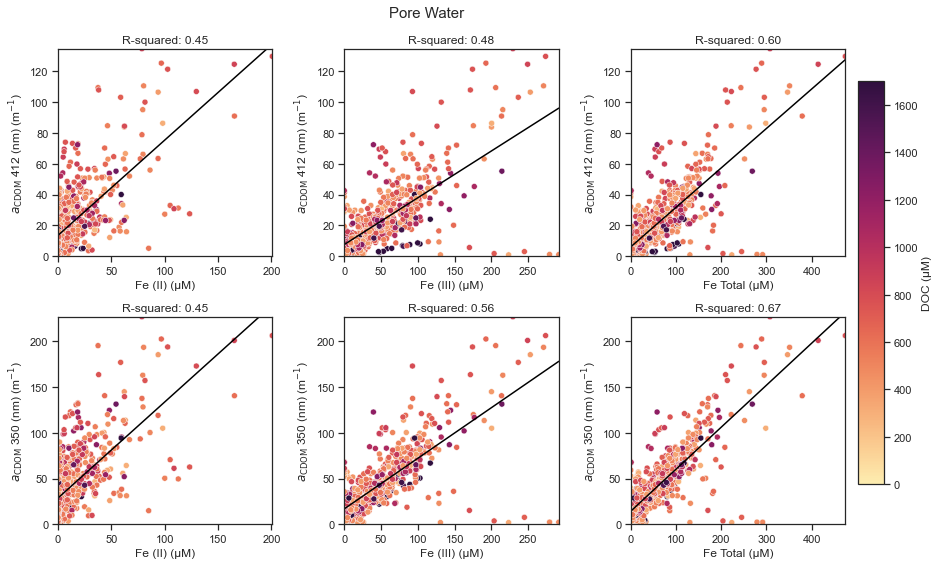

In [70]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Set up the color bar limits
vmin = 0
vmax = 1700

# Loop through the subplots
for i, x_var in enumerate(['Fe2_uM', 'Fe3_uM', 'FeT_uM']):
    for j, y_var in enumerate(['a_412', 'a_350']):
        # Prepare the data for the subplot
        data = df_pw_wod[[x_var, y_var, 'NPOC_uM']]
        data.dropna(inplace=True)
        X = data[[x_var]]
        y = data[y_var]
        colors = data['NPOC_uM']

        # Fit a linear regression model to the data
        model = LinearRegression()
        model.fit(X, y)
        score = model.score(X, y)

        # Plot the data and regression line
        ax = axes[j, i]
        sns.scatterplot(x=x_var, y=y_var, data=data, ax=ax, c=colors, cmap=cmo.matter, vmin=vmin, vmax=vmax, legend=False)
        sns.lineplot(x=X[x_var], y=model.predict(X), ax=ax, color='black')

        # Set the axis labels and title
        ax.set_xlabel(x_var.replace('Fe2_uM', 'Fe (II) (\u03BCM)').replace('Fe3_uM', 'Fe (III) (\u03BCM)').replace('FeT_uM', 'Fe Total (\u03BCM)'))
        ax.set_ylabel(y_var.replace('a_412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('a_350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
        ax.set_title(f'R-squared: {score:.2f}')
        ax.set_ylim([0, data[y_var].max()])
        ax.set_xlim([0, data[x_var].max()])

# Add a color bar for the depth on the right side of the figure
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmo.matter, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
cbar.ax.set_ylabel('DOC (\u03BCM)')
        
# Adjust the layout of the subplots
fig.suptitle('Pore Water', size = 15)
fig.set_facecolor('w')
plt.tight_layout()

plt.savefig("../../../Data_Thesis/FIGS/Cor_plots/PW_IRON_CDOM_DOC")

plt.show()

# PART 9: Calculated fluxes 

here we calcuate fluxes from the BC data 

In [71]:
df_locs_bc_gom21su['code'] = df_locs_bc_gom21su['Station'] + '_GOM2021'
df_locs_bc_gom21su['Trip'] = 'GOM2021'
df_locs_bc_gom21su['sal'] = np.nan
df_locs_bc_gom21su['oxy'] = np.nan

df_locs_bc_gom21fa['code'] = df_locs_bc_gom21fa['Station'] + '_GOM21FA'
df_locs_bc_gom21fa['Trip'] = 'GOM21FA'

df_locs_bc_gom22sp['code'] = df_locs_bc_gom22sp['Station'] + '_GOM22SP'
df_locs_bc_gom22sp['Trip'] = 'GOM22SP'

df_locs_bc_gom22su['code'] = df_locs_bc_gom22su['Station'] + '_GOM22SU'
df_locs_bc_gom22su['Trip'] = 'GOM22SU'

df_locs = pd.concat([df_locs_bc_gom21su, df_locs_bc_gom21fa, df_locs_bc_gom22sp, df_locs_bc_gom22su], axis=0)

df_locs = df_locs.sort_values('Date')
df_locs.index = df_locs['code']

In [72]:
df_hights = pd.read_csv('../../../Data_Thesis/Meta_data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
df_hights.drop("Stn", axis=1, inplace=True)
df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

df_locs = pd.concat([df_hights, df_locs], axis=1)
df_locs = df_locs.sort_values('Station')
df_locs

Hight_m Station        Date  Water_depth  \
code                                                       
St.11_GOM22SU  0.038170   St.11  2022-07-22        947.0   
St.11_GOM21FA  0.233333   St.11  2021-11-10        934.0   
St.11_GOM2021  0.176667   St.11  2021-07-25        946.0   
St.12_GOM21FA  0.145000   St.12  2021-11-09        970.0   
St.12_GOM22SU  0.044296   St.12  2022-07-21       1003.0   
St.13_GOM21FA  0.133333   St.13  2021-11-07        464.0   
St.13_GOM22SU  0.030159   St.13  2022-07-18        490.0   
St.13_GOM2021  0.070000   St.13  2021-07-21        328.0   
St.14_GOM22SU  0.032987   St.14  2022-07-16         88.6   
St.14_GOM22SP  0.140000   St.14  2022-04-09         91.0   
St.15_GOM22SP  0.103333   St.15  2022-04-16        267.0   
St.15_GOM2021  0.118333   St.15  2021-07-23        285.0   
St.15_GOM22SU  0.034118   St.15  2022-07-15        268.0   
St.15_GOM21FA  0.140000   St.15  2021-11-02        264.9   
St.16_GOM2021  0.126667   St.16  2021-07-24         62.0   
St.16_GOM22SU  0.028746   St.16  2022-07-20         57.2   
St.16_GOM22SP  0.180000   St.16  2022-04-11         60.0   
St.16_GOM21FA  0.133333   St.16  2021-11-08         58.2   
St.2_GOM22SP   0.088750    St.2  2022-04-17         65.0   
St.2_GOM2021   0.115000    St.2  2021-07-22         62.0   
St.2_GOM22SU   0.027921    St.2  2022-07-19         62.0   
St.4_GOM22SP   0.180000    St.4  2022-04-20         17.5   
St.4_GOM22SU   0.042412    St.4  2022-07-10         16.9   
St.4_GOM2021   0.163500    St.4  2021-07-17         16.4   
St.5B_GOM21FA  0.116667   St.5B  2021-10-25         12.3   
St.5B_GOM22SU  0.045239   St.5B  2022-07-10         12.2   
St.5B_GOM2021  0.158750   St.5B  2021-07-16         12.6   
St.5B_GOM22SP  0.168750   St.5B  2022-04-14         14.4   
St.7_GOM22SU   0.040527    St.7  2022-07-12         40.7   
St.7_GOM21FA   0.170000    St.7  2021-10-31         39.2   
St.7_GOM22SP   0.146667    St.7  2022-04-10         39.7   
St.7_GOM2021   0.067500    St.7  2021-07-26         39.0   
St.9_GOM21FA   0.115000    St.9  2021-11-01         80.6   
St.9_GOM22SU   0.030536    St.9  2022-07-17         80.2   
St.9_GOM22SP   0.162500    St.9  2022-04-16         82.5   
St.9_GOM2021   0.071250    St.9  2021-07-20         78.0   
St.MK_GOM21FA  0.217500   St.MK  2021-10-27         16.5   
St.MK_GOM22SP  0.136667   St.MK  2022-04-19         17.5   
St.MK_GOM2021  0.201250   St.MK  2021-07-15         16.7   
St.MK_GOM22SU  0.053721   St.MK  2022-07-23         17.5   
St.13_GOM22SP  0.145000     NaN         NaN          NaN   
St.4_GOM21FA        NaN     NaN         NaN          NaN   
St.14_GOM21FA  0.158333     NaN         NaN          NaN   
St.2_GOM21FA        NaN     NaN         NaN          NaN   

                                                           notes  \
code                                                               
St.11_GOM22SU                                                      
St.11_GOM21FA                             TOC/TN analysis failed   
St.11_GOM2021                                                      
St.12_GOM21FA                                                      
St.12_GOM22SU                                                      
St.13_GOM21FA                                                      
St.13_GOM22SU                                                      
St.13_GOM2021              Deep lander motors stopped during run   
St.14_GOM22SU                                                      
St.14_GOM22SP      Some samples may be swapped from bad labeling   
St.15_GOM22SP  particles were found in sample #1 because moto...   
St.15_GOM2021                                                      
St.15_GOM22SU                                                      
St.15_GOM21FA                                                      
St.16_GOM2021                        Benthic chamber not closed?   
St.16_GOM22SU                                                      
St.16_GOM22SP                  

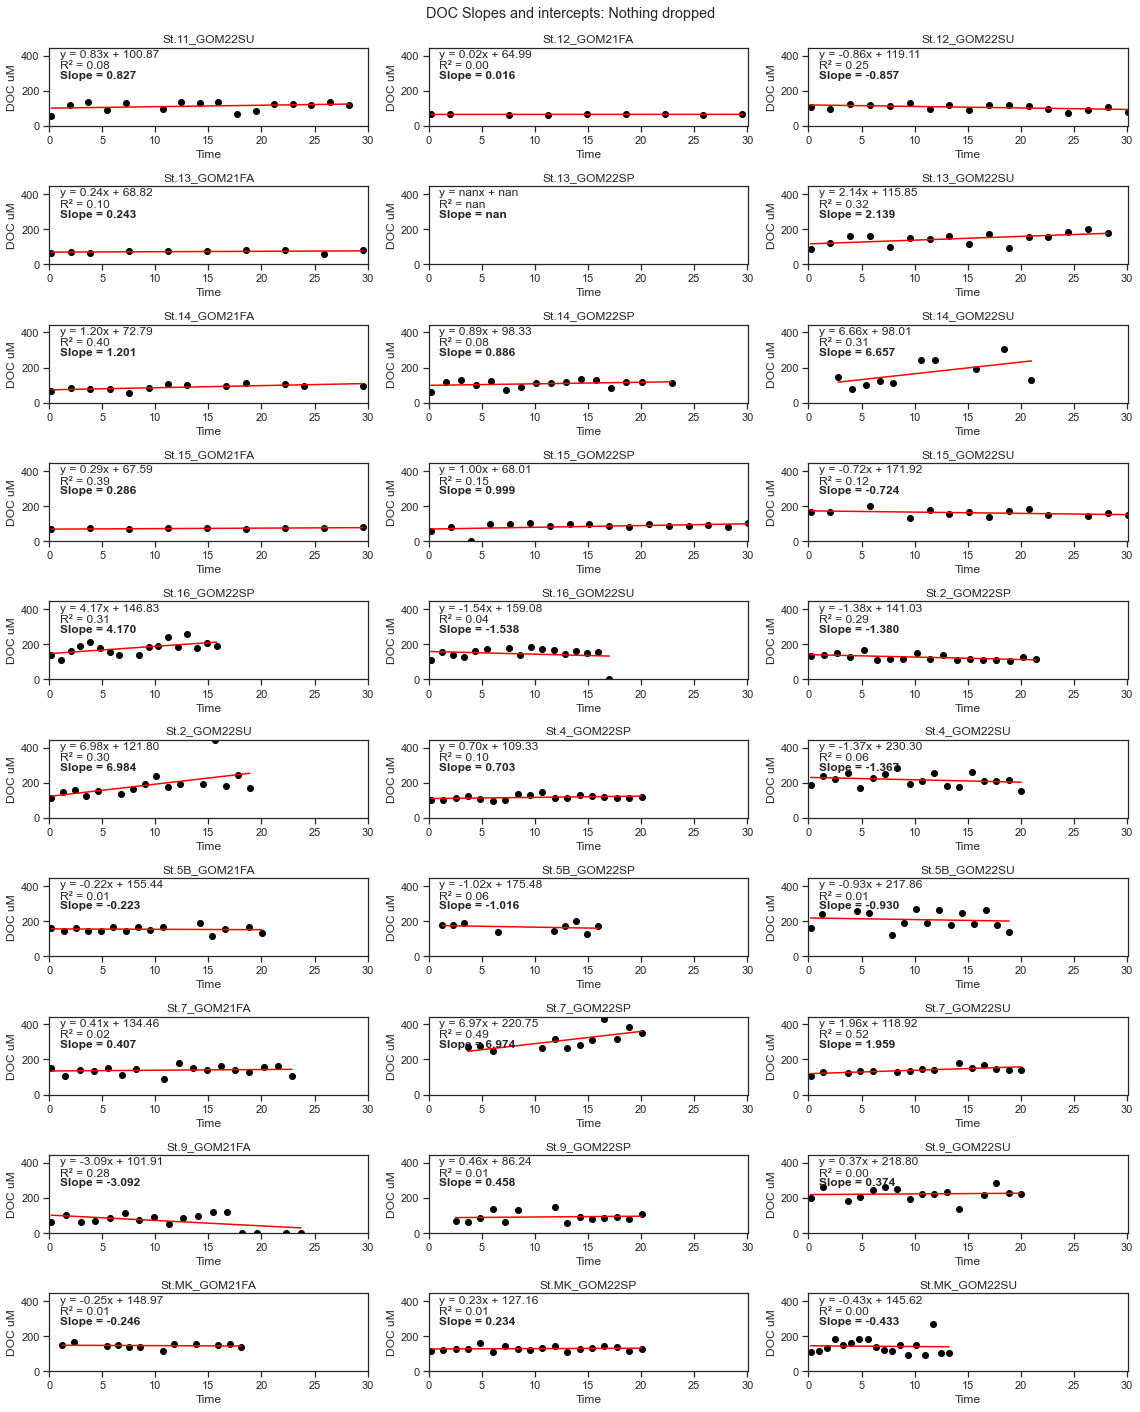

In [73]:
#DOC slopes 
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time']
    y = group['NPOC_uM']
    color = group['dil_fac']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c="black", cmap=cmo.matter)
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('DOC uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['NPOC_uM'].min(),df_doc_bc['NPOC_uM'].max())
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, 390, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, 325, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, 270, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'DOC Slopes and intercepts: Nothing dropped' '\n')
plt.tight_layout()
plt.show()


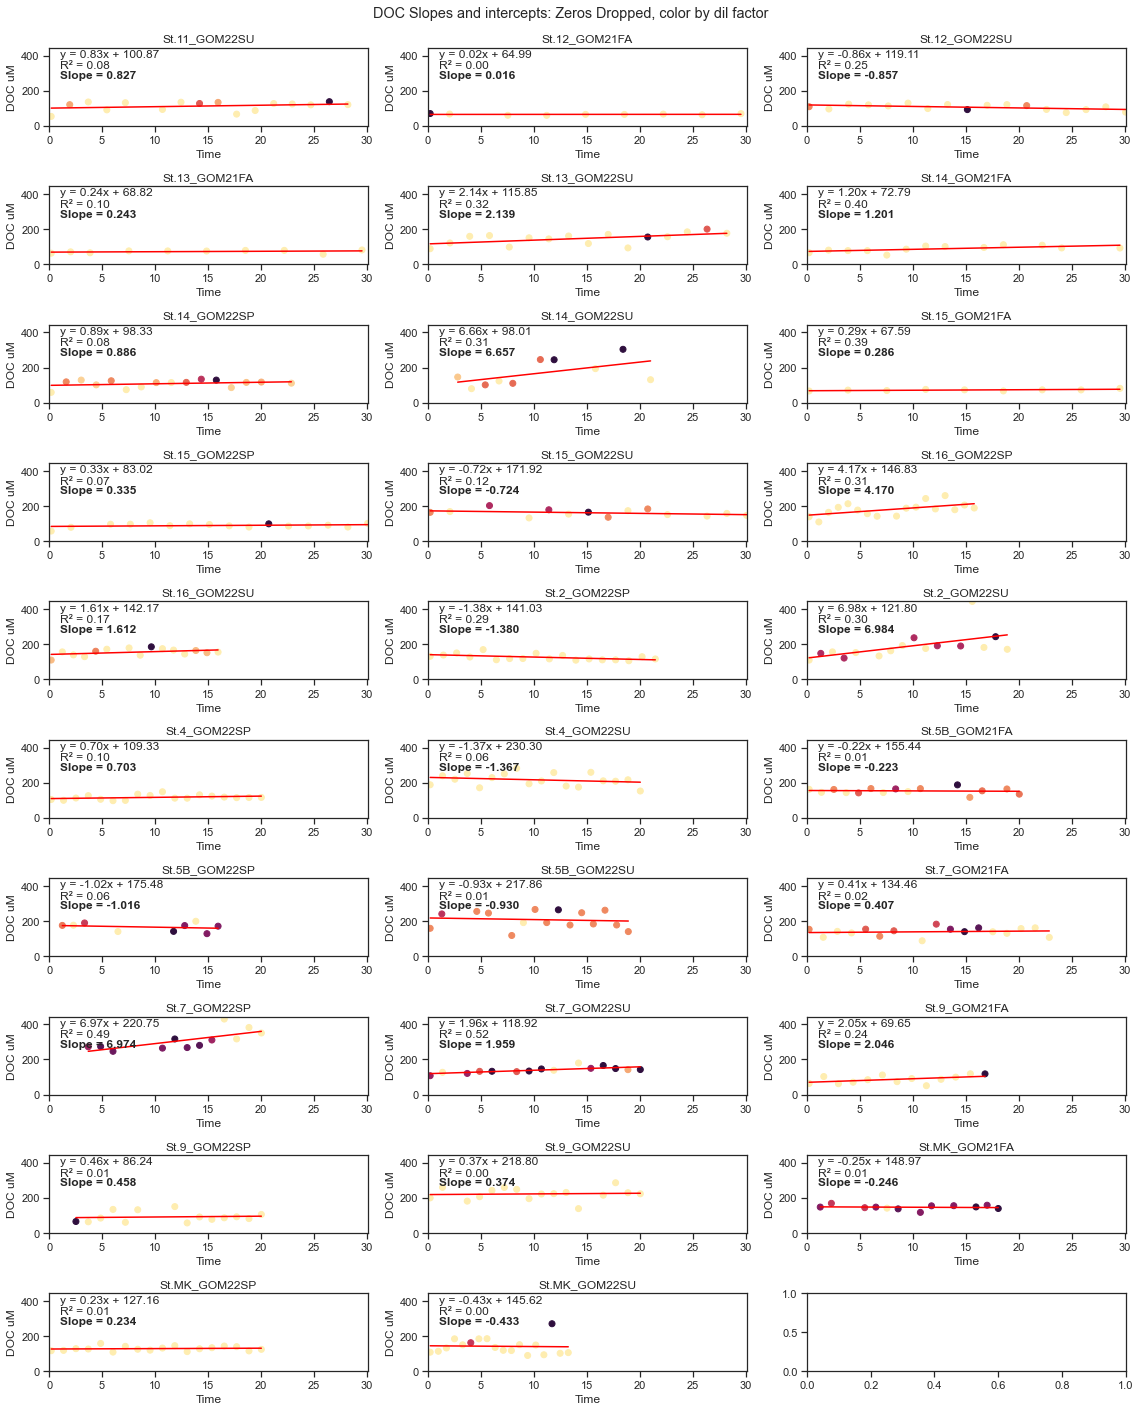

In [74]:
#DOC slopes 
df_doc_bc_plot = df_doc_bc[(df_doc_bc['NPOC_uM'] != 0)]
df_doc_bc_plot = df_doc_bc_plot.dropna(subset=["NPOC_uM"])
codes = df_doc_bc_plot['code'].unique()
df_doc_bc_plot = df_doc_bc_plot[df_doc_bc_plot['code'] != 'St.13_GOM22SP']

#make plot
fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time']
    y = group['NPOC_uM']
    color = group['dil_fac']
    
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c=color, cmap=cmo.matter)
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('DOC uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['NPOC_uM'].min(),df_doc_bc['NPOC_uM'].max())
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, 390, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, 325, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, 270, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'DOC Slopes and intercepts: Zeros Dropped, color by dil factor' '\n')
plt.tight_layout()
plt.show()


In [75]:
#DOC slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_doc_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time']
    y = group['NPOC_uM']
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_doc':[slope],
            'rsquared_doc':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_doc = pd.concat(Frames, axis=0, ignore_index=False)
slopes_doc

slope_doc  rsquared_doc
code                                  
St.11_GOM22SU   0.826843      0.080986
St.12_GOM21FA   0.015842      0.001900
St.12_GOM22SU  -0.856904      0.248785
St.13_GOM21FA   0.242568      0.096451
St.13_GOM22SU   2.138855      0.323974
St.14_GOM21FA   1.200870      0.401519
St.14_GOM22SP   0.885987      0.083609
St.14_GOM22SU   6.657164      0.306087
St.15_GOM21FA   0.286288      0.386127
St.15_GOM22SP   0.334578      0.071992
St.15_GOM22SU  -0.723893      0.121678
St.16_GOM22SP   4.170333      0.308674
St.16_GOM22SU   1.611514      0.165804
St.2_GOM22SP   -1.380083      0.285800
St.2_GOM22SU    6.984106      0.302541
St.4_GOM22SP    0.702713      0.104181
St.4_GOM22SU   -1.366652      0.056909
St.5B_GOM21FA  -0.223055      0.007146
St.5B_GOM22SP  -1.016076      0.060630
St.5B_GOM22SU  -0.930294      0.012064
St.7_GOM21FA    0.406963      0.015166
St.7_GOM22SP    6.974251      0.489717
St.7_GOM22SU    1.958969      0.517675
St.9_GOM21FA    2.046339      0.244058
St.9_GOM22SP    0.458493      0.008683
St.9_GOM22SU    0.374383      0.004395
St.MK_GOM21FA  -0.246366      0.011520
St.MK_GOM22SP   0.234483      0.012344
St.MK_GOM22SU  -0.433100      0.001576

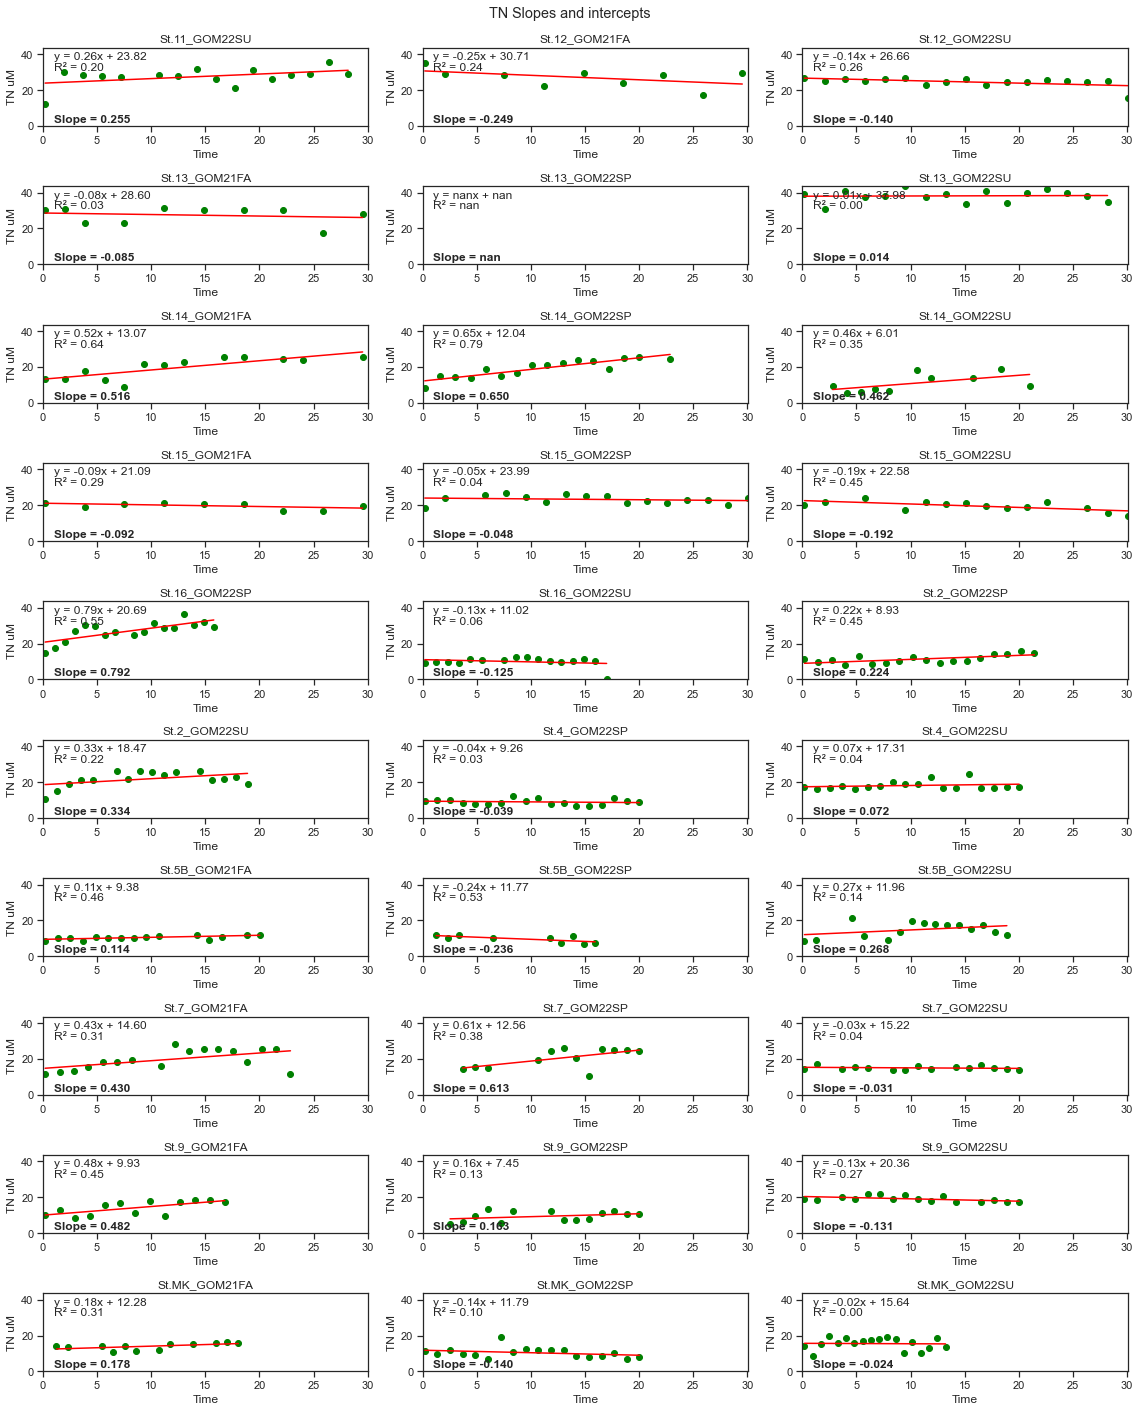

In [76]:
#Nitrogen slopes

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

df_tn_bc_plot = df_doc_bc[(df_doc_bc['TN_uM'] != 0)]

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_tn_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['Time']
    y = group['TN_uM']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='green')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('TN uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['TN_uM'].min(),df_doc_bc['TN_uM'].max())
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, 37, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, 31, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, 2, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'TN Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()


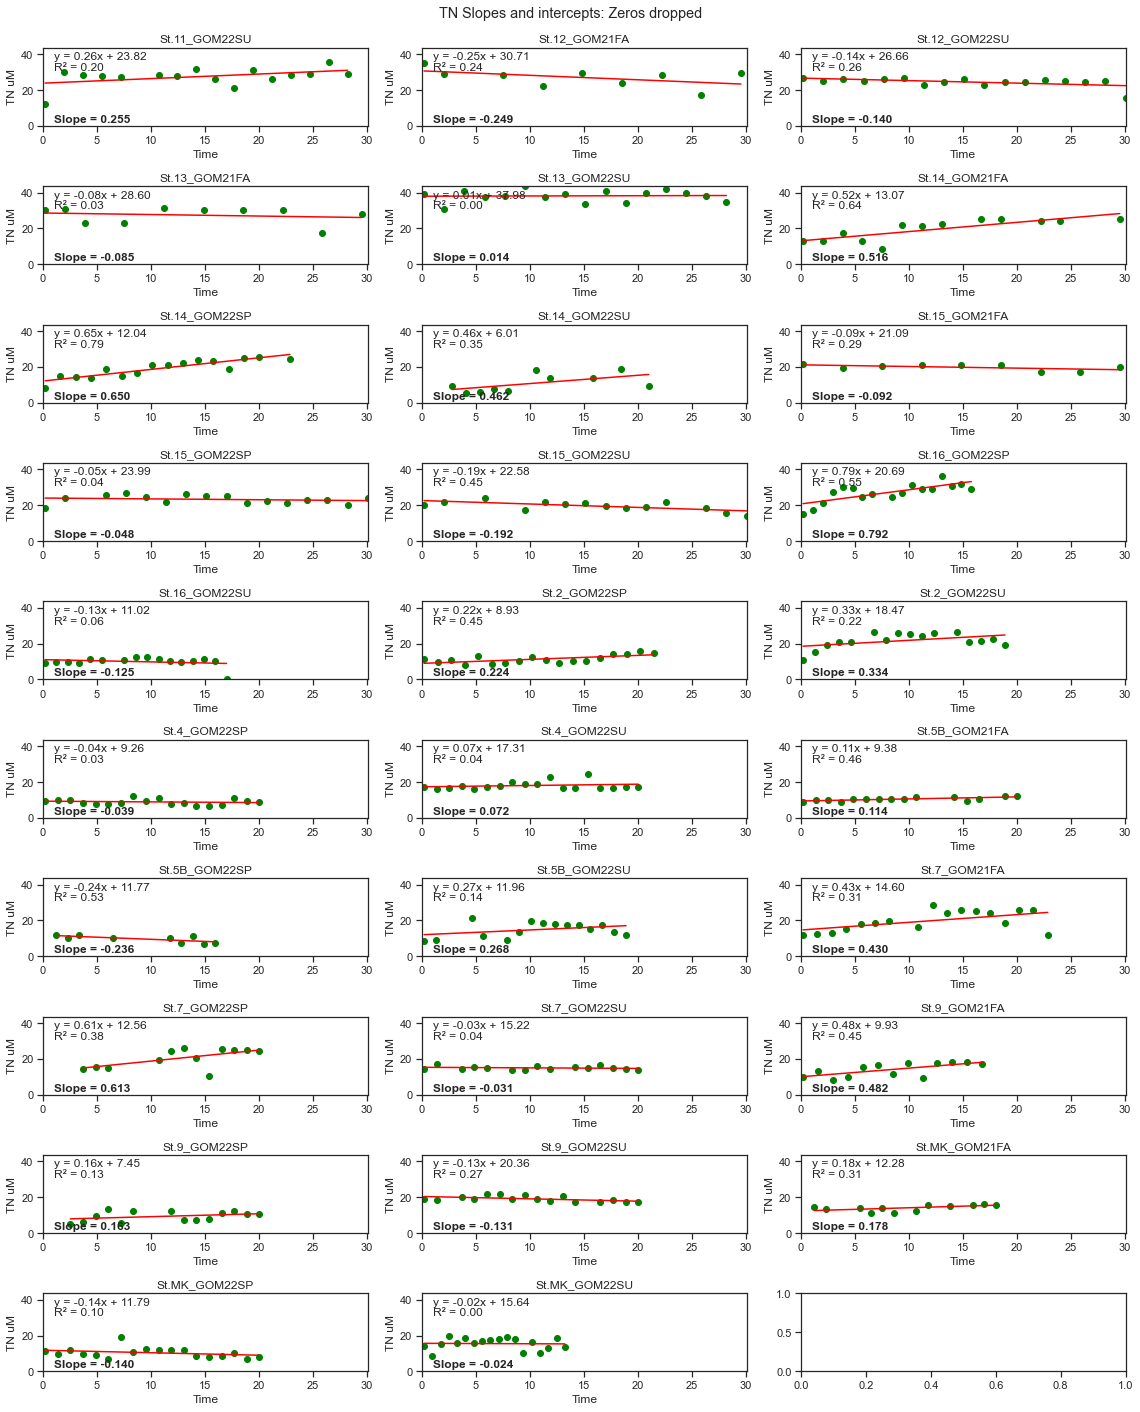

In [77]:
#Nitrogen slopes

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(16, 20)) 

df_tn_bc_plot = df_doc_bc[(df_doc_bc['TN_uM'] != 0)]
df_tn_bc_plot = df_tn_bc_plot.dropna(subset=["TN_uM"])
codes = df_tn_bc_plot['code'].unique()
df_tn_bc_plot = df_tn_bc_plot[df_tn_bc_plot['code'] != 'St.13_GOM22SP']

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_tn_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['Time']
    y = group['TN_uM']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='green')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('TN uM')
    ax.set_xlim(0,df_doc_bc['Time'].max())
    ax.set_ylim(df_doc_bc['TN_uM'].min(),df_doc_bc['TN_uM'].max())
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, 37, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, 31, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, 2, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'TN Slopes and intercepts: Zeros dropped' '\n')
plt.tight_layout()
plt.show()


In [78]:
#TN slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_tn_bc_plot.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Time']
    y = group['NPOC_uM']
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_tn':[slope],
            'rsquared_tn':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_tn = pd.concat(Frames, axis=0, ignore_index=False)
slopes_tn

slope_tn  rsquared_tn
code                                
St.11_GOM22SU  0.826843     0.080986
St.12_GOM21FA  0.015842     0.001900
St.12_GOM22SU -0.856904     0.248785
St.13_GOM21FA  0.242568     0.096451
St.13_GOM22SU  2.138855     0.323974
St.14_GOM21FA  1.200870     0.401519
St.14_GOM22SP  0.885987     0.083609
St.14_GOM22SU  6.657164     0.306087
St.15_GOM21FA  0.286288     0.386127
St.15_GOM22SP  0.334578     0.071992
St.15_GOM22SU -0.723893     0.121678
St.16_GOM22SP  4.170333     0.308674
St.16_GOM22SU -1.538360     0.037019
St.2_GOM22SP  -1.380083     0.285800
St.2_GOM22SU   6.984106     0.302541
St.4_GOM22SP   0.702713     0.104181
St.4_GOM22SU  -1.366652     0.056909
St.5B_GOM21FA -0.223055     0.007146
St.5B_GOM22SP -1.016076     0.060630
St.5B_GOM22SU -0.930294     0.012064
St.7_GOM21FA   0.406963     0.015166
St.7_GOM22SP   6.974251     0.489717
St.7_GOM22SU   1.958969     0.517675
St.9_GOM21FA   2.046339     0.244058
St.9_GOM22SP   0.458493     0.008683
St.9_GOM22SU   0.374383     0.004395
St.MK_GOM21FA -0.246366     0.011520
St.MK_GOM22SP  0.234483     0.012344
St.MK_GOM22SU -0.433100     0.001576

In [79]:
#clean out the Iron data for the slopes 
df_iron_bc_fe2_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe2_uM'] == 0) | (df_iron_bc['Fe2_uM'].isna())].index)

#clean out the Iron data for the slopes 
df_iron_bc_fe3_cl = df_iron_bc.drop(df_iron_bc[(df_iron_bc['Fe3_uM'] == 0) | (df_iron_bc['Fe3_uM'].isna())].index)

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\12532\minicond

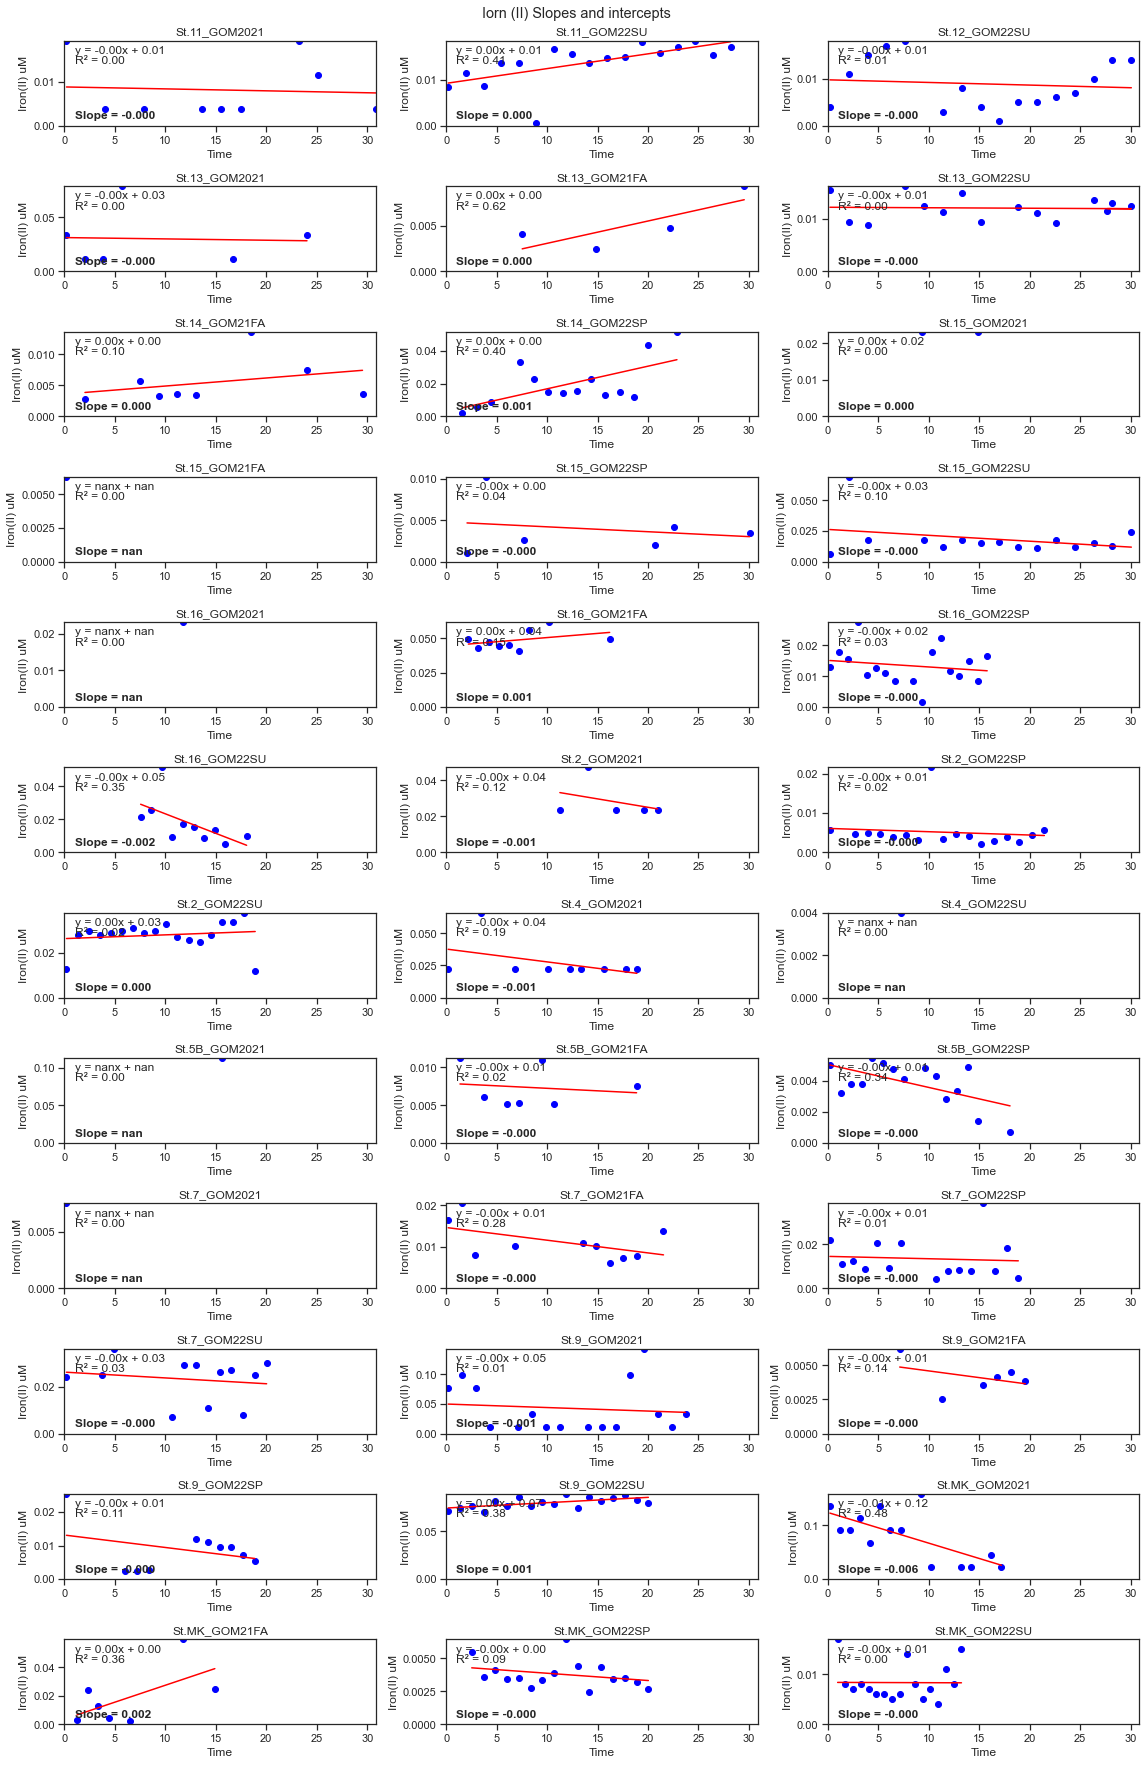

In [80]:
#Iron 2 slopes 

fig, axs = plt.subplots(nrows=12, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe2_cl.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['Fe2_Time']
    y = group['Fe2_uM']
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='blue')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('Iron(II) uM')
    ax.set_xlim(0,df_iron_bc_fe2_cl['Fe2_Time'].max())
    ax.set_ylim(0,max(y))
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'Iorn (II) Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()


In [81]:
#Fe2 slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe2_cl.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['Fe2_Time']
    y = group['Fe2_uM']
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_fe2':[slope],
            'rsquared_fe2':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_fe2 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_fe2

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


slope_fe2  rsquared_fe2
code                                  
St.11_GOM2021  -0.000044      0.004309
St.11_GOM22SU   0.000320      0.408881
St.12_GOM22SU  -0.000056      0.010072
St.13_GOM2021  -0.000123      0.001951
St.13_GOM21FA   0.000247      0.616710
St.13_GOM22SU  -0.000009      0.001604
St.14_GOM21FA   0.000129      0.102642
St.14_GOM22SP   0.001377      0.403588
St.15_GOM2021   0.000000      0.000000
St.15_GOM21FA        NaN      0.000000
St.15_GOM22SP  -0.000059      0.043079
St.15_GOM22SU  -0.000479      0.096883
St.16_GOM2021        NaN      0.000000
St.16_GOM21FA   0.000604      0.153901
St.16_GOM22SP  -0.000213      0.032198
St.16_GOM22SU  -0.002362      0.353473
St.2_GOM2021   -0.000935      0.123476
St.2_GOM22SP   -0.000084      0.015573
St.2_GOM22SU    0.000168      0.023125
St.4_GOM2021   -0.000995      0.190313
St.4_GOM22SU         NaN      0.000000
St.5B_GOM2021        NaN      0.000000
St.5B_GOM21FA  -0.000066      0.019756
St.5B_GOM22SP  -0.000147      0.337891
St.7_GOM2021         NaN      0.000000
St.7_GOM21FA   -0.000307      0.281489
St.7_GOM22SP   -0.000107      0.005475
St.7_GOM22SU   -0.000246      0.028275
St.9_GOM2021   -0.000593      0.011489
St.9_GOM21FA   -0.000098      0.141873
St.9_GOM22SP   -0.000372      0.106280
St.9_GOM22SU    0.000560      0.382209
St.MK_GOM2021  -0.005699      0.476172
St.MK_GOM21FA   0.002384      0.358790
St.MK_GOM22SP  -0.000055      0.090194
St.MK_GOM22SU  -0.000006      0.000044

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


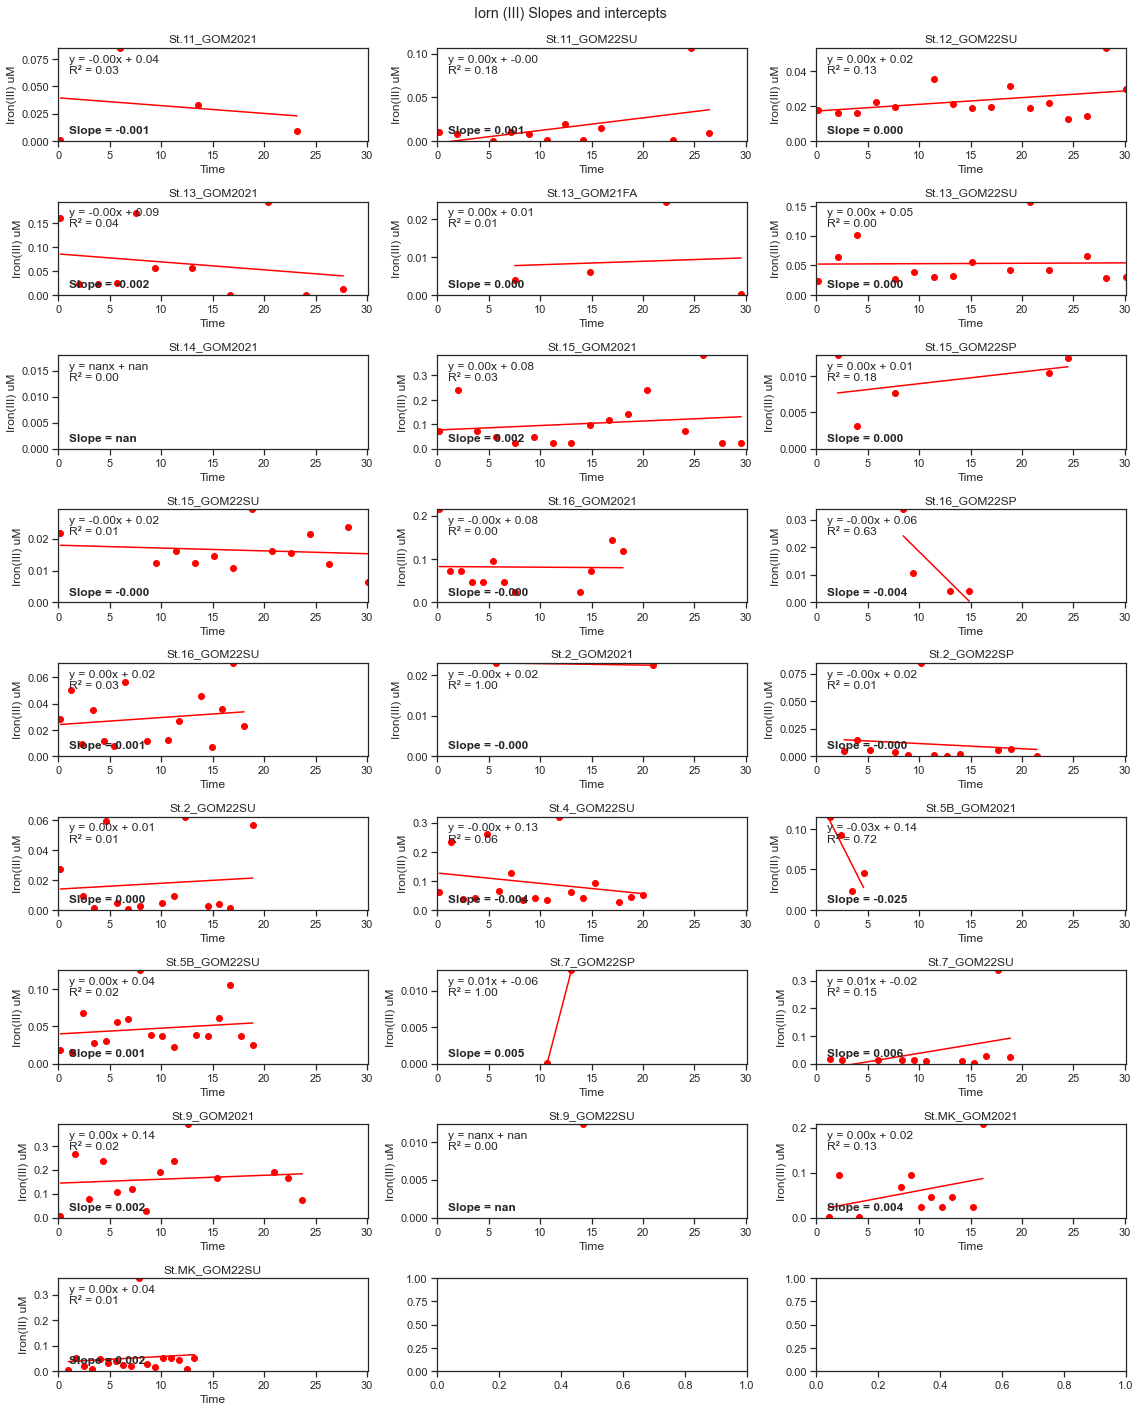

In [82]:
#Iron 3 slopes 

fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(16, 20)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe3_cl.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['FeT_Time'].ravel()
    y = group['Fe3_uM'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='red')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('Iron(III) uM')
    ax.set_xlim(0,df_iron_bc_fe3_cl['FeT_Time'].max())
    ax.set_ylim(0,max(y))
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'Iorn (III) Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()


In [83]:
#Fe3 slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_iron_bc_fe3_cl.groupby('code')):
    # Extract x, y, and c data from the group
    
    x = group['FeT_Time']
    y = group['Fe3_uM']
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_fe3':[slope],
            'rsquared_fe3':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_fe3 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_fe3

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\stats\_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


slope_fe3  rsquared_fe3
code                                  
St.11_GOM2021  -0.000710      0.034783
St.11_GOM22SU   0.001442      0.182746
St.12_GOM22SU   0.000385      0.132422
St.13_GOM2021  -0.001663      0.043530
St.13_GOM21FA   0.000091      0.006320
St.13_GOM22SU   0.000069      0.000341
St.14_GOM2021        NaN      0.000000
St.15_GOM2021   0.001838      0.028285
St.15_GOM22SP   0.000162      0.181248
St.15_GOM22SU  -0.000089      0.014600
St.16_GOM2021  -0.000150      0.000298
St.16_GOM22SP  -0.003684      0.628166
St.16_GOM22SU   0.000537      0.026896
St.2_GOM2021   -0.000037      1.000000
St.2_GOM22SP   -0.000471      0.014328
St.2_GOM22SU    0.000390      0.009097
St.4_GOM22SU   -0.003552      0.059767
St.5B_GOM2021  -0.025095      0.720000
St.5B_GOM22SU   0.000775      0.024366
St.7_GOM22SP    0.005387      1.000000
St.7_GOM22SU    0.006148      0.145663
St.9_GOM2021    0.001648      0.015016
St.9_GOM22SU         NaN      0.000000
St.MK_GOM2021   0.004342      0.134464
St.MK_GOM22SU   0.002196      0.010665

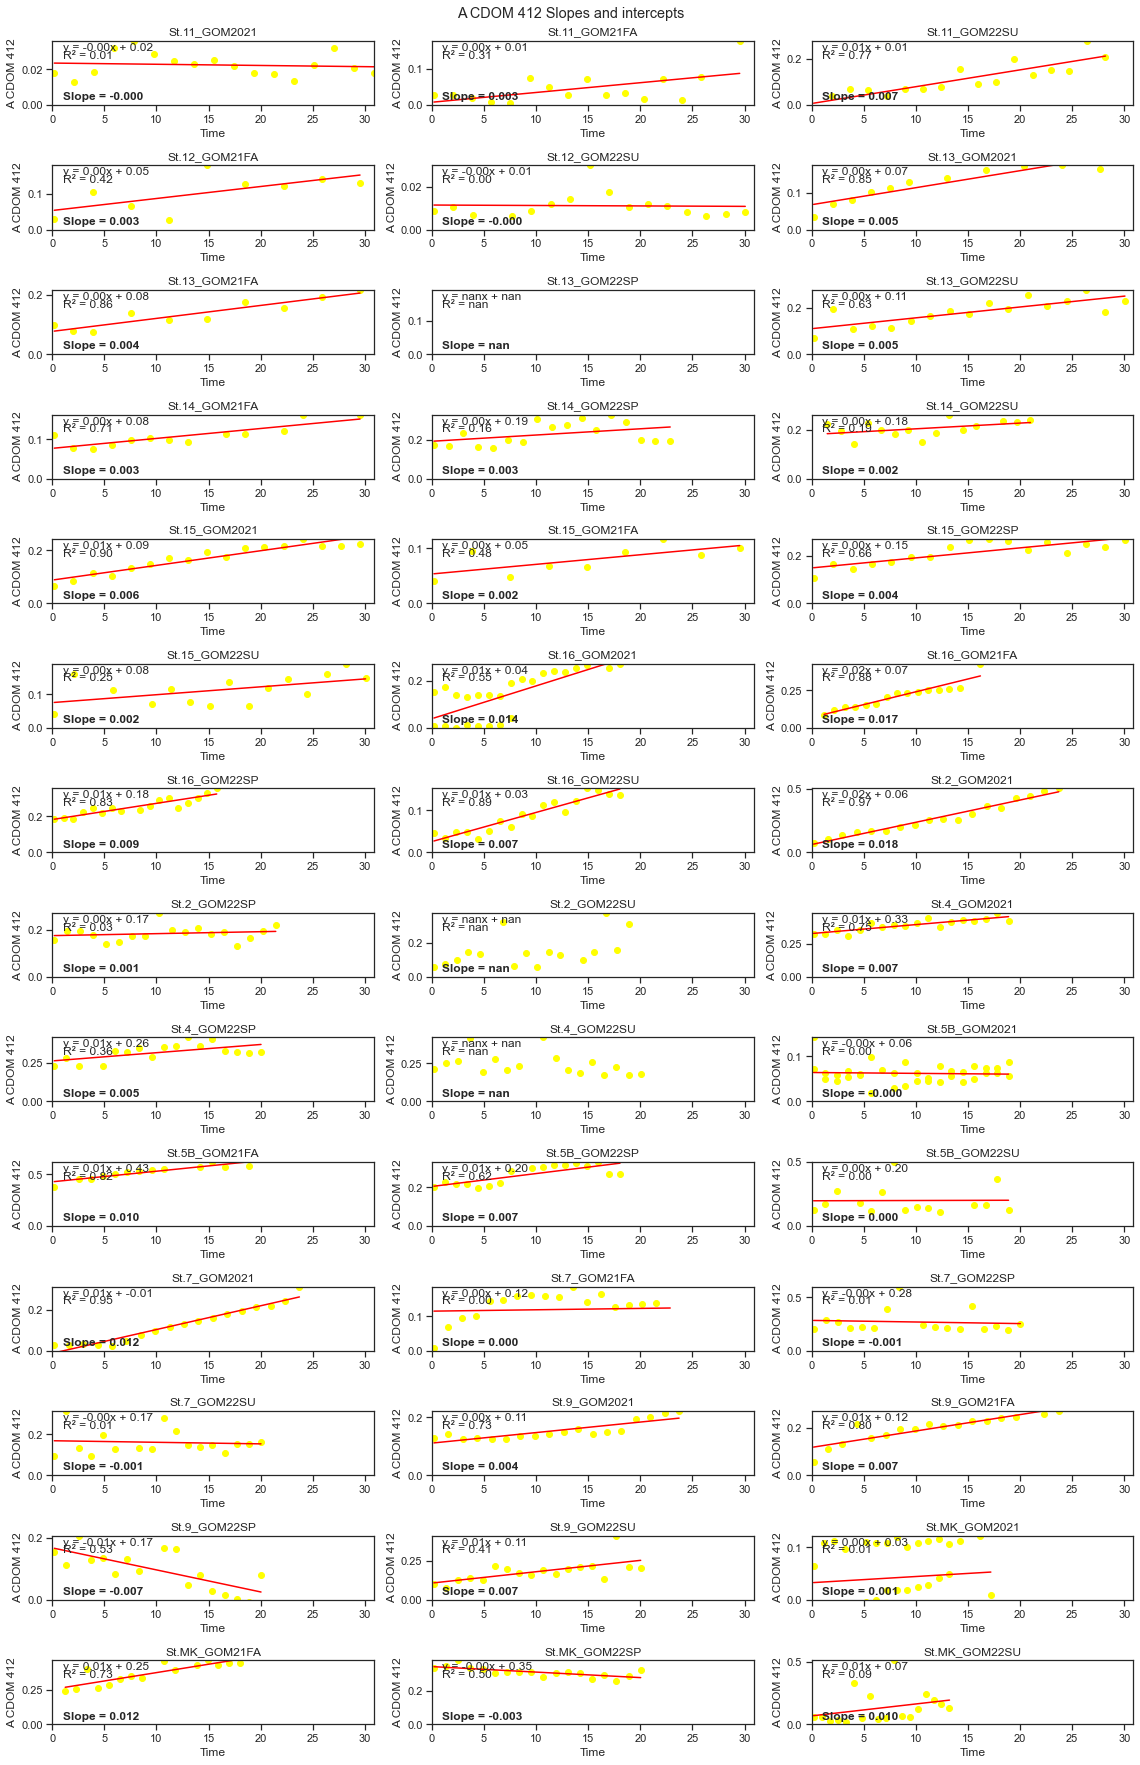

In [84]:
#CDOM slopes

fig, axs = plt.subplots(nrows=14, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_spectra_bc.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['BC_time'].ravel()
    y = group['a_412'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='yellow')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('A CDOM 412')
    ax.set_xlim(0,df_spectra_bc['BC_time'].max())
    ax.set_ylim(0,max(y))
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'A CDOM 412 Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()


In [85]:
#CDOM slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_spectra_bc.groupby('code')):
    
    # Extract x, y, and c data from the group
    x = group['BC_time'].ravel()
    y = group['a_412'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_a412':[slope],
            'rsquared_a412':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a412 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a412

slope_a412  rsquared_a412
code                                    
St.11_GOM2021   -0.000067       0.009651
St.11_GOM21FA    0.002684       0.314968
St.11_GOM22SU    0.007253       0.769255
St.12_GOM21FA    0.003351       0.417225
St.12_GOM22SU   -0.000021       0.001101
St.13_GOM2021    0.004627       0.849520
St.13_GOM21FA    0.004364       0.857197
St.13_GOM22SP         NaN            NaN
St.13_GOM22SU    0.004673       0.625625
St.14_GOM21FA    0.002525       0.708814
St.14_GOM22SP    0.003192       0.161402
St.14_GOM22SU    0.002334       0.191708
St.15_GOM2021    0.005544       0.895925
St.15_GOM21FA    0.001750       0.475714
St.15_GOM22SP    0.004211       0.661643
St.15_GOM22SU    0.002352       0.254685
St.16_GOM2021    0.013941       0.553381
St.16_GOM21FA    0.017115       0.878878
St.16_GOM22SP    0.009003       0.826168
St.16_GOM22SU    0.006920       0.892268
St.2_GOM2021     0.017529       0.967786
St.2_GOM22SP     0.000833       0.030093
St.2_GOM22SU          NaN            NaN
St.4_GOM2021     0.006788       0.750316
St.4_GOM22SP     0.005299       0.363848
St.4_GOM22SU          NaN            NaN
St.5B_GOM2021   -0.000189       0.002650
St.5B_GOM21FA    0.010272       0.818378
St.5B_GOM22SP    0.006660       0.623586
St.5B_GOM22SU    0.000217       0.000141
St.7_GOM2021     0.011615       0.948831
St.7_GOM21FA     0.000403       0.001971
St.7_GOM22SP    -0.001489       0.008019
St.7_GOM22SU    -0.000763       0.006470
St.9_GOM2021     0.003643       0.731214
St.9_GOM21FA     0.006940       0.795389
St.9_GOM22SP    -0.007102       0.532341
St.9_GOM22SU     0.007332       0.405442
St.MK_GOM2021    0.001178       0.007695
St.MK_GOM21FA    0.012132       0.728976
St.MK_GOM22SP   -0.003311       0.503967
St.MK_GOM22SU    0.009549       0.090958

C:\Users\12532\AppData\Local\Temp\ipykernel_20532\2685880311.py:20: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(0,max(y))


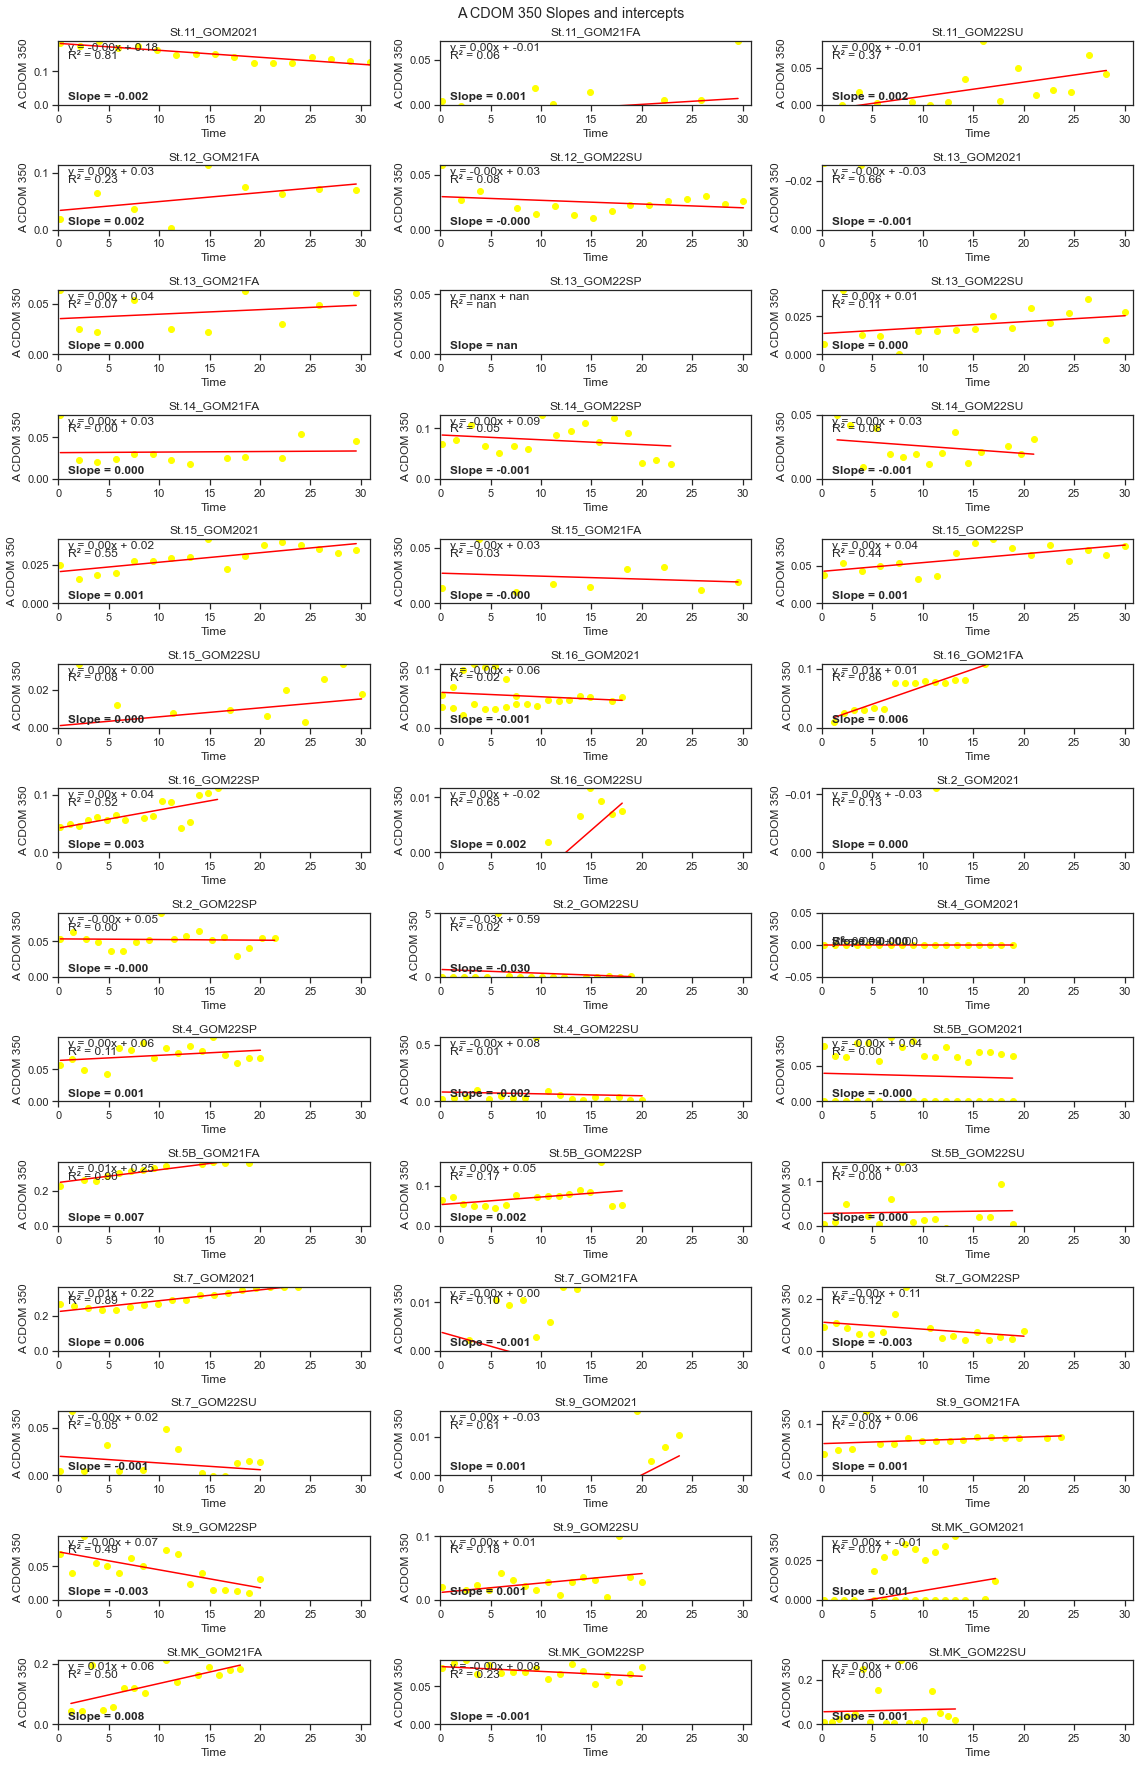

In [86]:
#CDOM slopes

fig, axs = plt.subplots(nrows=14, ncols=3, figsize=(16, 25)) 

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_spectra_bc.groupby('code')):
    # Extract x, y, and c data from the group
    x = group['BC_time'].ravel()
    y = group['a_530'].ravel()
    
    # Plot the data for this subgroup on its corresponding subplot
    ax = axs[i // 3, i % 3]
    sc = ax.scatter(x, y, c='yellow')
    
    # Add subplot labels
    ax.set_title(code)
    ax.set_xlabel('Time')
    ax.set_ylabel('A CDOM 350')
    ax.set_xlim(0,df_spectra_bc['BC_time'].max())
    ax.set_ylim(0,max(y))
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the regression line to the plot
    ax.plot(x, intercept + slope * x, c='red')
    
    # Add the equation of the regression line to the plot
    equation = f'y = {slope:.2f}x + {intercept:.2f}'
    ax.text(1, max(y)*.85, equation)
    
    # Add the r-squared value to the plot
    rsquared = f'R² = {r_value**2:.2f}'
    ax.text(1, max(y)*.73, rsquared)
    
    # Add the slope value to the plot
    sloped = f'Slope = {slope:.3f}'
    ax.text(1, max(y)*.08, sloped, fontweight='bold')

# Add overall figure labels and color bar
fig.suptitle(r'A CDOM 350 Slopes and intercepts' '\n')
plt.tight_layout()
plt.show()


In [87]:
#CDOM slopes Calculate 
Frames = []

# Group the data by 'code' and iterate over each subgroup
for i, (code, group) in enumerate(df_spectra_bc.groupby('code')):
    
    # Extract x, y, and c data from the group
    x = group['BC_time'].ravel()
    y = group['a_350'].ravel()
    
    # Calculate the slope of the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Add the r-squared value to the plot
    rsquared = r_value**2
    
    # Add the slope value to the plot
    slope = slope
    
    dic = {'code':[code],
            'slope_a350':[slope],
            'rsquared_a350':[rsquared]}
    
    slopes = pd.DataFrame(dic)
    slopes = slopes.set_index('code', drop=True)
    
    Frames.append(slopes)

slopes_a350 = pd.concat(Frames, axis=0, ignore_index=False)
slopes_a350

slope_a350  rsquared_a350
code                                    
St.11_GOM2021    0.003893       0.955346
St.11_GOM21FA    0.005551       0.525553
St.11_GOM22SU    0.015629       0.795781
St.12_GOM21FA    0.006614       0.634604
St.12_GOM22SU    0.001940       0.380897
St.13_GOM2021    0.012803       0.853078
St.13_GOM21FA    0.011701       0.977841
St.13_GOM22SP         NaN            NaN
St.13_GOM22SU    0.015158       0.784508
St.14_GOM21FA    0.008083       0.973161
St.14_GOM22SP    0.012930       0.562466
St.14_GOM22SU    0.011254       0.636776
St.15_GOM2021    0.013936       0.948601
St.15_GOM21FA    0.005206       0.849613
St.15_GOM22SP    0.010991       0.702341
St.15_GOM22SU    0.006189       0.479662
St.16_GOM2021    0.020939       0.411483
St.16_GOM21FA    0.042129       0.781815
St.16_GOM22SP    0.023477       0.876071
St.16_GOM22SU    0.014633       0.882543
St.2_GOM2021     0.024462       0.952591
St.2_GOM22SP     0.002879       0.103867
St.2_GOM22SU    -0.032348       0.010970
St.4_GOM2021     0.006387       0.468685
St.4_GOM22SP     0.017069       0.460860
St.4_GOM22SU    -0.011408       0.024272
St.5B_GOM2021    0.000533       0.005581
St.5B_GOM21FA    0.012917       0.669239
St.5B_GOM22SP    0.024876       0.816011
St.5B_GOM22SU   -0.000767       0.000704
St.7_GOM2021     0.012657       0.936094
St.7_GOM21FA     0.003785       0.030921
St.7_GOM22SP     0.005545       0.018740
St.7_GOM22SU    -0.000591       0.001862
St.9_GOM2021     0.005169       0.650467
St.9_GOM21FA     0.017464       0.861662
St.9_GOM22SP    -0.010213       0.472382
St.9_GOM22SU     0.012173       0.465054
St.MK_GOM2021    0.000356       0.000459
St.MK_GOM21FA    0.015433       0.803999
St.MK_GOM22SP   -0.010061       0.606490
St.MK_GOM22SU    0.017610       0.189857

In [88]:
#concat it all 
df_flux = pd.concat([df_locs, slopes_a412, slopes_a350, slopes_doc, slopes_tn, slopes_fe2, slopes_fe3], axis=1)

#calcute flux 
df_flux["flux_aCDOM412"] = df_flux["slope_a412"] * df_flux["Hight_m"]
df_flux["flux_aCDOM350"] = df_flux["slope_a350"] * df_flux["Hight_m"]
df_flux["flux_doc"] = df_flux["slope_doc"] * df_flux["Hight_m"]
df_flux["flux_tn"] = df_flux["slope_tn"] * df_flux["Hight_m"]
df_flux["flux_fe2"] = df_flux["slope_fe2"] * df_flux["Hight_m"]
df_flux["flux_fe3"] = df_flux["slope_fe3"] * df_flux["Hight_m"]

df_flux

Hight_m Station        Date  Water_depth  \
code                                                       
St.11_GOM22SU  0.038170   St.11  2022-07-22        947.0   
St.11_GOM21FA  0.233333   St.11  2021-11-10        934.0   
St.11_GOM2021  0.176667   St.11  2021-07-25        946.0   
St.12_GOM21FA  0.145000   St.12  2021-11-09        970.0   
St.12_GOM22SU  0.044296   St.12  2022-07-21       1003.0   
St.13_GOM21FA  0.133333   St.13  2021-11-07        464.0   
St.13_GOM22SU  0.030159   St.13  2022-07-18        490.0   
St.13_GOM2021  0.070000   St.13  2021-07-21        328.0   
St.14_GOM22SU  0.032987   St.14  2022-07-16         88.6   
St.14_GOM22SP  0.140000   St.14  2022-04-09         91.0   
St.15_GOM22SP  0.103333   St.15  2022-04-16        267.0   
St.15_GOM2021  0.118333   St.15  2021-07-23        285.0   
St.15_GOM22SU  0.034118   St.15  2022-07-15        268.0   
St.15_GOM21FA  0.140000   St.15  2021-11-02        264.9   
St.16_GOM2021  0.126667   St.16  2021-07-24         62.0   
St.16_GOM22SU  0.028746   St.16  2022-07-20         57.2   
St.16_GOM22SP  0.180000   St.16  2022-04-11         60.0   
St.16_GOM21FA  0.133333   St.16  2021-11-08         58.2   
St.2_GOM22SP   0.088750    St.2  2022-04-17         65.0   
St.2_GOM2021   0.115000    St.2  2021-07-22         62.0   
St.2_GOM22SU   0.027921    St.2  2022-07-19         62.0   
St.4_GOM22SP   0.180000    St.4  2022-04-20         17.5   
St.4_GOM22SU   0.042412    St.4  2022-07-10         16.9   
St.4_GOM2021   0.163500    St.4  2021-07-17         16.4   
St.5B_GOM21FA  0.116667   St.5B  2021-10-25         12.3   
St.5B_GOM22SU  0.045239   St.5B  2022-07-10         12.2   
St.5B_GOM2021  0.158750   St.5B  2021-07-16         12.6   
St.5B_GOM22SP  0.168750   St.5B  2022-04-14         14.4   
St.7_GOM22SU   0.040527    St.7  2022-07-12         40.7   
St.7_GOM21FA   0.170000    St.7  2021-10-31         39.2   
St.7_GOM22SP   0.146667    St.7  2022-04-10         39.7   
St.7_GOM2021   0.067500    St.7  2021-07-26         39.0   
St.9_GOM21FA   0.115000    St.9  2021-11-01         80.6   
St.9_GOM22SU   0.030536    St.9  2022-07-17         80.2   
St.9_GOM22SP   0.162500    St.9  2022-04-16         82.5   
St.9_GOM2021   0.071250    St.9  2021-07-20         78.0   
St.MK_GOM21FA  0.217500   St.MK  2021-10-27         16.5   
St.MK_GOM22SP  0.136667   St.MK  2022-04-19         17.5   
St.MK_GOM2021  0.201250   St.MK  2021-07-15         16.7   
St.MK_GOM22SU  0.053721   St.MK  2022-07-23         17.5   
St.13_GOM22SP  0.145000     NaN         NaN          NaN   
St.4_GOM21FA        NaN     NaN         NaN          NaN   
St.14_GOM21FA  0.158333     NaN         NaN          NaN   
St.2_GOM21FA        NaN     NaN         NaN          NaN   
St.14_GOM2021       NaN     NaN         NaN          NaN   

                                                           notes  \
code                                                               
St.11_GOM22SU                                                      
St.11_GOM21FA                             TOC/TN analysis failed   
St.11_GOM2021                                                      
St.12_GOM21FA                                                      
St.12_GOM22SU                                                      
St.13_GOM21FA                                                      
St.13_GOM22SU                                                      
St.13_GOM2021              Deep lander motors stopped during run   
St.14_GOM22SU                                                      
St.14_GOM22SP      Some samples may be swapped from bad labeling   
St.15_GOM22SP  particles were found in sample #1 because moto...   
St.15_GOM2021                                                      
St.15_GOM22SU                                                      
St.15_GOM21FA                                                      
St.16_GOM2021                        Benthic chamber not closed?   
St.16_GOM22SU                          

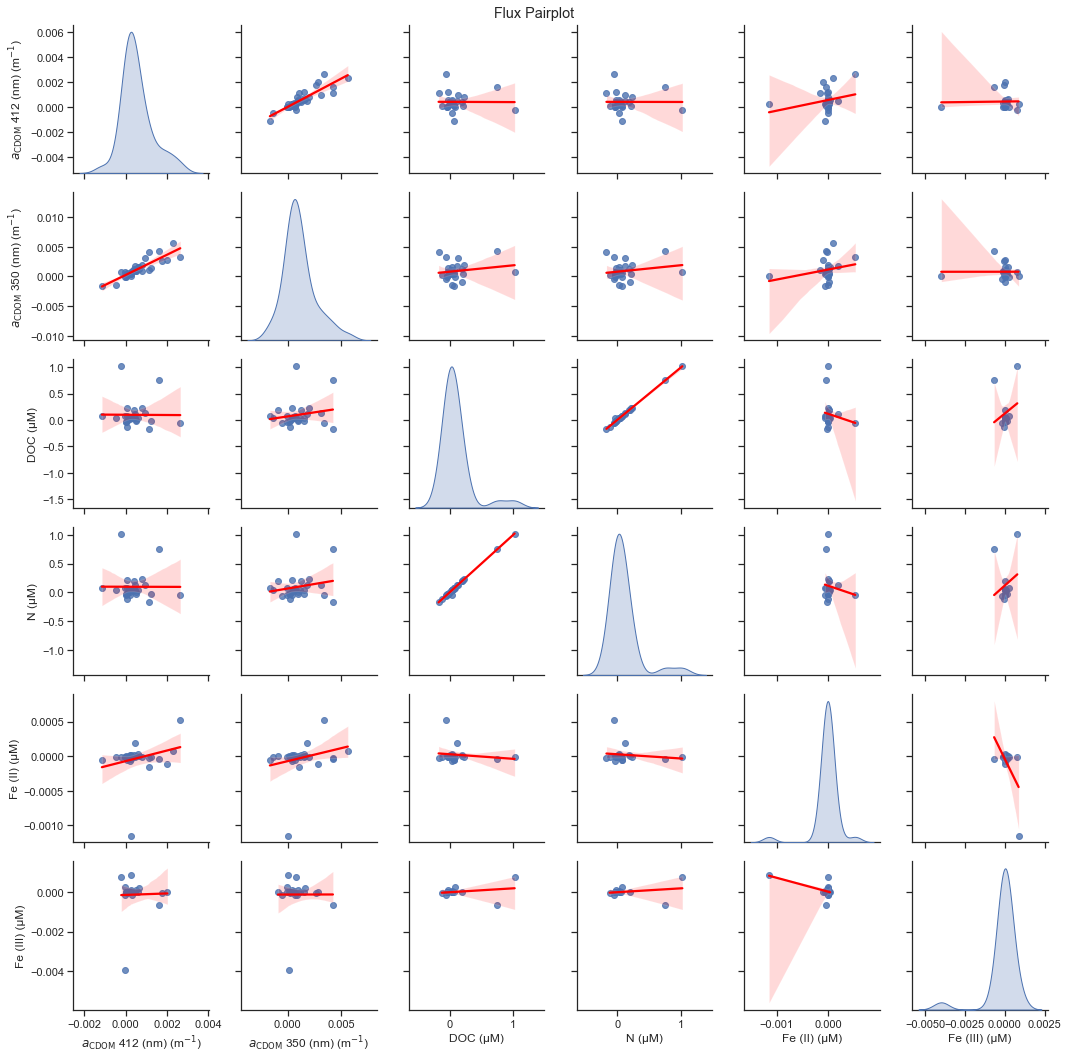

In [89]:
#SEE HOW WELL THE FLUXES COVARY 

# Define the variables to plot
variables = ['flux_aCDOM412', 'flux_aCDOM350', 'flux_doc', 'flux_tn', 'flux_fe2', 'flux_fe3']

# Make a subset with no duplicates
# Duplicate samples occur in the GOM2021 data because of rerunning cdom at different path lengths

# Create a pairplot with correlation coefficients
sns.set(style='ticks')
pairplot = sns.pairplot(df_flux[variables], kind='reg', diag_kind='kde',
                        plot_kws=dict(line_kws={'color': 'red'}), diag_kws=dict(shade=True))

# Set the axis labels and title
for i, var in enumerate(variables):
    pairplot.axes[variables.index(var), 0].set_ylabel(var.replace('flux_tn', 'N (\u03BCM)').replace('flux_doc', 'DOC (\u03BCM)').replace('flux_fe2', 'Fe (II) (\u03BCM)').replace('flux_fe3', 'Fe (III) (\u03BCM)').replace('flux_aCDOM412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('flux_aCDOM350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
    pairplot.axes[-1, i].set_xlabel(var.replace('flux_tn', 'N (\u03BCM)').replace('flux_doc', 'DOC (\u03BCM)').replace('flux_fe2', 'Fe (II) (\u03BCM)').replace('flux_fe3', 'Fe (III) (\u03BCM)').replace('flux_aCDOM412', r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)').replace('flux_aCDOM350', r'$a_{\mathrm{CDOM}}$ 350 (nm) (m$^{-1}$)'))
pairplot.fig.suptitle('Flux Pairplot')

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig("../../../Data_Thesis/FIGS/Cor_plots/FLUX_pairplot")

# Show the plot
plt.show()


# PART 10: Combonation plots 

Here we make figures of the BC, WC, and PW data all together.

In [90]:
import matplotlib.gridspec as gridspec

station_val = "St.MK"
df_locs_stn = df_locs[(df_locs['Station'] == station_val)]

desired_order = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']
df_locs_stn['Trip'] = pd.Categorical(df_locs_stn['Trip'], categories=desired_order, ordered=True)
df_locs_stn = df_locs_stn.sort_values('Trip')

col_order = df_locs_stn["Station"].tolist()
col_date = df_locs_stn["Date"].tolist()
col_maxd = df_locs_stn["Water_depth"].tolist()
col_maxd = [round(x, 1) for x in col_maxd]
col_notes = df_locs_stn["notes"].tolist()

df_locs_stn

C:\Users\12532\AppData\Local\Temp\ipykernel_20532\3664083060.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_locs_stn['Trip'] = pd.Categorical(df_locs_stn['Trip'], categories=desired_order, ordered=True)


Hight_m Station        Date  Water_depth  \
code                                                       
St.MK_GOM2021  0.201250   St.MK  2021-07-15         16.7   
St.MK_GOM21FA  0.217500   St.MK  2021-10-27         16.5   
St.MK_GOM22SP  0.136667   St.MK  2022-04-19         17.5   
St.MK_GOM22SU  0.053721   St.MK  2022-07-23         17.5   

                                                        notes           code  \
code                                                                           
St.MK_GOM2021                                                  St.MK_GOM2021   
St.MK_GOM21FA                                                  St.MK_GOM21FA   
St.MK_GOM22SP  Last sample may have fired in the water column  St.MK_GOM22SP   
St.MK_GOM22SU          Last sample collected in water column?  St.MK_GOM22SU   

                  Trip        sal       oxy  
code                                         
St.MK_GOM2021  GOM2021        NaN       NaN  
St.MK_GOM21FA  GOM21FA  26.572018  7.019276  
St.MK_GOM22SP  GOM22SP  29.813576  8.057314  
St.MK_GOM22SU  GOM22SU  19.954716  5.567649

In [91]:
#GET DATA SUBSETS 

#get WC data 
ds_doc_wc = df_doc_wc[(df_doc_wc['Location'] == station_val) ]
ds_iron_wc = df_iron_wc[(df_iron_wc['Location'] == station_val)]
ds_cdom_wc = df_cdom_wc[(df_cdom_wc['Station'] == station_val)]
ds_spectra_wc = df_spectra_wc[(df_spectra_wc['Station'] == station_val)]
ds_nisk_wc = df_nisk[(df_nisk['camp'] == station_val)]
ds_ctd = ds[(ds['station'] == station_val)]

#get BC data 
ds_doc_bc = df_doc_bc[(df_doc_bc['Location'] == station_val)]
ds_iron_bc = df_iron_bc[(df_iron_bc['Location'] == station_val)]
ds_cdom_bc = df_cdom_bc[(df_cdom_bc['Station'] == station_val)]
ds_spectra_bc = df_spectra_bc[(df_spectra_bc['Station'] == station_val)]
    
#get PW data 
ds_doc_pw = df_doc_pw[(df_doc_pw['Location'] == station_val)]
ds_iron_pw = df_iron_pw[(df_iron_pw['Location'] == station_val)]
ds_cdom_pw = df_cdom_pw[(df_cdom_pw['Station'] == station_val)]
ds_spectra_pw = df_spectra_pw[(df_spectra_pw['Station'] == station_val)]

C:\Users\12532\AppData\Local\Temp\ipykernel_20532\1138862311.py:162: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax13.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
C:\Users\12532\AppData\Local\Temp\ipykernel_20532\1138862311.py:162: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax13.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
C:\Users\12532\AppData\Local\Temp\ipykernel_20532\1138862311.py:162: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax13.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
C:\Users\12532\AppData\Local\Temp\ipykernel_20532\1138862311.py:162: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax13.set_xlim(0,ds_iron_wc['Fe2_uM'].max())


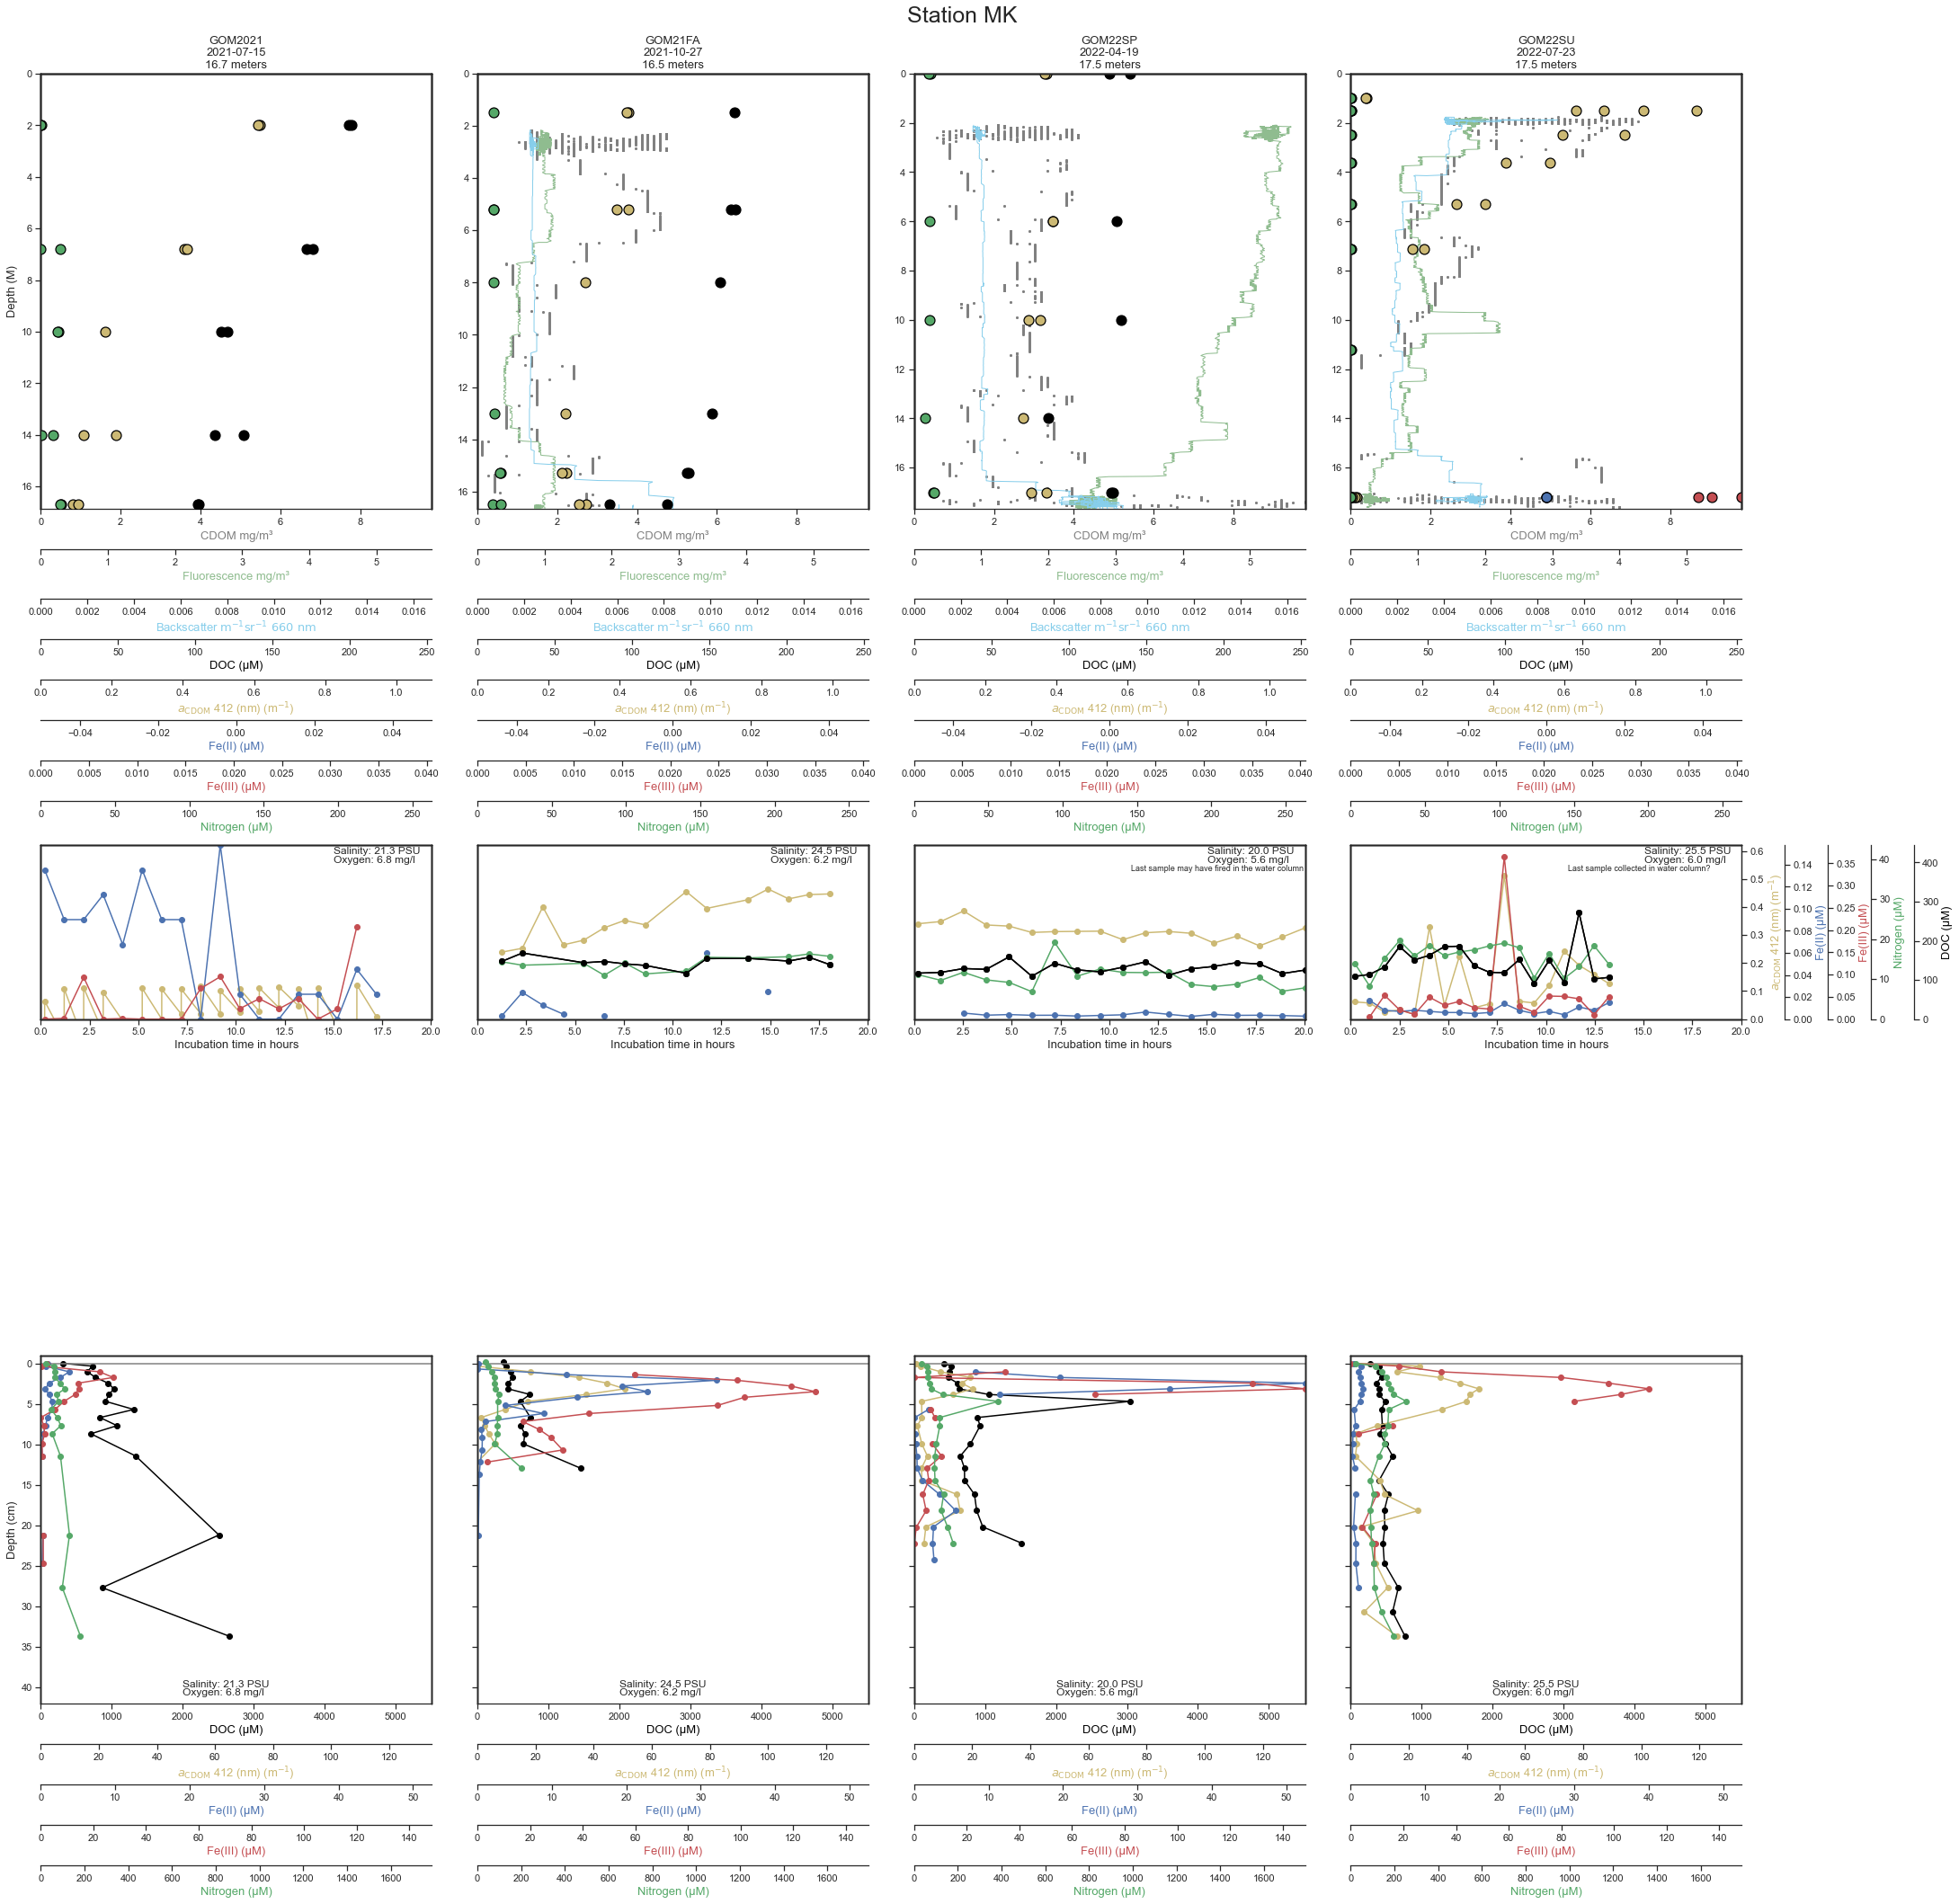

In [92]:
trips = ['GOM2021', 'GOM21FA', 'GOM22SP', 'GOM22SU']

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(30,30), gridspec_kw={'height_ratios': [2.5, 1, 2]})

for j, trip in enumerate(trips):
    ax10 = axs[0, j]
    ax20 = axs[1, j]
    ax30 = axs[2, j]
    
    #get WC data 
    doc_data_wc = ds_doc_wc[(ds_doc_wc['Campaign'] == trip) ]
    iron_data_wc = ds_iron_wc[(ds_iron_wc['Campaign'] == trip)]
    cdom_data_wc = ds_cdom_wc[(ds_cdom_wc['Trip'] == trip)]
    spectra_data_wc = ds_spectra_wc[(ds_spectra_wc['Trip'] == trip)]
    nisk_data_wc = df_nisk[(df_nisk['camp'] == trip)]
    data = ds_ctd[ds_ctd['camp'] == trip]
    
    #get BC data 
    doc_data_bc = ds_doc_bc[(ds_doc_bc['Campaign'] == trip)]
    iron_data_bc = ds_iron_bc[(ds_iron_bc['Campaign'] == trip)]
    cdom_data_bc = ds_cdom_bc[(ds_cdom_bc['Trip'] == trip)]
    spectra_data_bc = ds_spectra_bc[(ds_spectra_bc['Trip'] == trip)]
    
    #get PW data 
    doc_data_pw = ds_doc_pw[(ds_doc_pw['Campaign'] == trip)]
    iron_data_pw = ds_iron_pw[(ds_iron_pw['Campaign'] == trip)]
    cdom_data_pw = ds_cdom_pw[(ds_cdom_pw['Trip'] == trip)]
    spectra_data_pw = ds_spectra_pw[(ds_spectra_pw['Trip'] == trip)]
    
    #WATER COL get vars 
    doc_uM_wc = doc_data_wc['NPOC_uM'] 
    doc_uM_wc = np.asarray(doc_uM_wc, dtype=float).ravel()
    tn_uM_wc = doc_data_wc['TN_uM'] 
    tn_uM_wc = np.asarray(tn_uM_wc, dtype=float).ravel()  
    doc_depth_wc = doc_data_wc['Depth'] #X var 
    doc_depth_wc = np.asarray(doc_depth_wc, dtype=float).ravel()
    fe2_uM_wc = iron_data_wc['Fe2_uM'] 
    fe2_uM_wc = np.asarray(fe2_uM_wc, dtype=float).ravel()
    fet_uM_wc = iron_data_wc['FeT_uM'] 
    fet_uM_wc = np.asarray(fet_uM_wc, dtype=float).ravel()
    fe3_uM_wc = iron_data_wc['Fe3_uM'] 
    fe3_uM_wc = np.asarray(fe3_uM_wc, dtype=float).ravel()
    fe_depth_wc = iron_data_wc['Fe2_Depth'] 
    fe_depth_wc = np.asarray(fe_depth_wc, dtype=float).ravel()
    a412_wc = spectra_data_wc['a_412']
    a412_wc = np.asarray(a412_wc, dtype=float).ravel()
    spectra_depth_wc = spectra_data_wc['Sample_depth']
    spectra_depth_wc = np.asarray(spectra_depth_wc, dtype=float).ravel()
    
    #Benthic Chamber get vars 
    doc_uM_bc = doc_data_bc['NPOC_uM'] 
    doc_uM_bc = np.asarray(doc_uM_bc, dtype=float).ravel()
    tn_uM_bc = doc_data_bc['TN_uM'] 
    tn_uM_bc = np.asarray(tn_uM_bc, dtype=float).ravel()
    doc_time_bc = doc_data_bc['Time'] #X var 
    doc_time_bc = np.asarray(doc_time_bc, dtype=float).ravel()
    fe2_uM_bc = iron_data_bc['Fe2_uM'] 
    fe2_uM_bc = np.asarray(fe2_uM_bc, dtype=float).ravel()
    fet_uM_bc = iron_data_bc['FeT_uM'] 
    fet_uM_bc = np.asarray(fet_uM_bc, dtype=float).ravel()
    fe3_uM_bc = iron_data_bc['Fe3_uM'] 
    fe3_uM_bc = np.asarray(fe3_uM_bc, dtype=float).ravel()
    fe_time_bc = iron_data_bc['Fe2_Time'] 
    fe_time_bc = np.asarray(fe_time_bc, dtype=float).ravel()
    a412_bc = spectra_data_bc['a_412']
    a412_bc = np.asarray(a412_bc, dtype=float).ravel()
    spectra_time_bc = spectra_data_bc['BC_time']
    spectra_time_bc = np.asarray(spectra_time_bc, dtype=float).ravel()
    
    #pore watwe get vars 
    #get vars 
    doc_uM_pw = doc_data_pw['NPOC_uM'] 
    doc_uM_pw = np.asarray(doc_uM_pw, dtype=float).ravel()
    tn_uM_pw = doc_data_pw['TN_uM'] 
    tn_uM_pw = np.asarray(tn_uM_pw, dtype=float).ravel()
    doc_depth_pw = doc_data_pw['Depth'] #X var 
    doc_depth_pw = np.asarray(doc_depth_pw, dtype=float).ravel()
    fe2_uM_pw = iron_data_pw['Fe2_uM'] 
    fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
    fet_uM_pw = iron_data_pw['FeT_uM'] 
    fet_uM_pw = np.asarray(fet_uM_pw, dtype=float).ravel()
    fe3_uM_pw = iron_data_pw['Fe3_uM'] 
    fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
    fe_depth_pw = iron_data_pw['Fe2_Depth'] 
    fe_depth_pw = np.asarray(fe_depth_pw, dtype=float).ravel()
    a412_pw = spectra_data_pw['a_412']
    a412_pw = np.asarray(a412_pw, dtype=float).ravel()
    spectra_depth_pw = spectra_data_pw['Sample_depth']
    spectra_depth_pw = np.asarray(spectra_depth_pw, dtype=float).ravel()
    
#WATER COL PLOTS
    #CTD CDOM DATA 
    pressure = data['Pressure [dbar]'] #X var 
    pressure = np.asarray(pressure, dtype=float).ravel()
    mask = (data['wetCDOM'] > 0) & (data['wetCDOM'] <= (data['wetCDOM'].mean() + data['wetCDOM'].std()))
    wetCDOM = np.where(mask, data['wetCDOM'], np.nan)
    
    #CTD flor DATA 
    flECO = data['flECO-AFL'] #X var 
    flECO = np.asarray(flECO, dtype=float).ravel()
    
    #CTD bb DATA 
    BB = data['turbWETbb0_recal'] #X var 
    BB = np.asarray(BB, dtype=float).ravel()
    
    size = 120 
    edgecolor = 'black'
    linewidth = 1.25
    txt_sx = 13
    
    #CTD CDOM
    ax10.scatter(wetCDOM, pressure, c='grey', s = .5)
    ax10.set_xlim(0,ds['wetCDOM_clean'].mean()+ds['wetCDOM_clean'].std()*2.5)
    ax10.invert_yaxis()
    ax10.set_ylim(bottom = col_maxd[j]*1.01, top = 0)
    ax10.set_xlabel('CDOM mg/m\u00B3', size = txt_sx, c='grey')
    
    #CTD FLOR
    ax17 = ax10.twiny()
    ax17.plot(flECO, pressure, c = "#8FBC8F", linewidth=1.0)
    ax17.set_xlim(0,ds['flECO-AFL'].mean()+ds['flECO-AFL'].std()*2.5)
        #Set x-axis label on bottom subplots
    ax17.set_xlabel('Fluorescence mg/m\u00B3', size = txt_sx, c= '#8FBC8F')
    ax17.xaxis.set_ticks_position('bottom')
    ax17.xaxis.set_label_position('bottom')
    ax17.spines['bottom'].set_position(('outward', 45))
    
    #CTD Backscatter
    ax18 = ax10.twiny()
    ax18.plot(BB, pressure, c = "skyblue", linewidth=1.0)
    ax18.set_xlim(0,ds['turbWETbb0_recal'].mean()+ds['turbWETbb0_recal'].std()*2.5)
        #Set x-axis label on bottom subplots
    ax18.set_xlabel(r'Backscatter $\mathrm{m^{-1}sr^{-1}\ 660\ nm}$', size = txt_sx, c='skyblue')
    ax18.xaxis.set_ticks_position('bottom')
    ax18.xaxis.set_label_position('bottom')
    ax18.spines['bottom'].set_position(('outward', 100))
    
    #PLOT DOC
    ax11 = ax10.twiny()
    ax11.scatter(doc_uM_wc, doc_depth_wc, c='black', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax11.set_xlim(0,df_doc_wc['NPOC_uM'].max())
    ax11.set_ylim(col_maxd[j]*1.01,0)
        #Set x-axis label on bottom subplot
    ax11.set_xlabel('DOC (\u03BCM)', size = txt_sx, c='black')
    ax11.xaxis.set_ticks_position('bottom')
    ax11.xaxis.set_label_position('bottom')
    ax11.spines['bottom'].set_position(('outward', 145))
        
    #plot CDOM
    ax12 = ax10.twiny()
    ax12.scatter(a412_wc, spectra_depth_wc, c='y', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax12.set_xlim(0,1.1)
        #Set x-axis label on bottom subplots
    ax12.xaxis.set_ticks_position('bottom')
    ax12.xaxis.set_label_position('bottom')
    ax12.spines['bottom'].set_position(('outward', 190))
    ax12.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= txt_sx, c='y')
    
    #plot iron 2 
    ax13 = ax10.twiny()
    ax13.scatter(fe2_uM_wc, fe_depth_wc, c='b', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax13.set_xlim(0,ds_iron_wc['Fe2_uM'].max())
        #Set x-axis label on bottom subplots
    ax13.xaxis.set_ticks_position('bottom')
    ax13.xaxis.set_label_position('bottom')
    ax13.spines['bottom'].set_position(('outward', 235))
    ax13.set_xlabel('Fe(II) (\u03BCM)', size= txt_sx, c='b')
        
    #plot iron 3 
    ax14 = ax10.twiny()
    ax14.scatter(fe3_uM_wc, fe_depth_wc, c='r', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax14.set_xlim(0,ds_iron_wc['Fe3_uM'].max())
        #Set x-axis label on bottom subplots
    ax14.xaxis.set_ticks_position('bottom')
    ax14.xaxis.set_label_position('bottom')
    ax14.spines['bottom'].set_position(('outward', 280))
    ax14.set_xlabel('Fe(III) (\u03BCM)', size= txt_sx, c='r')
    
    #plot nitrogen  
    ax15 = ax10.twiny()
    ax15.scatter(tn_uM_wc, doc_depth_wc, c='g', s = size, edgecolor=edgecolor, linewidths=linewidth)
    ax15.set_xlim(0,df_doc_wc['TN_uM'].max())
        #Set x-axis label on bottom subplots
    ax15.xaxis.set_ticks_position('bottom')
    ax15.xaxis.set_label_position('bottom')
    ax15.spines['bottom'].set_position(('outward', 325))
    ax15.set_xlabel('Nitrogen (\u03BCM)', size= txt_sx, c='g')
    
    #set the titels 
    ax10.set_title(f'{trip}\n{col_date[j]}\n{col_maxd[j]} meters', size = 13)
    #Set y-axis label on bottom subplots
    if j == 0:
        ax10.set_ylabel('Depth (M)', size= txt_sx)
        
#Benthic Chamber PLOTS
    #plot DOC
    ax20.plot(doc_time_bc, doc_uM_bc, 'o', ls='-', c='black')
    ax20.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    ax20.set_xlim(0,ds_spectra_bc['BC_time'].max())
    
    #plot doc lables off 
    ax20.set_ylabel('')
    ax20.set_xlabel('Incubation time in hours', size= txt_sx)
    ax20.tick_params(axis='y', length=0, width=0)
    ax20.yaxis.set_ticklabels([])
            
    #plot CDOM
    ax21 = ax20.twinx()
    ax21.plot(spectra_time_bc, a412_bc, 'o', ls='-', c='y')
    ax21.set_ylim(0,df_spectra_bc['a_412'].max())
    if j == len(trips)-1:
        ax21.spines["right"].set_position(("axes", 1))
        ax21.set_ylabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= txt_sx, c='y')
    else: 
        ax21.set_yticks([])
        ax21.set_ylabel("")
        ax21.yaxis.set_ticklabels([])
        
    #plot iron 2     
    ax22 = ax20.twinx()
    ax22.plot(fe_time_bc, fe2_uM_bc, 'o', ls='-', c='b')
    ax22.set_ylim(0,df_iron_bc['Fe2_uM'].max())
    if j == len(trips)-1:
        ax22.spines["right"].set_position(("axes", 1.11))
        ax22.set_ylabel('Fe(II) (\u03BCM)', size= txt_sx, c='b')
    else: 
        ax22.set_ylabel('')
        ax22.yaxis.set_ticklabels([])
        ax22.set_yticks([])
    
    #plot iron 3 
    ax23 = ax20.twinx()
    ax23.plot(fe_time_bc, fe3_uM_bc, 'o', ls='-', c='r')
    ax23.set_ylim(0,df_iron_bc['Fe3_uM'].max())
    if j == len(trips)-1:
        ax23.spines["right"].set_position(("axes", 1.22))
        ax23.set_ylabel('Fe(III) (\u03BCM)', size= txt_sx, c='r')
    else: 
        ax23.set_ylabel('')
        ax23.yaxis.set_ticklabels([]) 
        ax23.set_yticks([])
    
    #plot nitrogen
    ax24 = ax20.twinx()
    ax24.plot(doc_time_bc, tn_uM_bc, 'o', ls='-', c='g')
    ax24.set_ylim(0,df_doc_bc['TN_uM'].max()) 
    if j == len(trips)-1:
        ax24.spines["right"].set_position(("axes", 1.33))
        ax24.set_ylabel('Nitrogen (\u03BCM)', size= txt_sx, c='g')
    else: 
        ax24.set_ylabel('')
        ax24.yaxis.set_ticklabels([])
        ax24.set_yticks([])
    
    #plot DOC
    ax25 = ax20.twinx()
    ax25.plot(doc_time_bc, doc_uM_bc, 'o', ls='-', c='black')
    ax25.set_ylim(0,df_doc_bc['NPOC_uM'].max())
    if j == len(trips)-1:
        ax25.spines["right"].set_position(("axes", 1.44))
        ax25.set_ylabel('DOC (\u03BCM)', size = txt_sx, c='black')
    else: 
        ax25.set_ylabel('')
        ax25.yaxis.set_ticklabels([])
        ax25.set_yticks([])
        
    ax20.text(ds_spectra_bc['BC_time'].max()/3*2.25, df_doc_bc['NPOC_uM'].max()*.95, f'Salinity: {col_sal[j]} PSU')
    ax20.text(ds_spectra_bc['BC_time'].max()/3*2.25, df_doc_bc['NPOC_uM'].max()*.9, f'Oxygen: {col_oxy[j]} mg/l')
    ax20.text(ds_spectra_bc['BC_time'].max()/1.8, df_doc_bc['NPOC_uM'].max()*.85, f'{col_notes[j]}', size = 9)
        
#Pore water PLOTS 
    #PLOT DOC
    ax30.plot(doc_uM_pw, doc_depth_pw, 'o', ls='-', c='black')
    ax30.set_xlim(0,df_doc_pw['NPOC_uM'].max())
    ax30.set_ylim(42,-1)
    ax30.axhline(y=0, color='grey', linestyle='-', label='Sediment Water Interface')
    #plot lables 
    #Set x-axis label on bottom subplots
    ax30.set_xlabel('DOC (\u03BCM)', size = txt_sx, c='black')
    #Set y-axis label on bottom subplots
    if j == 0:
        ax30.set_ylabel('Depth (cm)', size= txt_sx)
        
    #plot CDOM
    ax31 = ax30.twiny()
    ax31.plot(a412_pw, spectra_depth_pw, 'o', ls='-', c='y')
    ax31.set_xlim(0,df_spectra_pw['a_412'].max())
    #Set x-axis label on bottom subplots
    ax31.xaxis.set_ticks_position('bottom')
    ax31.xaxis.set_label_position('bottom')
    ax31.spines['bottom'].set_position(('outward', 45))
    ax31.set_xlabel(r'$a_{\mathrm{CDOM}}$ 412 (nm) (m$^{-1}$)', size= txt_sx, c='y')
    
    #plot iron 2 
    ax32 = ax30.twiny()
    ax32.plot(fe2_uM_pw, fe_depth_pw, 'o', ls='-', c='b')
    ax32.set_xlim(0,ds_iron_pw['Fe2_uM'].max())
    #Set x-axis label on bottom subplots
    ax32.xaxis.set_ticks_position('bottom')
    ax32.xaxis.set_label_position('bottom')
    ax32.spines['bottom'].set_position(('outward', 90))
    ax32.set_xlabel('Fe(II) (\u03BCM)', size= txt_sx, c='b')
        
    ax33 = ax30.twiny()
    ax33.plot(fe3_uM_pw, fe_depth_pw, 'o', ls='-', c='r')
    ax33.set_xlim(0,ds_iron_pw['Fe3_uM'].max())
    #Set x-axis label on bottom subplots
    ax33.xaxis.set_ticks_position('bottom')
    ax33.xaxis.set_label_position('bottom')
    ax33.spines['bottom'].set_position(('outward', 135))
    ax33.set_xlabel('Fe(III) (\u03BCM)', size= txt_sx, c='r')
    
    ax34 = ax30.twiny()
    ax34.plot(tn_uM_pw, doc_depth_pw, 'o', ls='-', c='g')
    ax34.set_xlim(0,df_doc_pw['TN_uM'].max())
    #Set x-axis label on bottom subplots
    ax34.xaxis.set_ticks_position('bottom')
    ax34.xaxis.set_label_position('bottom')
    ax34.spines['bottom'].set_position(('outward', 180))
    ax34.set_xlabel('Nitrogen (\u03BCM)', size= txt_sx, c='g')
        
    #turn off other axis
    if j != 0:
        ax31.set_yticklabels([])
        ax32.set_yticklabels([])
        ax33.set_yticklabels([])
        ax34.set_yticklabels([])
    
    ax30.text(2000, 40, f'Salinity: {col_sal[j]} PSU')
    ax30.text(2000, 41, f'Oxygen: {col_oxy[j]} mg/l')

fig.suptitle("Station MK \n", size = 25)
fig.set_facecolor('w')
plt.tight_layout()
#plt.savefig("../../../Data_Thesis/FIGS/")

# Show the plot
plt.show()

# PART 11: Model Building 

here we are going to try and build some usefull models

                            OLS Regression Results                            
Dep. Variable:                NPOC_uM   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     32.13
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.91e-14
Time:                        20:20:37   Log-Likelihood:                -145.81
No. Observations:                  45   AIC:                             323.6
Df Residuals:                      29   BIC:                             352.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

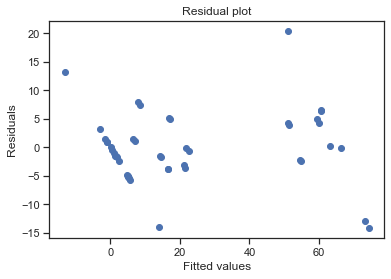

                                         sum_sq    df          F        PR(>F)
Intercept                           1830.645807   1.0  30.887070  5.393674e-06
Fe3_uM                               321.214681   1.0   5.419607  2.709271e-02
Fe2_uM                                10.525639   1.0   0.177591  6.765590e-01
Fe3_uM:Fe2_uM                        893.576300   1.0  15.076622  5.493628e-04
a_300                               1361.109430   1.0  22.964946  4.518877e-05
Fe3_uM:a_300                         545.485962   1.0   9.203563  5.054299e-03
Fe2_uM:a_300                          80.782769   1.0   1.362985  2.525305e-01
Fe3_uM:Fe2_uM:a_300                 1081.256082   1.0  18.243197  1.907179e-04
ss_275_700_SEM                      2814.452225   1.0  47.486075  1.429347e-07
Fe3_uM:ss_275_700_SEM                491.548369   1.0   8.293515  7.404366e-03
Fe2_uM:ss_275_700_SEM                 37.238578   1.0   0.628298  4.344174e-01
Fe3_uM:Fe2_uM:ss_275_700_SEM         938.810711   1.

In [93]:
#WATER COLUMN
# Define the model formula
formula = 'NPOC_uM ~ Fe3_uM*Fe2_uM*a_300*ss_275_700_SEM'

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_wc).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)


                            OLS Regression Results                            
Dep. Variable:                NPOC_uM   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     2.892
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.00e-07
Time:                        20:20:37   Log-Likelihood:                -967.85
No. Observations:                 208   AIC:                             2192.
Df Residuals:                      80   BIC:                             2619.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

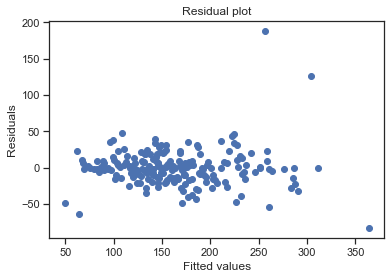

                                                           sum_sq    df  \
Intercept                                              346.054387   1.0   
Fe3_uM                                                  23.461585   1.0   
Fe2_uM                                                 879.776671   1.0   
Fe3_uM:Fe2_uM                                         1228.542390   1.0   
a_350                                                  109.600730   1.0   
...                                                           ...   ...   
a_350:a_412:a_500:ss_350_400_SEM:ss_275_700_HM          54.187402   1.0   
Fe3_uM:a_350:a_412:a_500:ss_350_400_SEM:ss_275_...    1173.096229   1.0   
Fe2_uM:a_350:a_412:a_500:ss_350_400_SEM:ss_275_...      68.343848   1.0   
Fe3_uM:Fe2_uM:a_350:a_412:a_500:ss_350_400_SEM:...      40.923096   1.0   
Residual                                            134039.996111  80.0   

                                                           F    PR(>F)  
Intercept                 

In [94]:
#BENTHIC LANDER 
# Define the model formula
formula = 'NPOC_uM ~ Fe3_uM*Fe2_uM*a_350*a_412*a_500*ss_350_400_SEM*ss_275_700_HM'

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_bc).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)


                            OLS Regression Results                            
Dep. Variable:                NPOC_uM   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     9.179
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.01e-69
Time:                        20:20:37   Log-Likelihood:                -3839.8
No. Observations:                 571   AIC:                             7936.
Df Residuals:                     443   BIC:                             8492.
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

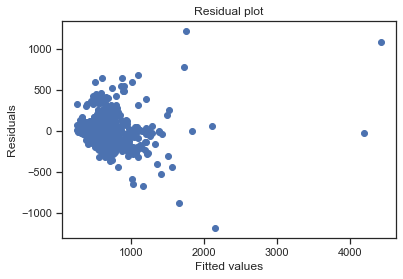

                                                          sum_sq     df  \
Intercept                                           9.178636e+05    1.0   
Fe3_uM                                              1.391229e+05    1.0   
Fe2_uM                                              1.128219e+03    1.0   
Fe3_uM:Fe2_uM                                       1.668402e+04    1.0   
a_275                                               2.920577e+06    1.0   
...                                                          ...    ...   
a_275:a_350:a_412:ss_275_295_HM:ss_275_700_HM       1.779515e+04    1.0   
Fe3_uM:a_275:a_350:a_412:ss_275_295_HM:ss_275_7...  1.272273e+04    1.0   
Fe2_uM:a_275:a_350:a_412:ss_275_295_HM:ss_275_7...  1.986022e+04    1.0   
Fe3_uM:Fe2_uM:a_275:a_350:a_412:ss_275_295_HM:s...  3.439452e+04    1.0   
Residual                                            2.318342e+07  443.0   

                                                            F        PR(>F)  
Intercept            

In [95]:
#PORE WATER 
# Define the model formula
formula = 'NPOC_uM ~ Fe3_uM*Fe2_uM*a_275*a_350*a_412*ss_275_295_HM*ss_275_700_HM'

# Fit the linear regression model
model = sm.formula.ols(formula=formula, data=df_pw).fit()

# Print the model summary
print(model.summary())

# Plot the residuals against the fitted values
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual plot')
plt.show()

# Perform ANOVA
anova_results = anova_lm(model, typ=3)
print(anova_results)
